In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [2]:
conn = sqlite3.connect('web-performance.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements

msm_id            timestamp  \
0     d31444a1-777c-45ae-bb04-f67fbcf67716  2022-06-08_15_01_00   
1     ec2d9a45-57d7-46ec-a505-26427fb1aa48  2022-06-08_15_01_54   
2     a43c51c9-7361-47e7-8b05-95c7d2105c7f  2022-06-08_15_02_48   
3     4d5392b4-2eda-438c-b2d3-233007fecf79  2022-06-08_15_03_42   
4     00dc53ef-e9fa-45e6-af88-2804ef7f2a57  2022-06-08_15_04_36   
...                                    ...                  ...   
1448  669a2e98-415e-4d3e-b8c3-b583d8fef133  2022-06-09_13_32_00   
1449  4f178ba8-8458-495d-8f0e-754a58734d49  2022-06-09_13_32_55   
1450  907e8072-3a93-44d4-bd70-12862dfec30c  2022-06-09_13_33_49   
1451  a3d6174b-4a5f-4d58-8feb-1f30c1052a73  2022-06-09_13_34_43   
1452  6e9b6f63-0827-4964-b98f-a0ff02dc6572  2022-06-09_13_35_38   

     experiment_type error            website  
0                dsl          www.example.org  
1              cable          www.example.org  
2              fiber          www.example.org  
3                 4g          www.example.org  
4          4g-medium          www.example.org  
...              ...   ...                ...  
1448             dsl        www.wikipedia.org  
1449           cable        www.wikipedia.org  
1450           fiber        www.wikipedia.org  
1451              4g        www.wikipedia.org  
1452       4g-medium        www.wikipedia.org  

[1453 rows x 5 columns]

In [3]:
measurements.error.value_counts()

    1453
Name: error, dtype: int64

In [4]:
df_web_perf = pd.read_sql_query("SELECT * FROM web_performance_metrics", conn)
df_dns_perf = pd.read_sql_query("SELECT * FROM dns_metrics", conn)
df_lookups = pd.read_sql_query("SELECT * FROM lookups", conn)
conn.close()

In [5]:
df_web_perf = pd.merge(df_web_perf, measurements, on='msm_id')

In [6]:
df_web_perf.groupby(['website', 'is_warmup']).agg(plt=('loadEventStart', 'median'),fcp=('firstContentfulPaint', 'median'))

plt     fcp
website           is_warmup                 
www.example.org   0            72.20   84.00
                  1           186.25  192.25
www.instagram.com 0           315.10  103.20
                  1          1695.10  199.65
www.wikipedia.org 0           121.20   88.70
                  1           422.80  347.50

In [7]:
df_dns_perf_metrics = df_dns_perf.copy()

In [8]:
df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)

df_dns_perf_metrics['metric_type'] = "none"
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]

df_dns_perf_metrics['base'] = 1000
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])

df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']

df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]

df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')

df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')

df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]

df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')

df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start
df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end

df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [9]:
df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].groupby(['transport_protocol', 'is_warmup']).agg(lookup_dur=('duration','median'))

lookup_dur
transport_protocol is_warmup            
DoH                0          148.579734
DoQ                0          124.306323
DoUDP              0           44.125883

In [124]:
df_exchange_times = df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].copy()
df_exchange_times['elapsed'] = df_exchange_times['duration']

In [125]:
df_dns_and_h3 = pd.merge(df_web_perf, df_exchange_times[['msm_id', 'elapsed', 'transport_protocol']], on='msm_id')


In [127]:
df_dns_and_h3['full_plt'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['loadEventStart']
df_dns_and_h3['full_fp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstPaint']
df_dns_and_h3['full_fcp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstContentfulPaint']

In [128]:
df_dns_and_h3['h3_description'] = 'H3 1-RTT'
df_dns_and_h3['h3_description'] = np.where(df_dns_and_h3['is_warmup'] == 0, 'H3 0-RTT', df_dns_and_h3['h3_description'])

In [129]:
df_dns_and_h3.h3_description.value_counts() #thrice the actual value because of join

H3 1-RTT    4359
H3 0-RTT    4359
Name: h3_description, dtype: int64

In [130]:
df_dns_and_h3.transport_protocol.value_counts() #twice the actual value because of join

DoQ      2906
DoH      2906
DoUDP    2906
Name: transport_protocol, dtype: int64

In [131]:
df_dns_and_h3.website.value_counts()

www.instagram.com    4320
www.example.org      2208
www.wikipedia.org    2190
Name: website, dtype: int64

In [132]:
df_dns_and_h3.experiment_type.value_counts()

dsl          1746
cable        1746
fiber        1746
4g           1740
4g-medium    1740
Name: experiment_type, dtype: int64

In [133]:
df_dns_and_h3['experiment_description'] = df_dns_and_h3.transport_protocol + ' + ' + df_dns_and_h3.h3_description

In [134]:
df_dns_and_h3['experiment_description'].value_counts()

DoQ + H3 1-RTT      1453
DoH + H3 1-RTT      1453
DoUDP + H3 1-RTT    1453
DoQ + H3 0-RTT      1453
DoH + H3 0-RTT      1453
DoUDP + H3 0-RTT    1453
Name: experiment_description, dtype: int64

dsl
count     74.000000
mean     311.514896
std        4.743950
min      300.028277
10%      307.735723
20%      308.893151
25%      308.998343
30%      309.156657
40%      310.158346
50%      310.836242
60%      311.249681
70%      311.652654
75%      312.332019
80%      312.490220
90%      320.637982
100%     325.141103
max      325.141103
Name: full_plt, dtype: float64
count     74.000000
mean     196.910842
std        1.028937
min      194.534101
10%      195.804396
20%      196.072649
25%      196.148162
30%      196.307889
40%      196.542134
50%      196.715981
60%      197.166933
70%      197.414784
75%      197.537324
80%      197.714561
90%      198.417868
100%     199.322230
max      199.322230
Name: full_plt, dtype: float64
count     74.000000
mean     335.703614
std        4.661404
min      324.221170
10%      331.808318
20%      333.277256
25%      333.503065
30%      333.629606
40%      334.334812
50%      334.880362
60%      335.287755
70%      335.845438
75%      336.4

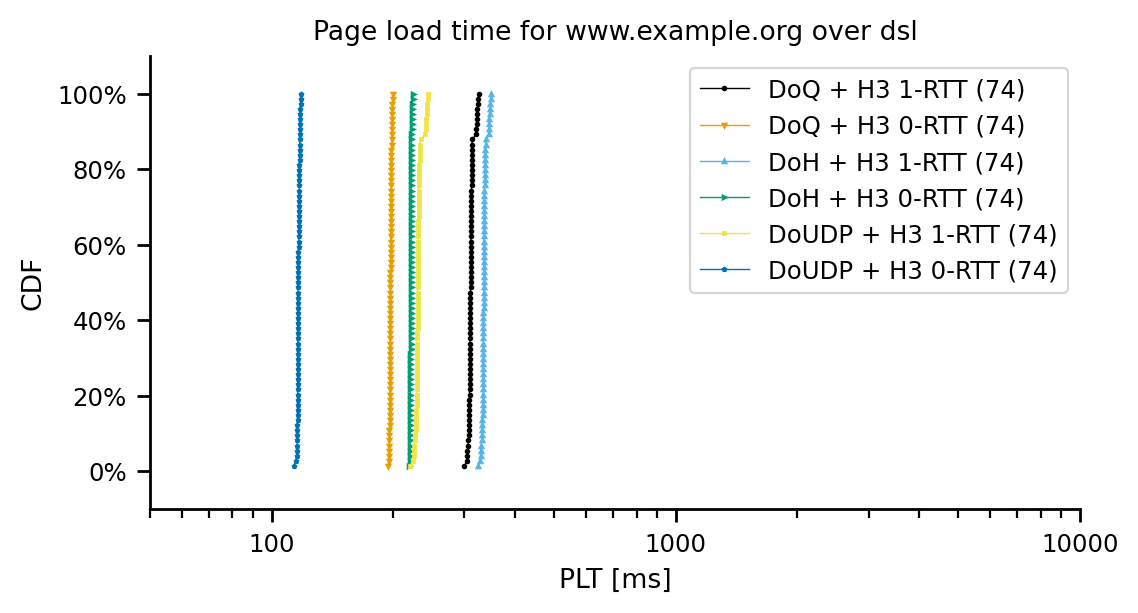

count     73.000000
mean     548.514787
std       25.631338
min      483.456986
10%      520.712472
20%      529.120983
25%      533.342053
30%      536.157974
40%      543.120747
50%      546.936450
60%      550.660394
70%      554.124250
75%      555.031360
80%      560.925499
90%      590.315417
100%     608.024921
max      608.024921
Name: full_plt, dtype: float64
count     73.000000
mean     241.047664
std       25.593359
min      217.509104
10%      220.771401
20%      221.610887
25%      221.811886
30%      222.180217
40%      222.570710
50%      223.363236
60%      225.175464
70%      268.404058
75%      273.473719
80%      274.288326
90%      276.988458
100%     288.367474
max      288.367474
Name: full_plt, dtype: float64
count     73.000000
mean     572.650601
std       25.531589
min      507.090136
10%      545.699128
20%      553.011851
25%      557.821375
30%      560.650133
40%      567.167308
50%      570.373934
60%      574.790220
70%      577.982804
75%      579.49760

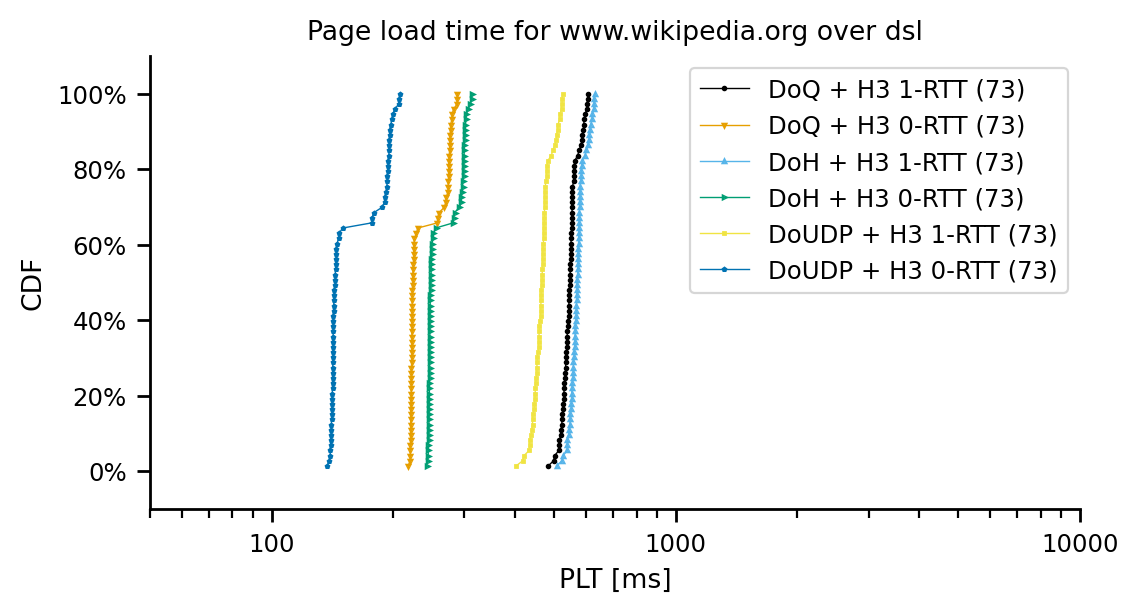

count     144.000000
mean     4680.433222
std         8.480083
min      4663.959932
10%      4670.460768
20%      4672.653482
25%      4673.922499
30%      4675.148655
40%      4677.029136
50%      4679.904611
60%      4682.184136
70%      4684.141768
75%      4685.531634
80%      4687.202049
90%      4691.457435
100%     4706.377519
max      4706.377519
Name: full_plt, dtype: float64
count    144.000000
mean     440.790861
std        6.658613
min      428.189611
10%      433.419203
20%      435.012742
25%      435.851105
30%      436.567273
40%      438.178929
50%      439.636913
60%      441.403764
70%      444.193112
75%      445.240171
80%      446.916682
90%      449.394948
100%     460.889494
max      460.889494
Name: full_plt, dtype: float64
count     144.000000
mean     4704.647142
std         8.491124
min      4688.275862
10%      4694.701507
20%      4696.574686
25%      4697.744368
30%      4699.057787
40%      4701.257363
50%      4704.404152
60%      4706.385232
70%      4

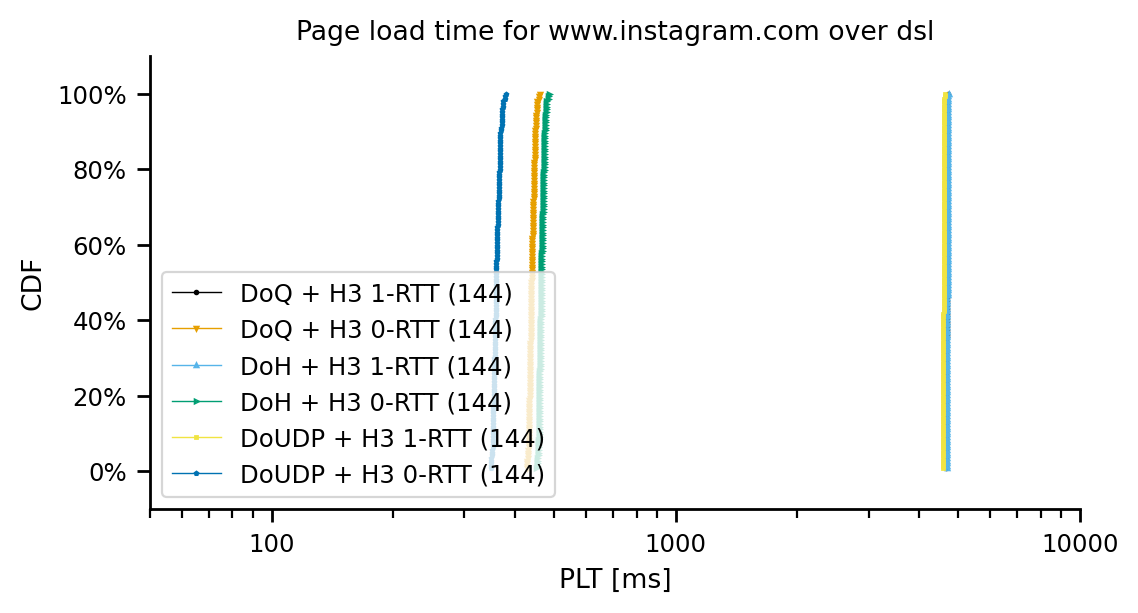

cable
count     74.000000
mean     194.887079
std        3.047129
min      183.868374
10%      191.937078
20%      193.314482
25%      194.069423
30%      194.414820
40%      194.979357
50%      195.657480
60%      196.087523
70%      196.586547
75%      196.811896
80%      196.995357
90%      197.381434
100%     199.756015
max      199.756015
Name: full_plt, dtype: float64
count     74.000000
mean     103.166808
std        0.844681
min      101.180114
10%      102.137853
20%      102.547846
25%      102.610702
30%      102.678266
40%      102.853660
50%      103.002692
60%      103.172833
70%      103.622306
75%      103.827842
80%      103.927696
90%      104.268702
100%     105.376866
max      105.376866
Name: full_plt, dtype: float64
count     74.000000
mean     218.353625
std        3.176887
min      207.286107
10%      214.897461
20%      216.874044
25%      217.312913
30%      218.101835
40%      218.613596
50%      219.149398
60%      219.614912
70%      220.093859
75%      220

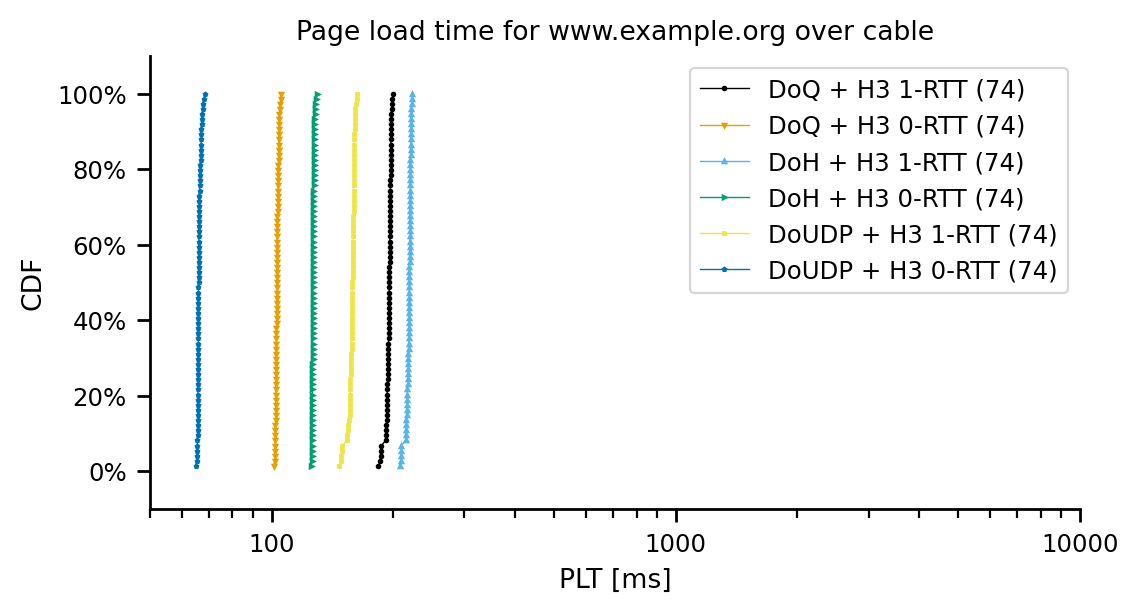

count     73.000000
mean     413.554987
std       16.868021
min      357.026029
10%      391.793224
20%      401.942519
25%      406.343670
30%      409.733614
40%      413.305976
50%      415.642441
60%      417.637838
70%      422.027837
75%      425.080835
80%      426.593069
90%      432.261623
100%     448.150572
max      448.150572
Name: full_plt, dtype: float64
count     73.000000
mean     151.250877
std       25.572520
min      123.757790
10%      127.365502
20%      128.066222
25%      128.541308
30%      128.832892
40%      130.578865
50%      133.086110
60%      170.125302
70%      175.209326
75%      178.364513
80%      179.152053
90%      184.374934
100%     195.400871
max      195.400871
Name: full_plt, dtype: float64
count     73.000000
mean     436.974110
std       16.920318
min      380.461974
10%      415.144982
20%      425.211153
25%      430.406909
30%      432.582701
40%      436.796473
50%      438.636592
60%      441.388535
70%      445.834853
75%      448.98564

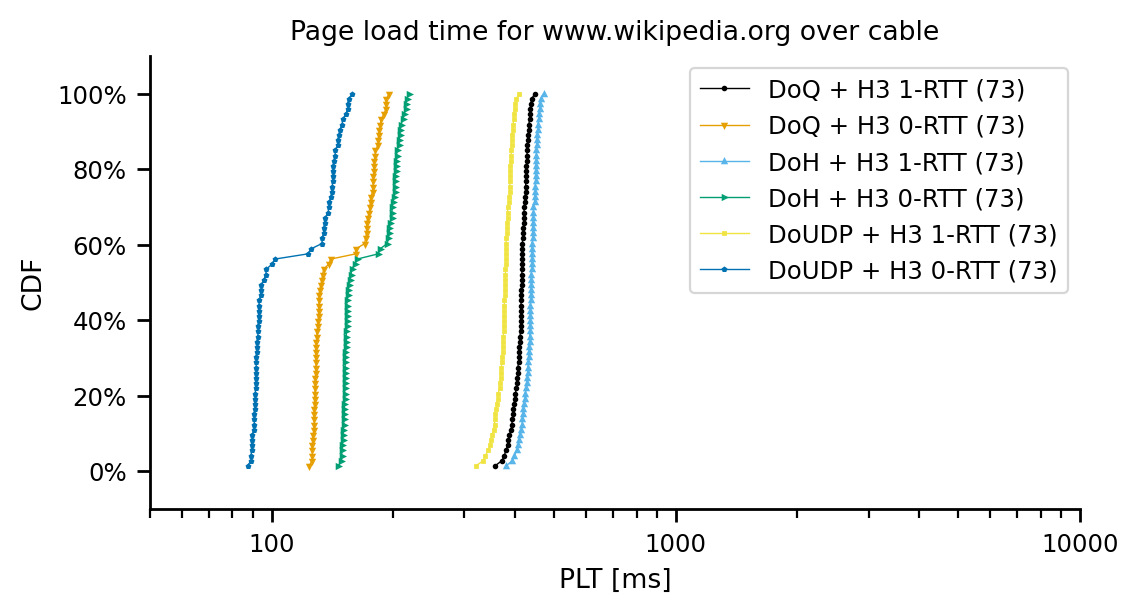

count    144.000000
mean     807.102199
std        7.169530
min      787.153688
10%      798.094066
20%      800.529819
25%      801.828850
30%      803.227319
40%      805.469663
50%      807.893645
60%      809.036060
70%      811.008397
75%      811.738157
80%      813.003475
90%      816.295062
100%     827.599266
max      827.599266
Name: full_plt, dtype: float64
count    144.000000
mean     252.636921
std        4.752846
min      244.671990
10%      246.686760
20%      248.256927
25%      248.582961
30%      249.020630
40%      250.875798
50%      252.195109
60%      253.555616
70%      255.415738
75%      256.338351
80%      257.185644
90%      258.794767
100%     264.918695
max      264.918695
Name: full_plt, dtype: float64
count    144.000000
mean     830.650119
std        7.144519
min      811.022798
10%      821.528174
20%      824.047447
25%      825.080375
30%      826.900256
40%      828.910197
50%      831.327703
60%      832.522413
70%      834.404730
75%      835.59449

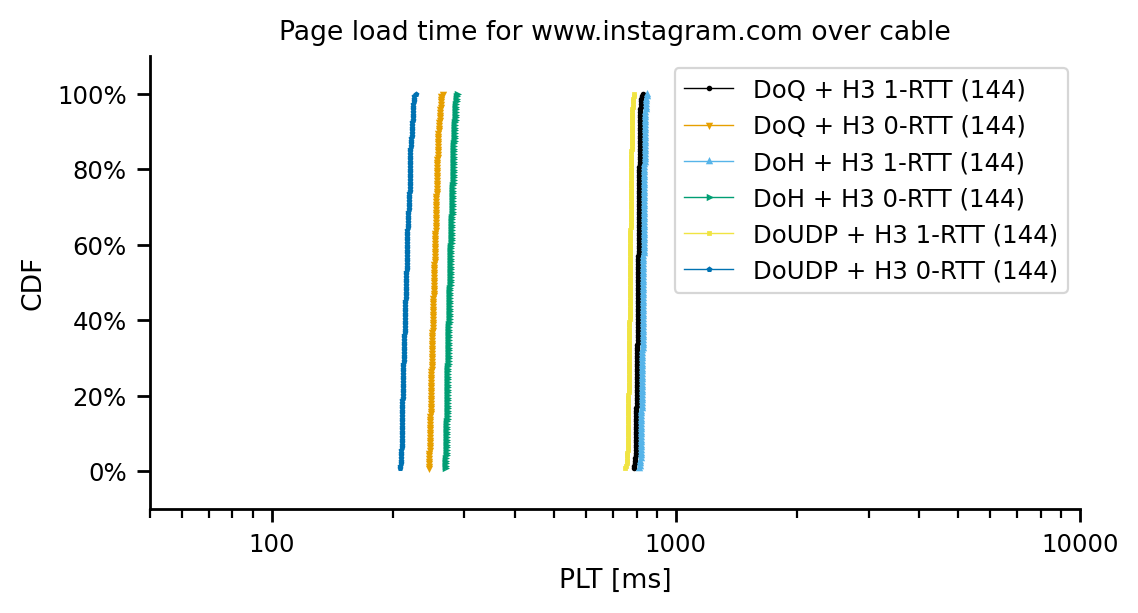

fiber
count     74.000000
mean     145.441953
std        3.758410
min      136.616964
10%      141.667106
20%      143.077540
25%      143.576237
30%      143.815035
40%      144.453107
50%      145.077184
60%      145.456018
70%      146.574140
75%      146.761364
80%      147.137599
90%      152.399116
100%     154.359205
max      154.359205
Name: full_plt, dtype: float64
count    74.000000
mean     70.074385
std       1.339148
min      66.609658
10%      68.395937
20%      69.314364
25%      69.347217
30%      69.607503
40%      69.760773
50%      70.042077
60%      70.187226
70%      70.463427
75%      71.048949
80%      71.161296
90%      71.731360
100%     73.259615
max      73.259615
Name: full_plt, dtype: float64
count     74.000000
mean     159.506119
std        3.672266
min      151.958915
10%      155.982166
20%      157.165765
25%      157.314579
30%      157.586971
40%      158.478414
50%      158.941277
60%      159.704088
70%      160.382074
75%      160.807263
80%      

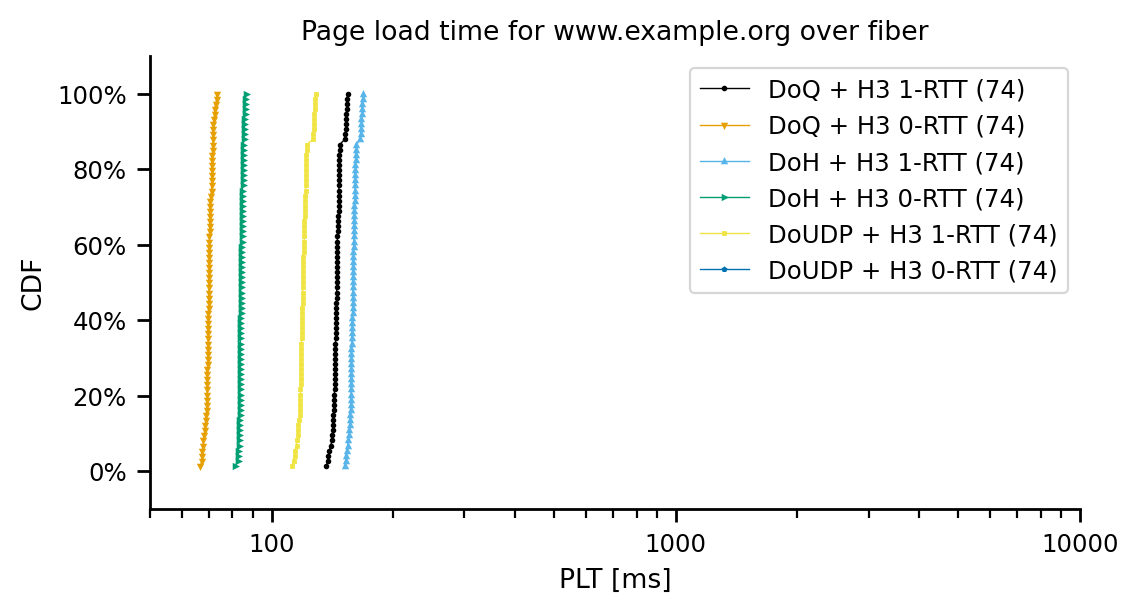

count     73.000000
mean     354.398539
std       21.413832
min      301.370024
10%      323.867266
20%      335.727287
25%      344.169672
30%      348.321894
40%      352.540300
50%      357.466070
60%      364.630946
70%      367.460574
75%      369.638528
80%      372.905566
90%      376.998182
100%     394.902579
max      394.902579
Name: full_plt, dtype: float64
count     73.000000
mean     114.249224
std       23.674076
min       91.234281
10%       94.665595
20%       95.677589
25%       96.150039
30%       96.565412
40%       97.569506
50%       98.859917
60%      102.857740
70%      133.914764
75%      135.196517
80%      141.903675
90%      147.722993
100%     171.838528
max      171.838528
Name: full_plt, dtype: float64
count     73.000000
mean     368.186513
std       21.394895
min      312.109130
10%      339.336835
20%      350.177177
25%      358.213060
30%      362.120549
40%      365.876462
50%      372.377000
60%      378.278189
70%      381.672388
75%      383.06016

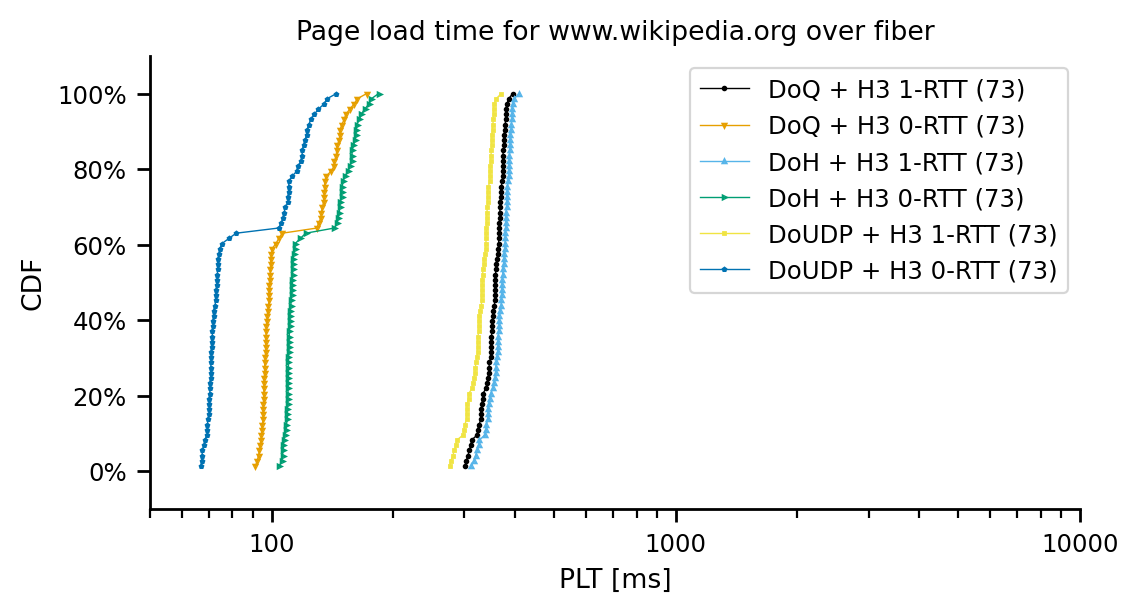

count    144.000000
mean     880.514363
std        7.864385
min      861.352487
10%      871.582705
20%      873.213985
25%      874.350193
30%      875.275312
40%      877.992849
50%      879.905571
60%      882.438164
70%      885.362641
75%      887.058588
80%      887.921915
90%      890.449106
100%     901.644991
max      901.644991
Name: full_plt, dtype: float64
count    144.000000
mean     212.279641
std        5.168922
min      201.858687
10%      206.380203
20%      207.865198
25%      208.557224
30%      209.110378
40%      210.505436
50%      211.424264
60%      212.903125
70%      214.554636
75%      215.392212
80%      216.061748
90%      219.805800
100%     226.912773
max      226.912773
Name: full_plt, dtype: float64
count    144.000000
mean     894.406229
std        7.742280
min      876.098558
10%      884.645460
20%      887.460462
25%      888.712440
30%      889.521341
40%      891.722095
50%      893.635178
60%      896.520183
70%      899.024631
75%      900.70479

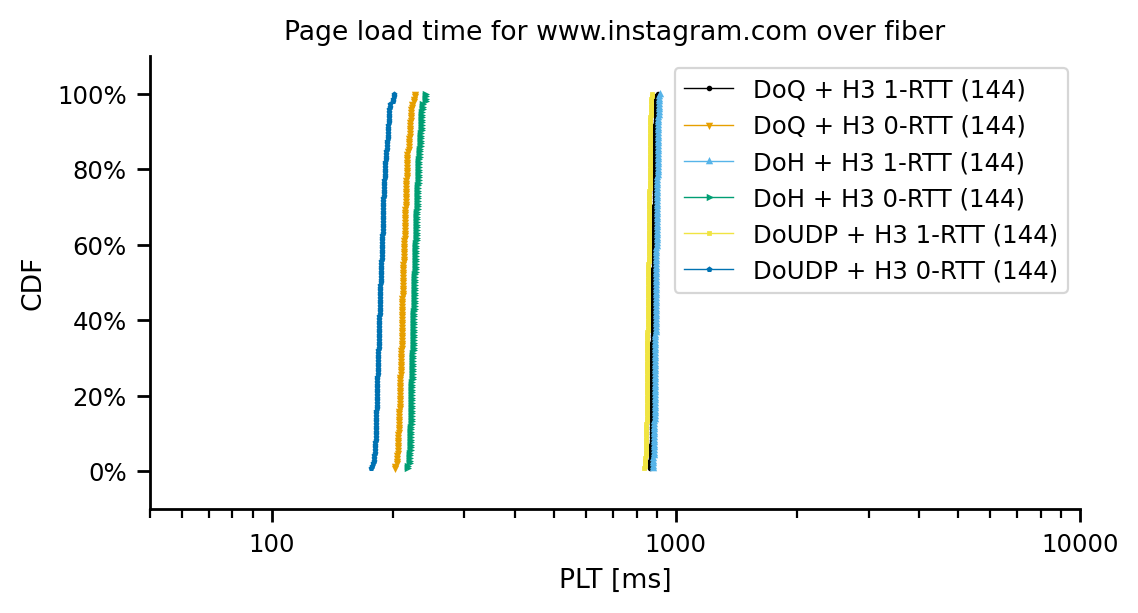

4g
count     73.000000
mean     462.184131
std        3.439601
min      442.345245
10%      459.510332
20%      460.599678
25%      461.019646
30%      461.534550
40%      462.394739
50%      462.818231
60%      463.240198
70%      463.598745
75%      463.814317
80%      464.458626
90%      465.414825
100%     467.517419
max      467.517419
Name: full_plt, dtype: float64
count     73.000000
mean     303.182762
std        1.164499
min      299.313480
10%      301.891962
20%      302.216472
25%      302.417419
30%      302.475195
40%      302.677423
50%      303.309492
60%      303.468906
70%      303.740689
75%      303.841877
80%      304.181813
90%      304.596266
100%     305.839576
max      305.839576
Name: full_plt, dtype: float64
count     73.000000
mean     552.922834
std        3.421531
min      532.959794
10%      550.890997
20%      551.263904
25%      552.051138
30%      552.180351
40%      552.850849
50%      553.407398
60%      553.922354
70%      554.309211
75%      554.45

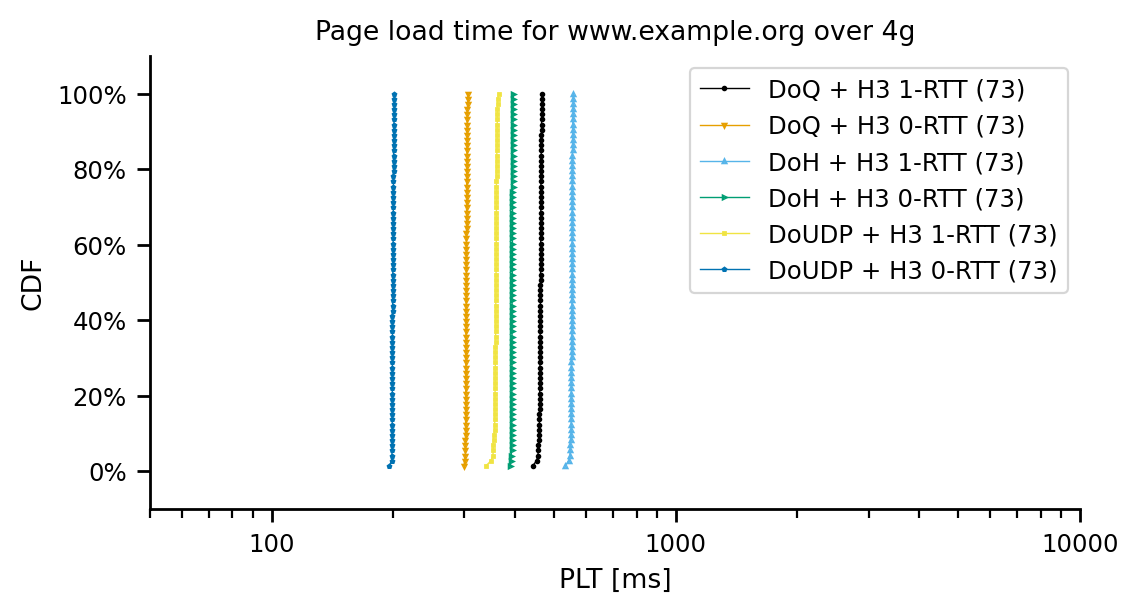

count     73.000000
mean     777.055733
std       32.410875
min      701.183773
10%      728.277799
20%      748.875996
25%      755.337253
30%      767.947044
40%      778.069883
50%      783.316637
60%      791.615789
70%      797.291023
75%      803.487692
80%      807.703210
90%      812.612985
100%     829.386913
max      829.386913
Name: full_plt, dtype: float64
count     73.000000
mean     350.076281
std       26.030037
min      324.300825
10%      327.797142
20%      328.752337
25%      329.392123
30%      329.829591
40%      330.754876
50%      331.940371
60%      339.493365
70%      374.737070
75%      378.194930
80%      381.899474
90%      386.246987
100%     398.270856
max      398.270856
Name: full_plt, dtype: float64
count     73.000000
mean     867.946227
std       32.285898
min      791.419269
10%      818.521975
20%      839.562744
25%      846.331165
30%      859.049125
40%      869.033618
50%      872.898730
60%      882.412855
70%      889.149613
75%      893.87794

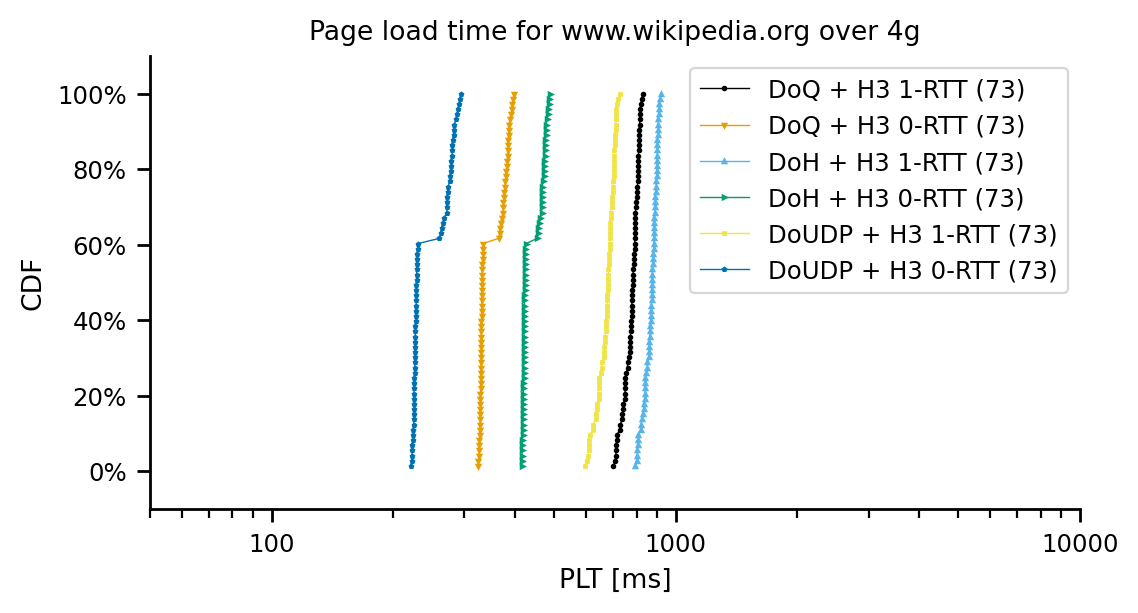

count     144.000000
mean     1891.380045
std         9.958637
min      1868.722399
10%      1880.132791
20%      1882.968037
25%      1884.519179
30%      1886.179714
40%      1888.495631
50%      1890.863306
60%      1893.211051
70%      1895.454670
75%      1896.858500
80%      1897.900812
90%      1902.356875
100%     1942.538672
max      1942.538672
Name: full_plt, dtype: float64
count    144.000000
mean     523.223100
std        4.176598
min      514.592737
10%      518.838726
20%      519.676805
25%      520.015770
30%      520.524674
40%      521.534366
50%      522.338852
60%      523.494331
70%      525.097047
75%      525.745320
80%      526.867870
90%      529.866100
100%     533.215508
max      533.215508
Name: full_plt, dtype: float64
count     144.000000
mean     1982.314455
std        10.118317
min      1958.058034
10%      1971.341734
20%      1973.798332
25%      1975.378608
30%      1977.383452
40%      1979.242967
50%      1981.984189
60%      1984.161923
70%      1

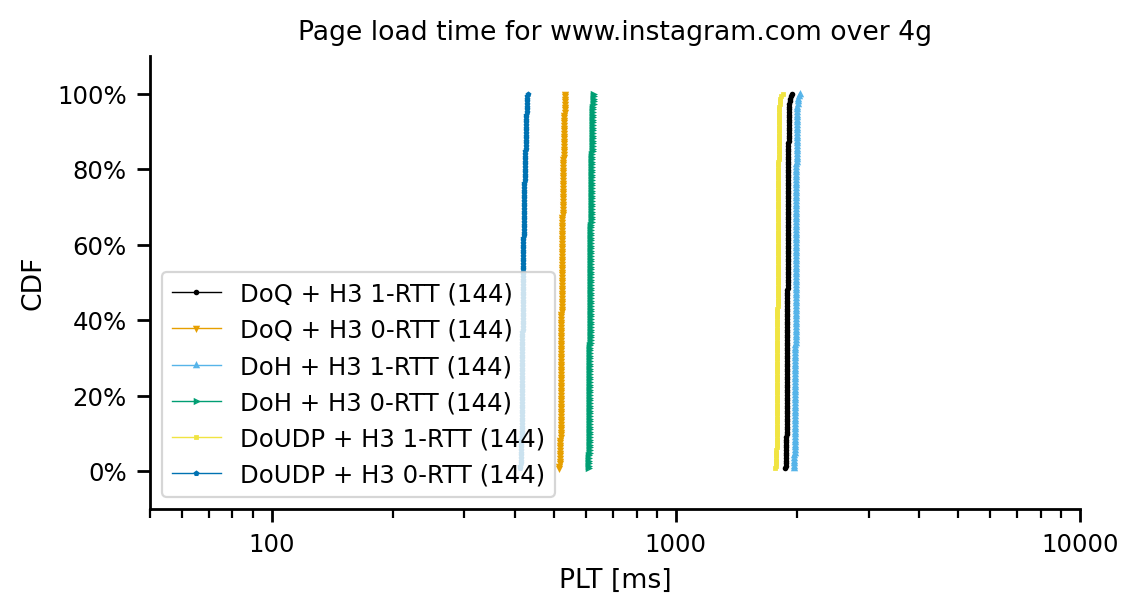

4g-medium
count     73.000000
mean     519.776562
std        3.623099
min      508.035144
10%      515.956344
20%      518.102230
25%      518.274490
30%      518.961561
40%      519.515346
50%      520.161519
60%      520.725066
70%      521.191419
75%      521.433622
80%      522.151478
90%      523.214948
100%     531.854327
max      531.854327
Name: full_plt, dtype: float64
count     73.000000
mean     347.176562
std        1.036440
min      343.752996
10%      346.095271
20%      346.271908
25%      346.401713
30%      346.489643
40%      346.922002
50%      347.285326
60%      347.380851
70%      347.587420
75%      347.798630
80%      348.105077
90%      348.679423
100%     348.964921
max      348.964921
Name: full_plt, dtype: float64
count     73.000000
mean     620.629635
std        3.745590
min      609.436059
10%      615.024494
20%      618.562175
25%      618.963488
30%      619.623940
40%      620.367143
50%      621.028661
60%      621.809792
70%      622.447092
75%     

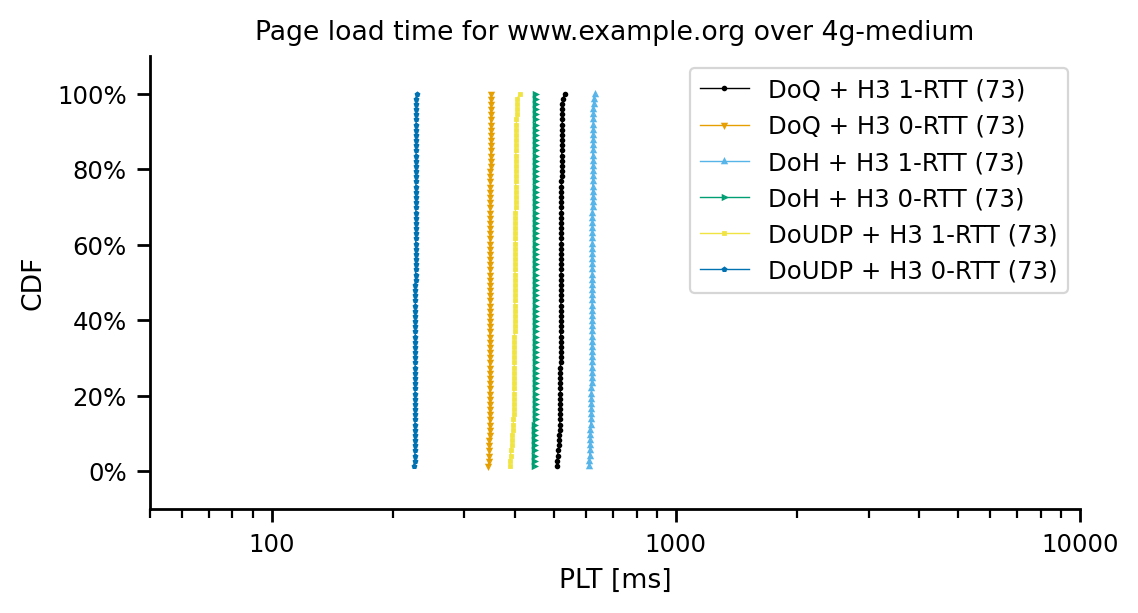

count     73.000000
mean     851.601270
std       28.214460
min      782.793639
10%      817.313409
20%      833.653552
25%      836.904140
30%      838.983197
40%      847.566497
50%      853.225275
60%      861.490279
70%      865.611110
75%      870.582232
80%      878.026376
90%      883.565887
100%     916.901389
max      916.901389
Name: full_plt, dtype: float64
count     73.000000
mean     388.434147
std       24.412855
min      364.202420
10%      370.385243
20%      371.330033
25%      371.969136
30%      372.387527
40%      373.509275
50%      374.249869
60%      375.111597
70%      393.705013
75%      416.288542
80%      420.221769
90%      425.763044
100%     443.393293
max      443.393293
Name: full_plt, dtype: float64
count      73.000000
mean      952.835528
std        28.394891
min       883.310602
10%       918.477407
20%       935.008455
25%       938.594315
30%       940.104004
40%       947.584714
50%       952.841436
60%       963.082876
70%       967.300726
75%   

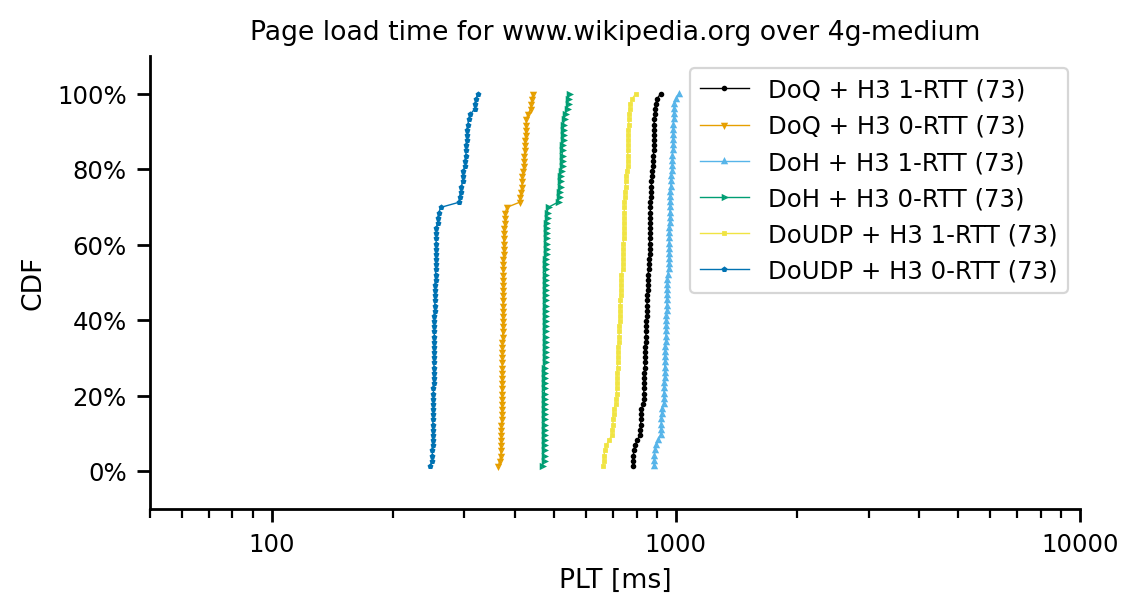

count     144.000000
mean     2622.867002
std         9.555775
min      2599.816920
10%      2610.775255
20%      2614.812558
25%      2615.731958
30%      2618.745708
40%      2620.334634
50%      2622.919848
60%      2625.307083
70%      2627.210358
75%      2630.240333
80%      2631.208382
90%      2635.692165
100%     2645.803197
max      2645.803197
Name: full_plt, dtype: float64
count    144.000000
mean     586.121863
std        5.045870
min      575.878396
10%      580.450008
20%      582.099428
25%      582.650742
30%      583.021115
40%      583.818157
50%      585.013923
60%      586.287882
70%      588.681534
75%      589.917858
80%      591.067440
90%      592.751847
100%     605.123542
max      605.123542
Name: full_plt, dtype: float64
count     144.000000
mean     2723.930576
std         9.600677
min      2700.645313
10%      2710.720054
20%      2715.411498
25%      2717.258329
30%      2719.210515
40%      2721.242450
50%      2724.235885
60%      2726.479393
70%      2

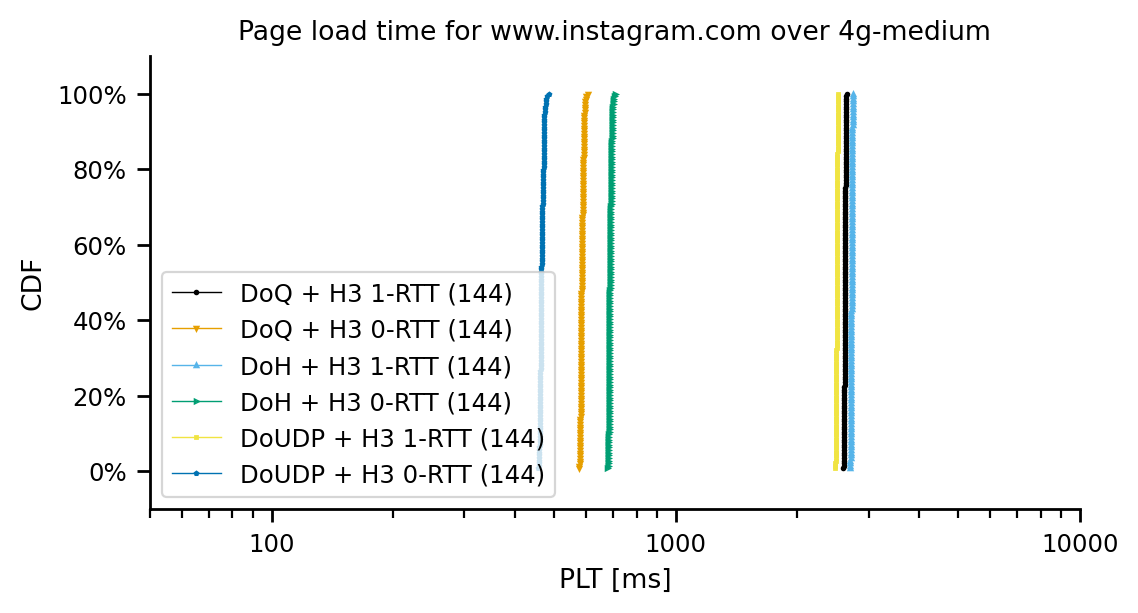

In [135]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_plt', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_plt']) == 0:
                    continue
                print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_plt'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('Page load time for '+website+' over '+access_technology)

        ax.set_xlabel('PLT [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [136]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].full_plt.describe(percentiles=[0.5, 0.6, 0.65])

count     73.000000
mean     241.047664
std       25.593359
min      217.509104
50%      223.363236
60%      225.175464
65%      251.855031
max      288.367474
Name: full_plt, dtype: float64

In [167]:
df_dns_and_h3.timestamp

0       2022-06-08_15_01_00
1       2022-06-08_15_01_00
2       2022-06-08_15_01_00
3       2022-06-08_15_01_00
4       2022-06-08_15_01_00
               ...         
8713    2022-06-09_13_35_38
8714    2022-06-09_13_35_38
8715    2022-06-09_13_35_38
8716    2022-06-09_13_35_38
8717    2022-06-09_13_35_38
Name: timestamp, Length: 8718, dtype: object

In [168]:
df_dns_and_h3.timestamp = pd.to_datetime(df_dns_and_h3.timestamp, format="%Y-%m-%d_%H_%M_%S")

count     47.000000
mean      98.142553
std        2.178925
min       93.200000
25%       96.900000
50%       97.800000
75%       99.150000
max      105.800000
Name: loadEventStart, dtype: float64
count     47.000000
mean     124.358936
std        0.801917
min      120.563236
25%      124.039527
50%      124.269868
75%      124.710228
max      126.024921
Name: elapsed, dtype: float64


<AxesSubplot:xlabel='timestamp'>

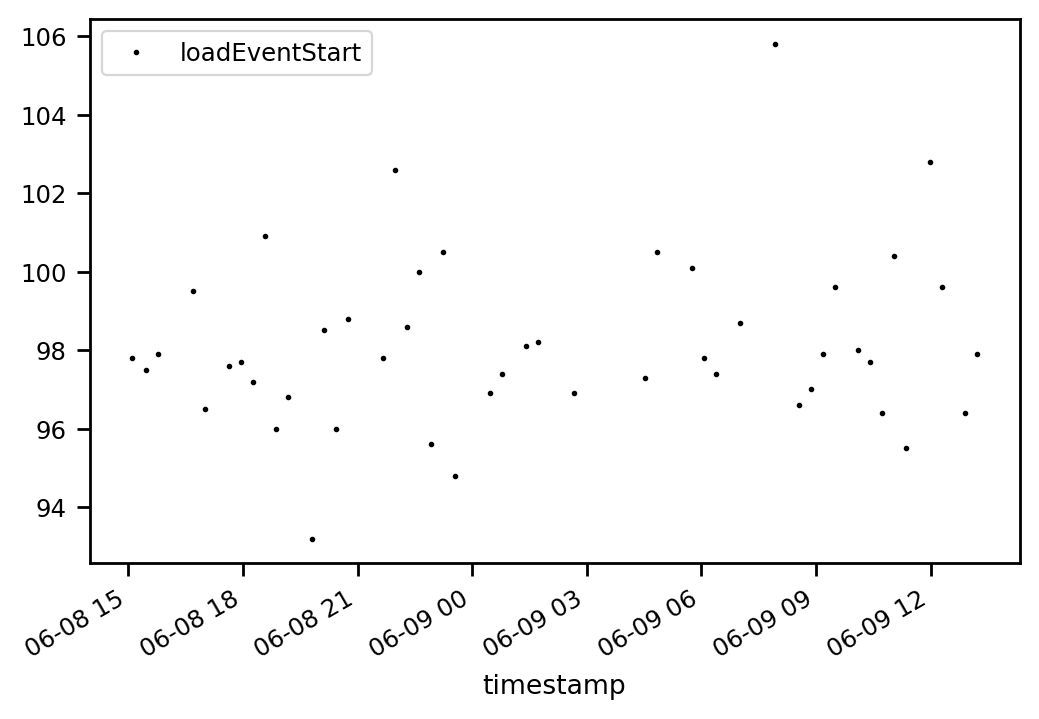

In [183]:
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt < 250)].loadEventStart.describe())
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt < 250)].elapsed.describe())
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt < 250)].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

count     26.000000
mean     150.050000
std        7.820038
min      132.900000
25%      148.350000
50%      150.500000
75%      152.775000
max      164.200000
Name: loadEventStart, dtype: float64
count     26.000000
mean     124.523440
std        0.562622
min      123.591799
25%      124.170253
50%      124.342074
75%      124.806637
max      126.002143
Name: elapsed, dtype: float64


<AxesSubplot:xlabel='timestamp'>

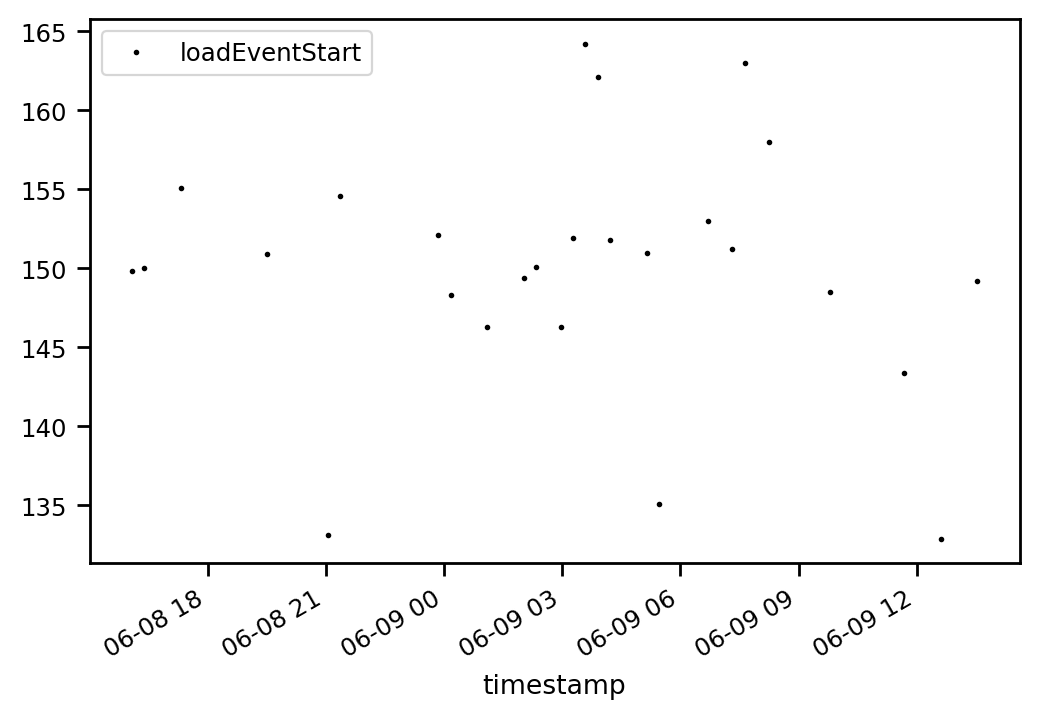

In [184]:
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt >= 250)].loadEventStart.describe())
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt >= 250)].elapsed.describe())
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt >= 250)].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

<AxesSubplot:xlabel='timestamp'>

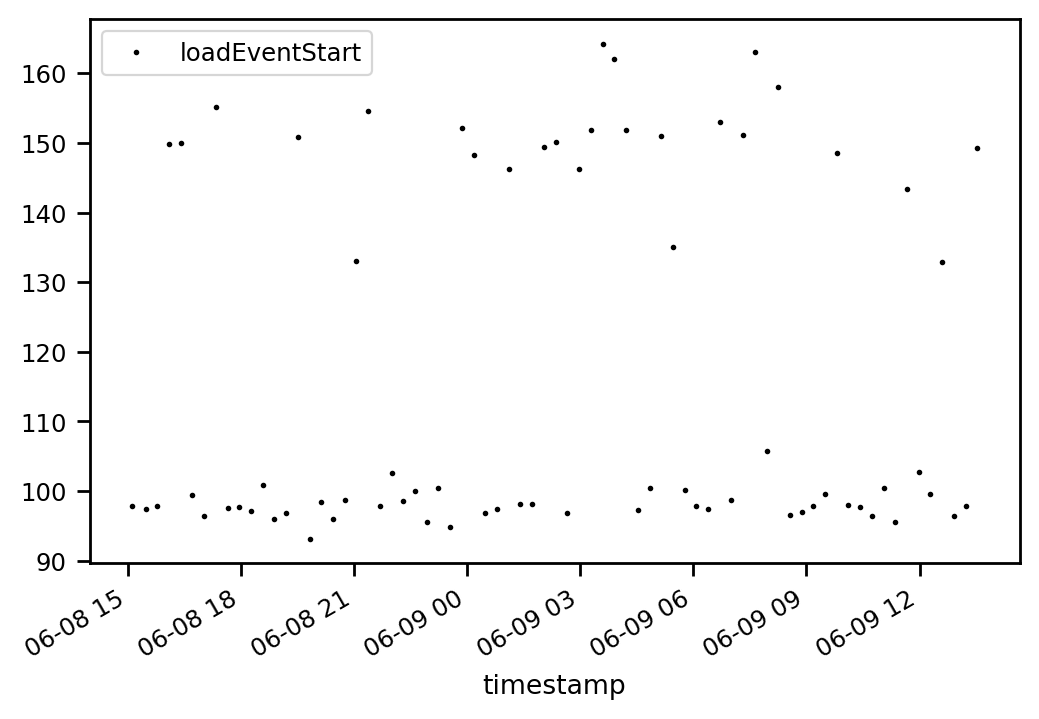

In [185]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

<AxesSubplot:xlabel='timestamp'>

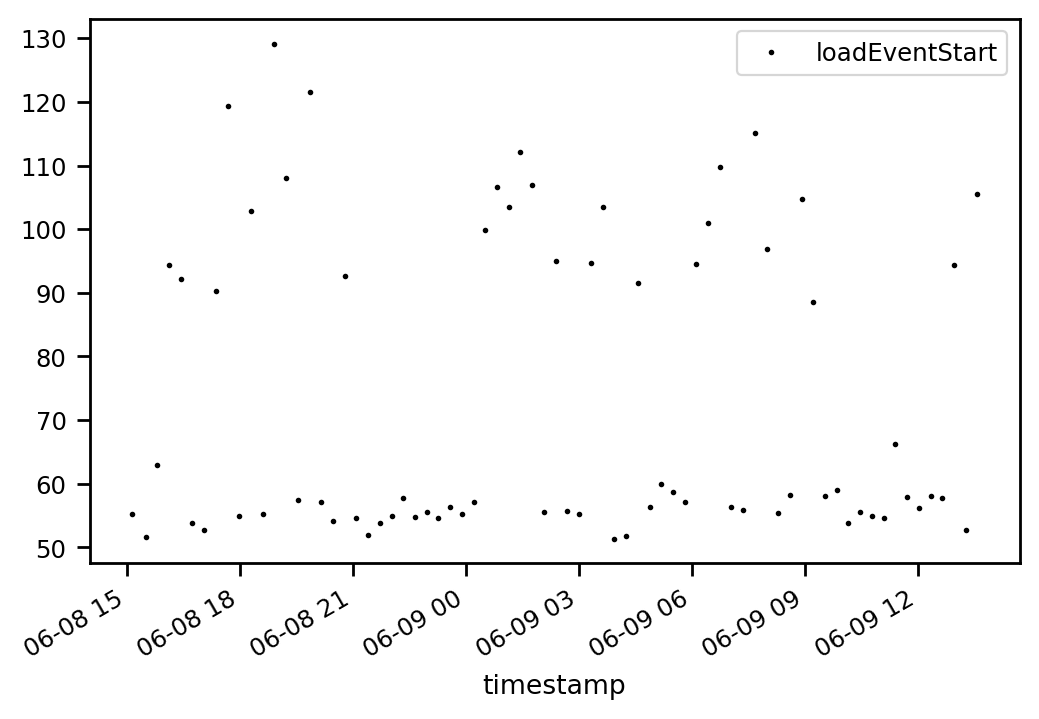

In [186]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'fiber') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

<AxesSubplot:xlabel='timestamp'>

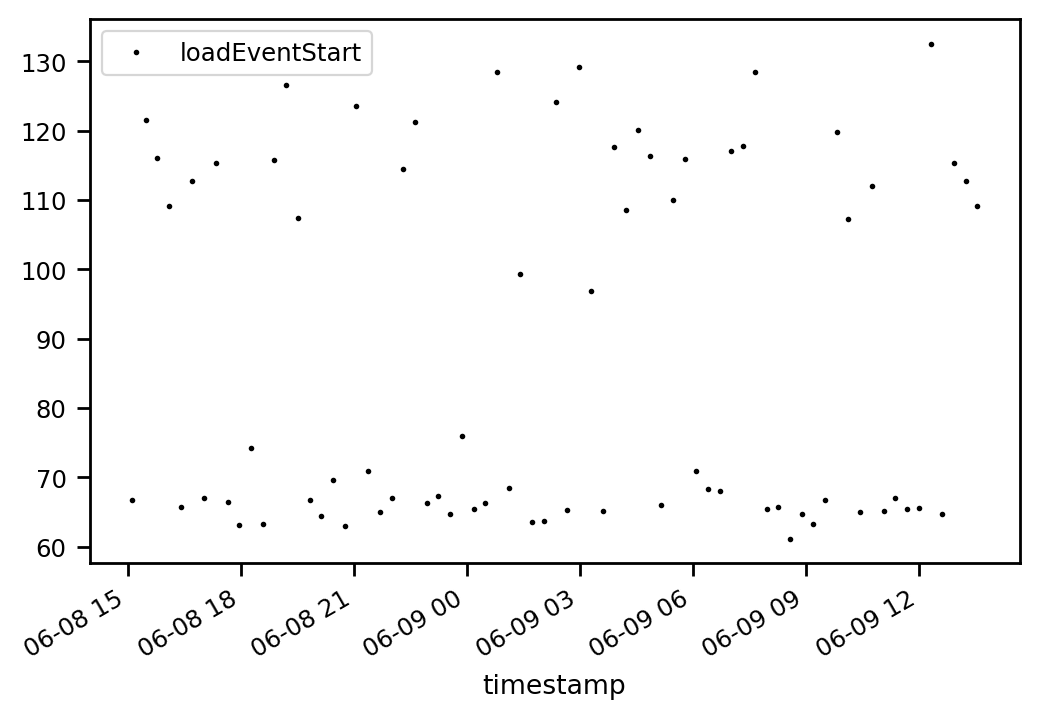

In [187]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'cable') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

<AxesSubplot:xlabel='timestamp'>

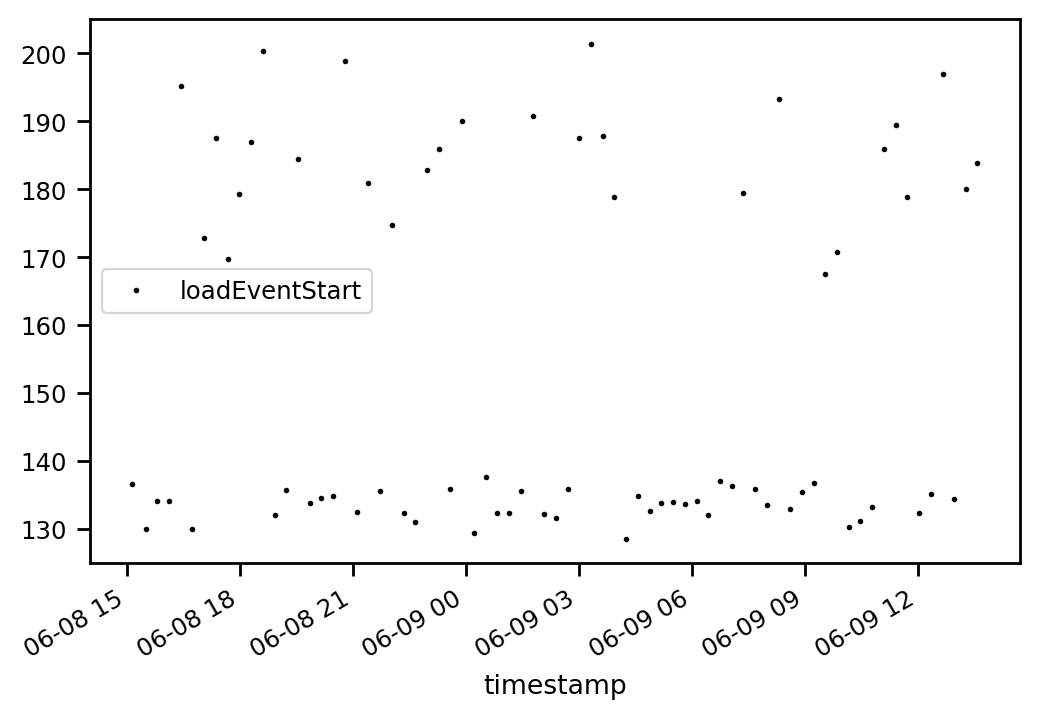

In [188]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == '4g') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

<AxesSubplot:xlabel='timestamp'>

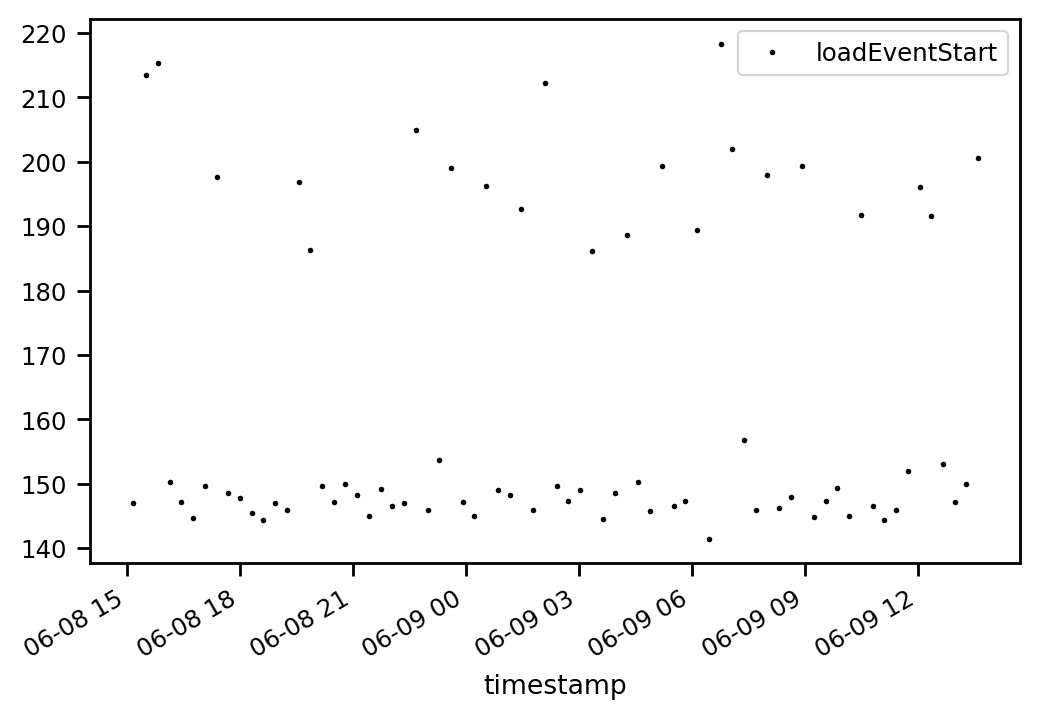

In [189]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == '4g-medium') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

dsl
count     74.000000
mean     317.802733
std        4.757154
min      309.990735
10%      313.233112
20%      314.406780
25%      314.914221
30%      315.517529
40%      316.288776
50%      316.828303
60%      317.329602
70%      318.086893
75%      318.441608
80%      318.839246
90%      327.365591
100%     331.241103
max      331.241103
Name: full_fcp, dtype: float64
count     74.000000
mean     207.428409
std        3.475473
min      201.043688
10%      202.490955
20%      203.425024
25%      203.844308
30%      204.711034
40%      207.083940
50%      208.596441
60%      209.050503
70%      209.797865
75%      210.097176
80%      210.248707
90%      211.588917
100%     213.341515
max      213.341515
Name: full_fcp, dtype: float64
count     74.000000
mean     341.991452
std        4.665142
min      334.111946
10%      337.690225
20%      339.285445
25%      339.495479
30%      339.880098
40%      340.420873
50%      341.048939
60%      341.433829
70%      342.126022
75%      342.4

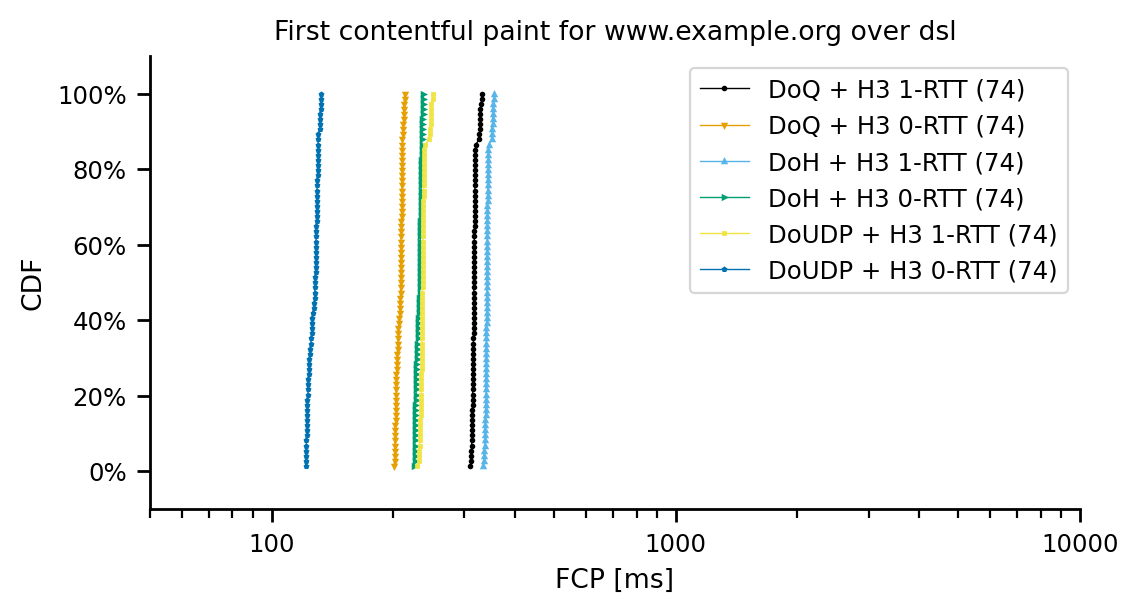

count     73.000000
mean     437.690129
std       41.854974
min      376.620027
10%      406.544866
20%      409.891764
25%      411.502143
30%      412.683360
40%      415.034119
50%      421.331360
60%      424.783944
70%      432.615447
75%      438.355941
80%      493.528227
90%      510.309574
100%     542.952879
max      542.952879
Name: full_fcp, dtype: float64
count     73.000000
mean     216.207938
std       16.068312
min      208.701112
10%      210.212017
20%      210.952978
25%      211.086949
30%      211.216771
40%      211.635445
50%      211.833363
60%      212.394016
70%      212.688569
75%      212.963468
80%      213.254178
90%      215.082104
100%     285.431360
max      285.431360
Name: full_fcp, dtype: float64
count     73.000000
mean     461.825943
std       41.858512
min      400.826634
10%      429.749653
20%      433.574229
25%      435.328960
30%      437.109186
40%      439.207635
50%      445.797606
60%      449.256870
70%      455.749643
75%      462.00088

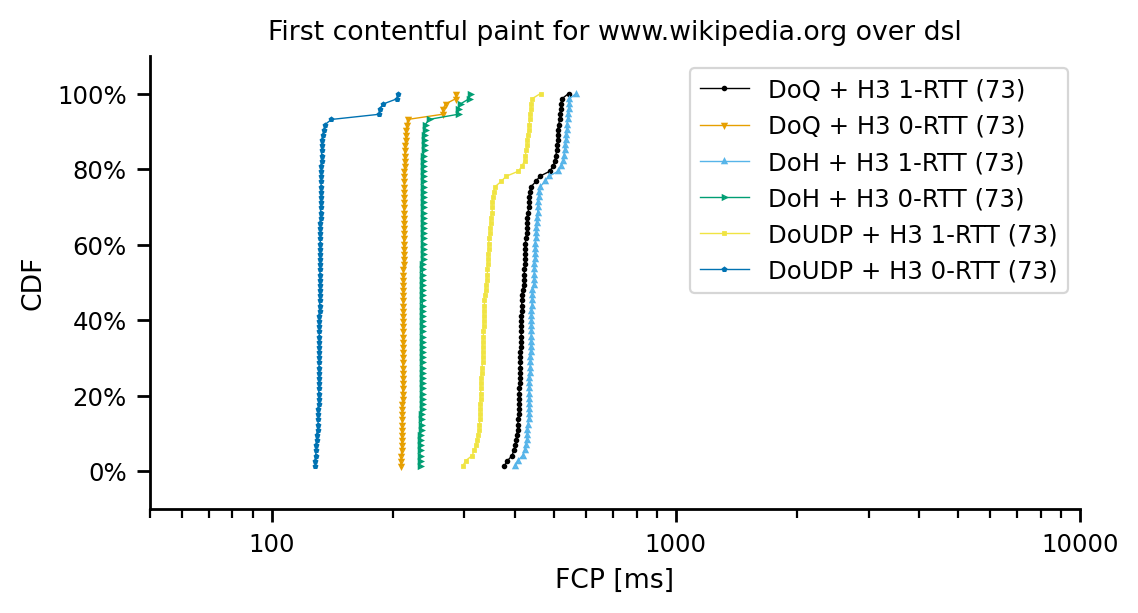

count    144.000000
mean     324.915861
std        7.604027
min      308.193798
10%      315.867075
20%      319.008068
25%      320.004650
30%      320.790010
40%      322.309556
50%      323.711127
60%      325.383457
70%      327.637363
75%      328.232018
80%      329.730394
90%      335.429044
100%     348.177519
max      348.177519
Name: full_fcp, dtype: float64
count    144.000000
mean     227.342249
std        7.828659
min      198.449545
10%      223.360596
20%      225.314704
25%      226.118822
30%      226.369723
40%      227.078407
50%      227.654713
60%      228.364337
70%      229.773711
75%      230.714501
80%      231.880112
90%      235.029661
100%     243.930432
max      243.930432
Name: full_fcp, dtype: float64
count    144.000000
mean     349.129781
std        7.727640
min      332.515602
10%      340.458772
20%      343.120852
25%      344.476864
30%      345.058529
40%      346.617854
50%      348.230406
60%      349.502097
70%      351.582138
75%      352.60082

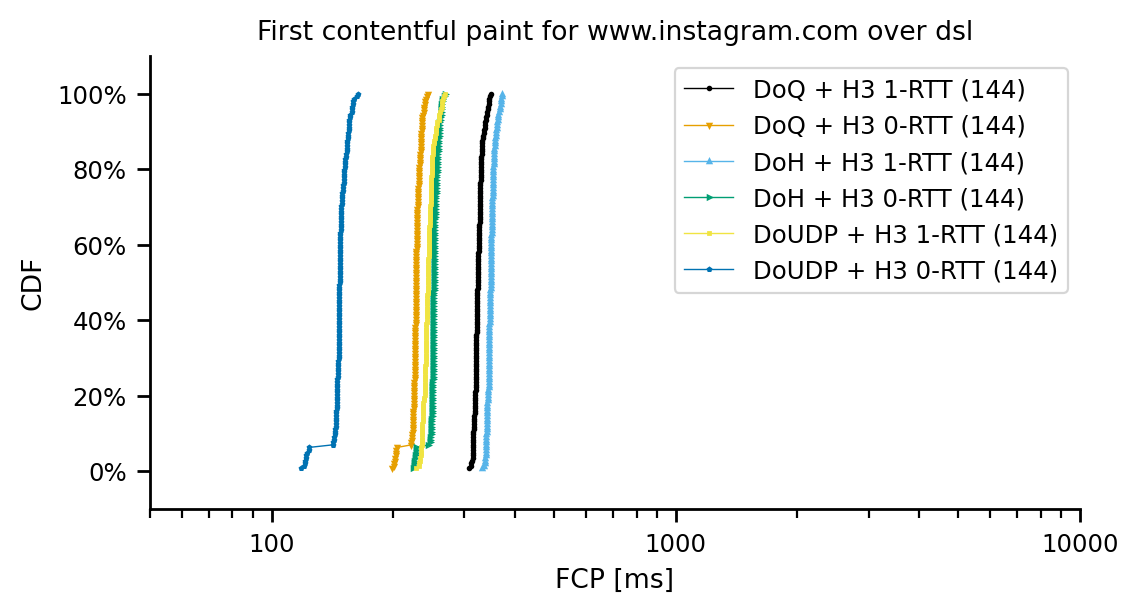

cable
count     74.000000
mean     200.953295
std        2.152371
min      195.041657
10%      197.250023
20%      199.735060
25%      200.066122
30%      200.202306
40%      200.731758
50%      201.103891
60%      201.695463
70%      202.010446
75%      202.253365
80%      202.605202
90%      203.196919
100%     205.609784
max      205.609784
Name: full_fcp, dtype: float64
count     74.000000
mean     113.881673
std        3.678301
min      106.480114
10%      109.144877
20%      109.705613
25%      110.195819
30%      111.058478
40%      112.936278
50%      114.267206
60%      115.439726
70%      116.498018
75%      117.078884
80%      117.339614
90%      118.567367
100%     120.736891
max      120.736891
Name: full_fcp, dtype: float64
count     74.000000
mean     224.419841
std        2.223287
min      218.191765
10%      221.143388
20%      222.564464
25%      223.736926
30%      223.828315
40%      224.240180
50%      224.974853
60%      225.223326
70%      225.710132
75%      225

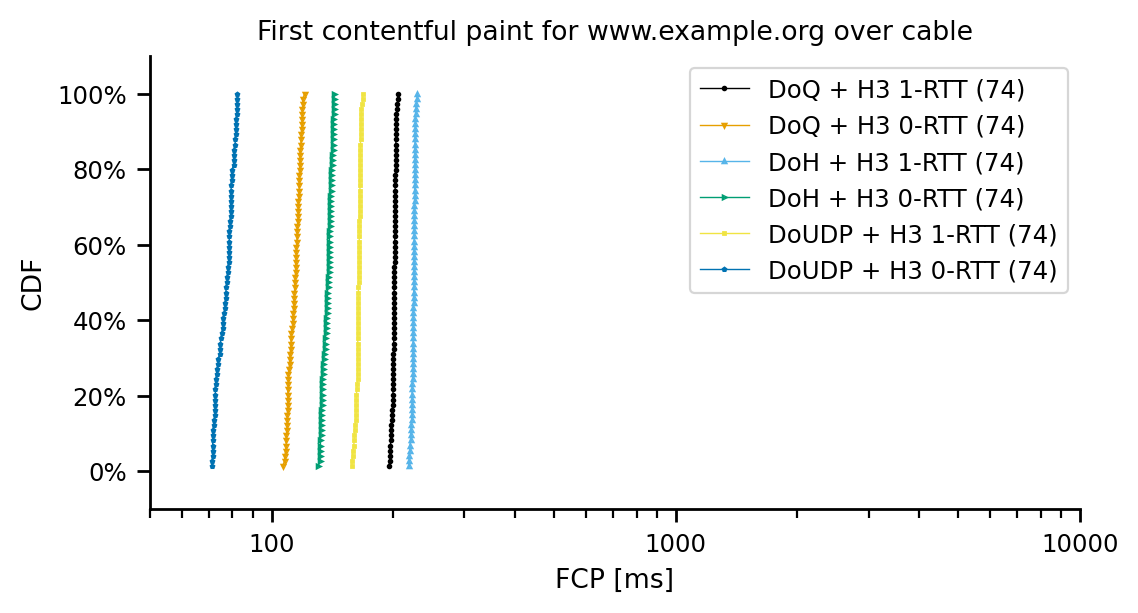

count     73.000000
mean     384.530329
std       46.312811
min      246.732206
10%      297.987061
20%      370.058201
25%      377.129824
30%      380.305412
40%      391.732543
50%      402.368278
60%      407.518405
70%      409.538722
75%      411.274288
80%      413.793357
90%      421.913036
100%     433.753348
max      433.753348
Name: full_fcp, dtype: float64
count     73.000000
mean     123.356357
std       16.693340
min      114.395472
10%      116.371550
20%      117.441010
25%      117.545124
30%      117.655009
40%      117.977762
50%      118.512470
60%      118.938505
70%      119.480663
75%      119.994386
80%      120.799918
90%      122.089677
100%     186.289126
max      186.289126
Name: full_fcp, dtype: float64
count     73.000000
mean     407.949452
std       46.498591
min      270.033408
10%      321.309413
20%      393.436653
25%      401.252993
30%      403.677115
40%      415.816747
50%      425.533289
60%      431.091171
70%      432.779556
75%      434.19475

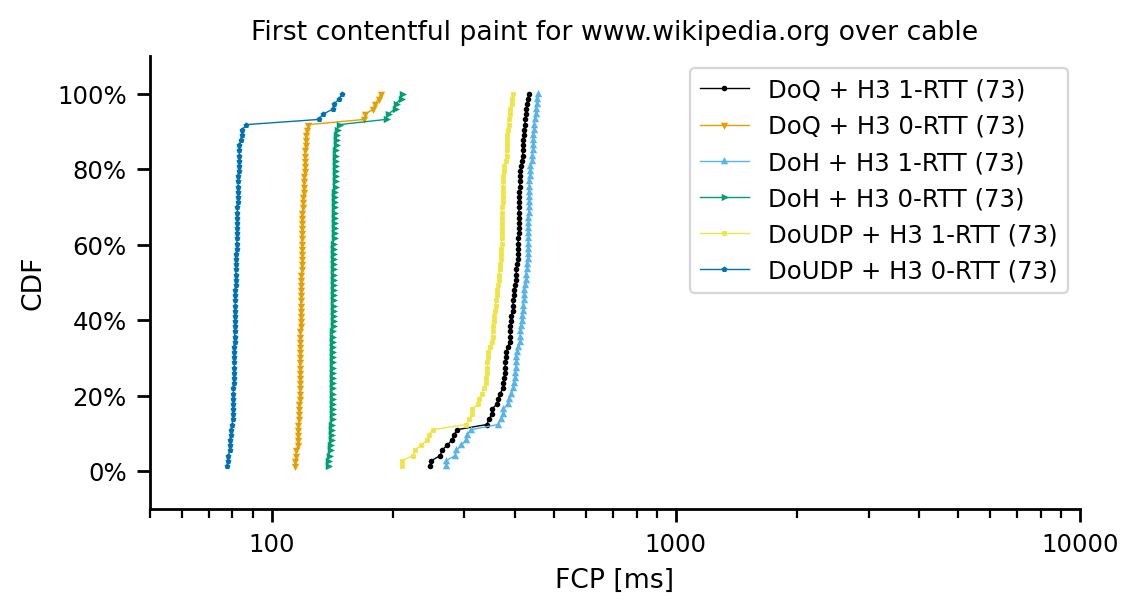

count    144.000000
mean     209.237615
std        6.133363
min      194.034909
10%      201.571224
20%      203.630708
25%      204.422187
30%      205.615831
40%      207.600842
50%      209.756894
60%      211.148122
70%      213.109931
75%      213.915870
80%      214.797117
90%      216.513839
100%     222.677595
max      222.677595
Name: full_fcp, dtype: float64
count    144.000000
mean     144.364699
std        4.862668
min      118.881805
10%      140.407237
20%      141.600726
25%      141.765699
30%      142.045894
40%      142.501674
50%      143.209266
60%      144.610584
70%      146.568837
75%      147.267079
80%      148.132485
90%      150.982294
100%     156.128640
max      156.128640
Name: full_fcp, dtype: float64
count    144.000000
mean     232.785535
std        6.129963
min      217.106799
10%      224.630817
20%      227.212635
25%      227.783191
30%      228.951639
40%      231.440232
50%      233.592841
60%      235.026869
70%      236.597810
75%      237.86009

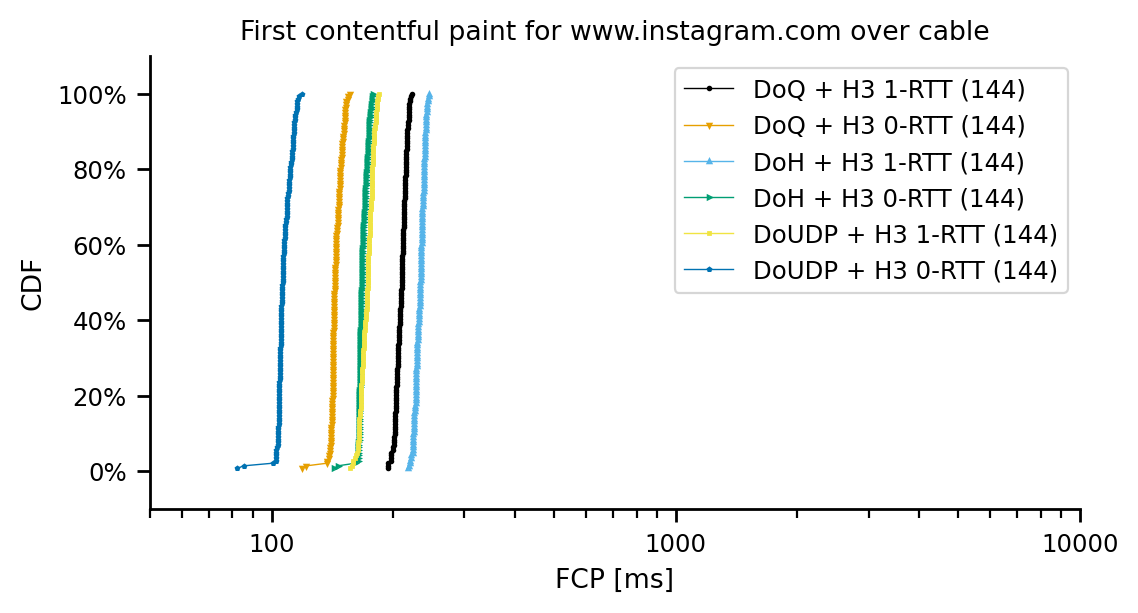

fiber
count     74.000000
mean     157.106818
std        2.432456
min      148.816964
10%      154.367361
20%      155.434108
25%      155.874821
30%      156.348147
40%      156.916504
50%      157.632610
60%      158.277524
70%      158.594360
75%      158.948931
80%      159.076389
90%      159.318124
100%     161.564433
max      161.564433
Name: full_fcp, dtype: float64
count    74.000000
mean     80.152764
std       3.751874
min      72.209090
10%      75.682338
20%      76.381118
25%      76.669822
30%      77.645112
40%      79.489732
50%      80.815548
60%      82.099138
70%      82.611346
75%      82.855009
80%      83.383716
90%      84.716387
100%     86.562603
max      86.562603
Name: full_fcp, dtype: float64
count     74.000000
mean     171.170984
std        2.293655
min      164.658915
10%      168.413454
20%      169.220560
25%      170.016430
30%      170.312706
40%      170.969521
50%      171.467320
60%      171.933410
70%      172.455716
75%      172.796800
80%      

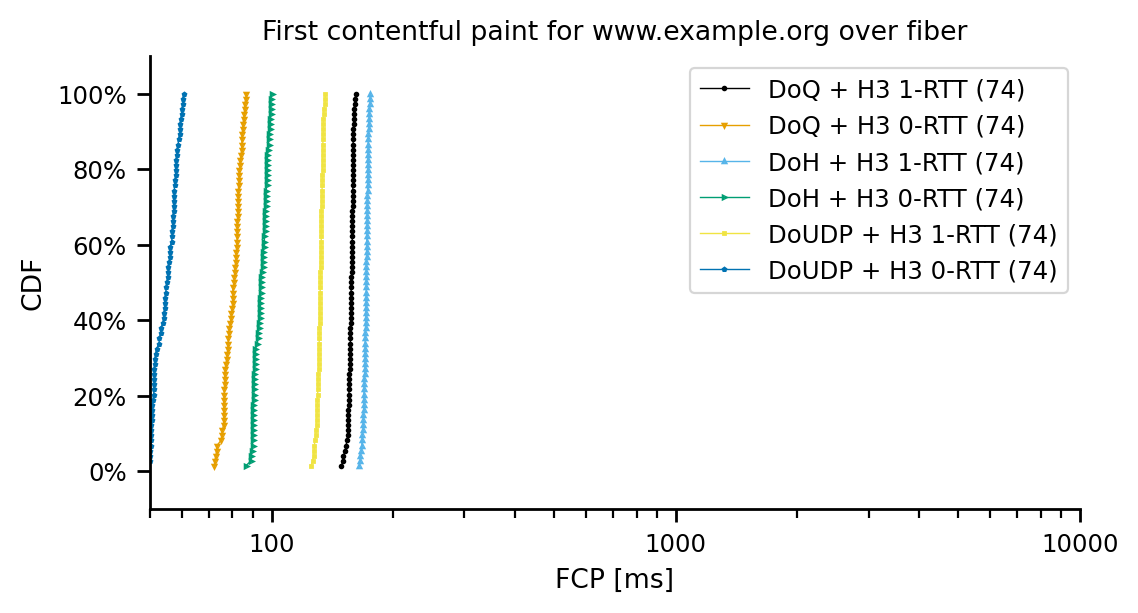

count     73.000000
mean     280.842375
std       69.797328
min      188.020544
10%      205.344695
20%      216.030003
25%      218.769672
30%      221.638033
40%      228.155817
50%      237.927353
60%      326.495633
70%      351.157552
75%      356.956506
80%      359.124802
90%      365.869265
100%     388.202579
max      388.202579
Name: full_fcp, dtype: float64
count     73.000000
mean      99.353334
std       25.027362
min       80.449938
10%       83.948160
20%       84.842840
25%       84.998449
30%       85.212255
40%       85.648589
50%       86.360096
60%       87.435191
70%       90.965184
75%       92.624629
80%      138.223070
90%      143.186774
100%     160.816163
max      160.816163
Name: full_fcp, dtype: float64
count     73.000000
mean     294.630349
std       69.721355
min      201.381429
10%      219.280708
20%      230.144437
25%      232.328176
30%      236.064308
40%      241.988438
50%      252.114670
60%      339.003844
70%      364.989177
75%      370.41996

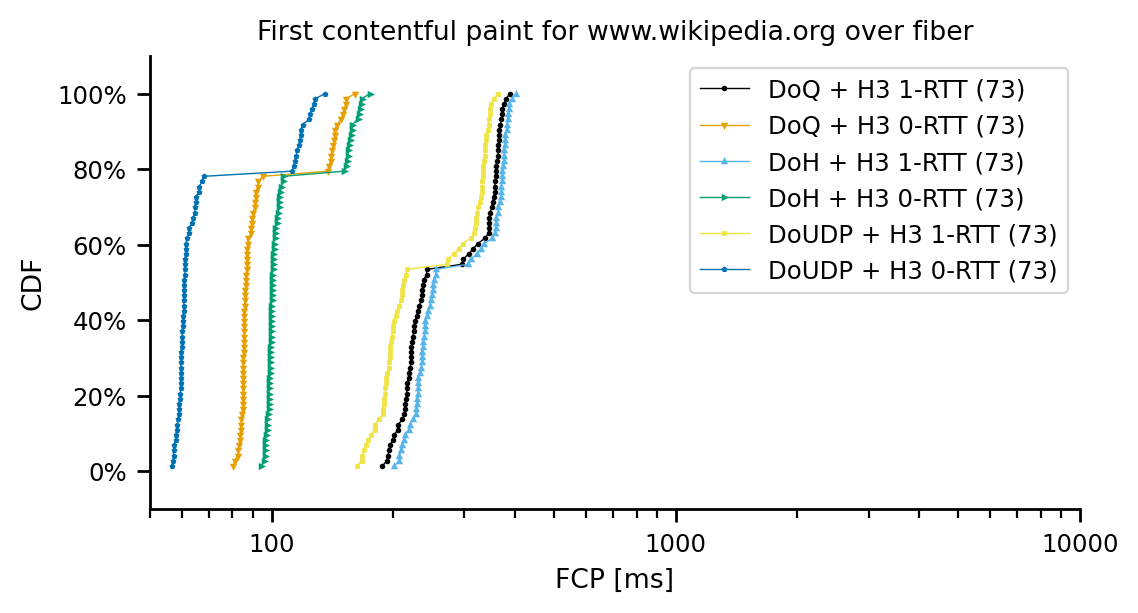

count    144.000000
mean     160.856030
std        7.438344
min      148.855106
10%      152.307722
20%      154.295633
25%      155.017454
30%      155.515397
40%      156.887777
50%      158.874548
60%      161.766650
70%      165.574921
75%      167.158298
80%      168.944806
90%      171.775196
100%     177.952500
max      177.952500
Name: full_fcp, dtype: float64
count    144.000000
mean     112.376169
std        4.080552
min      104.752487
10%      108.296247
20%      109.046481
25%      109.427044
30%      109.723219
40%      110.233548
50%      110.847432
60%      112.368011
70%      113.640327
75%      114.257365
80%      116.408921
90%      118.997370
100%     123.694015
max      123.694015
Name: full_fcp, dtype: float64
count    144.000000
mean     174.747896
std        7.285915
min      161.655858
10%      166.371085
20%      168.449119
25%      168.938686
30%      169.734745
40%      170.750472
50%      173.205007
60%      175.175778
70%      179.265588
75%      180.92948

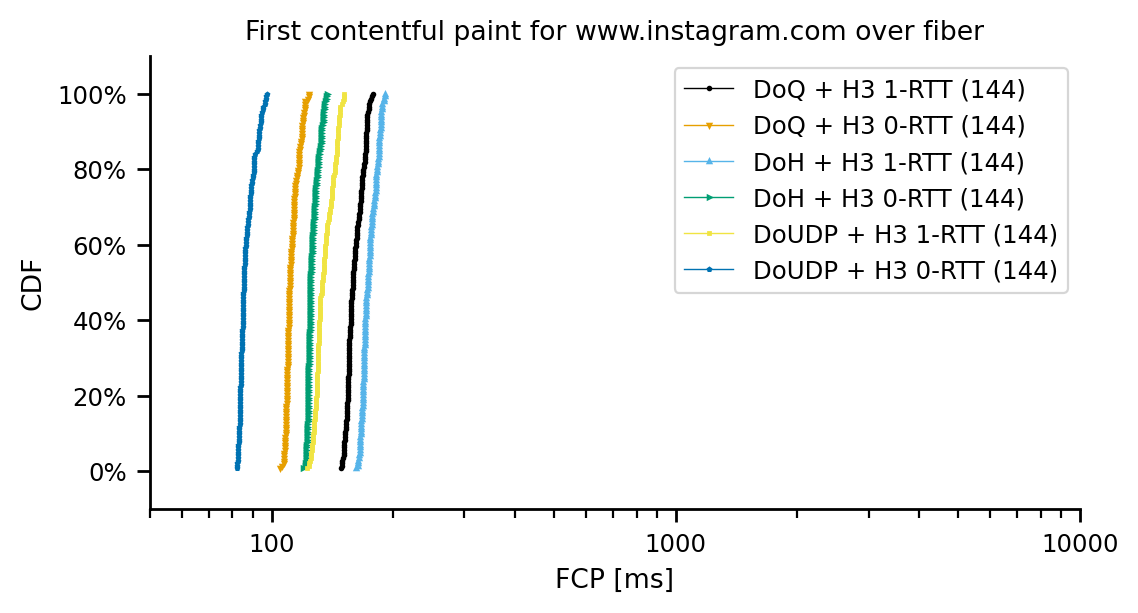

4g
count     73.000000
mean     468.280022
std        2.933839
min      454.545245
10%      465.506472
20%      466.557375
25%      466.689180
30%      467.000991
40%      467.901676
50%      468.279943
60%      468.817739
70%      469.826776
75%      470.224212
80%      470.697774
90%      471.412659
100%     473.480554
max      473.480554
Name: full_fcp, dtype: float64
count     73.000000
mean     312.553994
std        3.406103
min      307.006930
10%      308.588043
20%      309.271482
25%      309.643495
30%      310.087470
40%      310.916346
50%      311.964953
60%      313.530726
70%      314.731469
75%      315.150052
80%      315.601653
90%      317.321515
100%     318.945245
max      318.945245
Name: full_fcp, dtype: float64
count     73.000000
mean     559.018724
std        2.921469
min      545.159794
10%      555.956642
20%      557.054142
25%      557.722170
30%      557.971564
40%      558.643694
50%      559.226970
60%      559.376070
70%      560.151240
75%      560.73

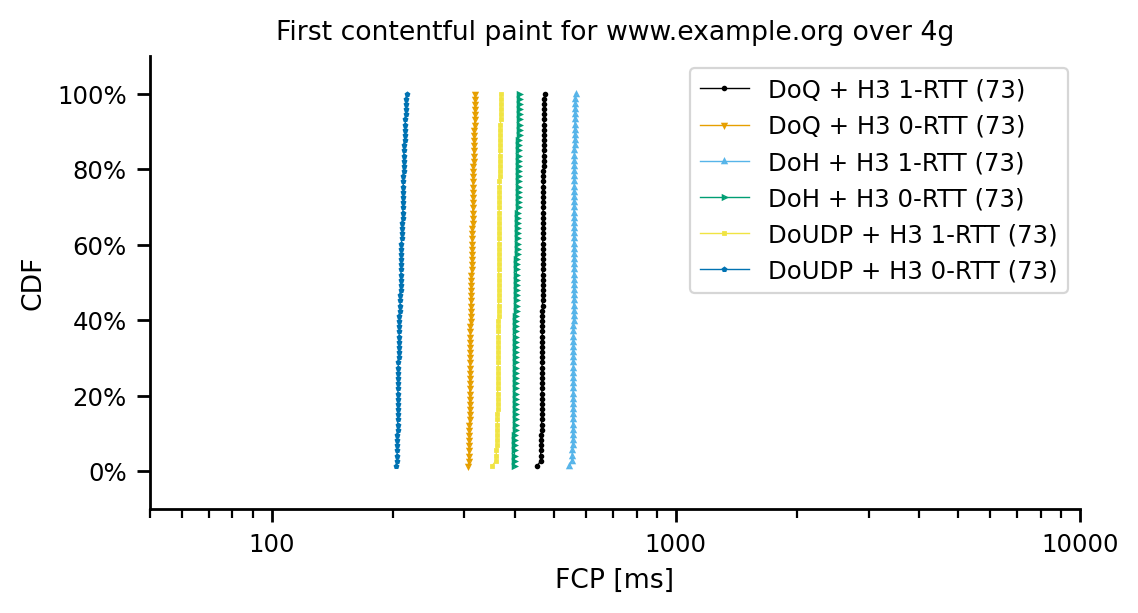

count     73.000000
mean     647.611897
std       43.512762
min      555.505887
10%      576.900671
20%      602.579713
25%      623.802708
30%      628.697340
40%      643.926187
50%      657.045443
60%      667.016013
70%      680.547242
75%      685.070856
80%      688.889355
90%      695.773767
100%     713.486913
max      713.486913
Name: full_fcp, dtype: float64
count     73.000000
mean     326.747513
std       22.013557
min      313.500825
10%      316.684976
20%      317.256429
25%      317.470480
30%      317.551841
40%      317.794166
50%      318.092123
60%      318.653985
70%      319.144410
75%      319.888148
80%      320.785724
90%      374.921299
100%     391.729109
max      391.729109
Name: full_fcp, dtype: float64
count     73.000000
mean     738.502391
std       43.377915
min      646.827626
10%      667.730883
20%      693.680299
25%      713.724224
30%      719.175660
40%      734.997896
50%      747.739805
60%      758.061257
70%      771.516573
75%      777.21653

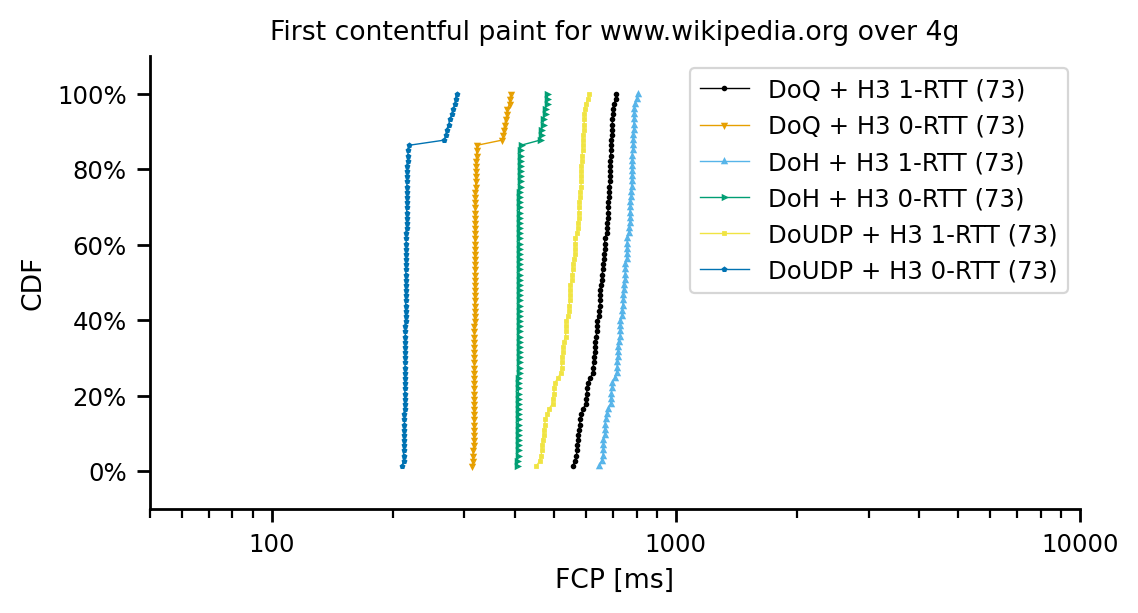

count    144.000000
mean     476.357128
std        6.040133
min      465.987979
10%      469.153466
20%      470.515232
25%      471.391172
30%      472.314524
40%      474.064988
50%      476.519033
60%      478.001721
70%      479.457145
75%      480.565919
80%      481.420691
90%      483.296088
100%     505.150812
max      505.150812
Name: full_fcp, dtype: float64
count    144.000000
mean     344.344628
std        5.608179
min      315.418507
10%      341.633621
20%      342.634604
25%      342.953861
30%      343.187763
40%      343.571361
50%      344.267969
60%      344.840411
70%      345.632742
75%      346.197473
80%      346.687817
90%      349.872406
100%     354.578001
max      354.578001
Name: full_fcp, dtype: float64
count    144.000000
mean     567.291539
std        6.002939
min      555.443742
10%      560.262589
20%      561.531598
25%      562.614468
30%      563.037815
40%      565.335714
50%      567.342126
60%      568.776512
70%      570.490689
75%      571.22387

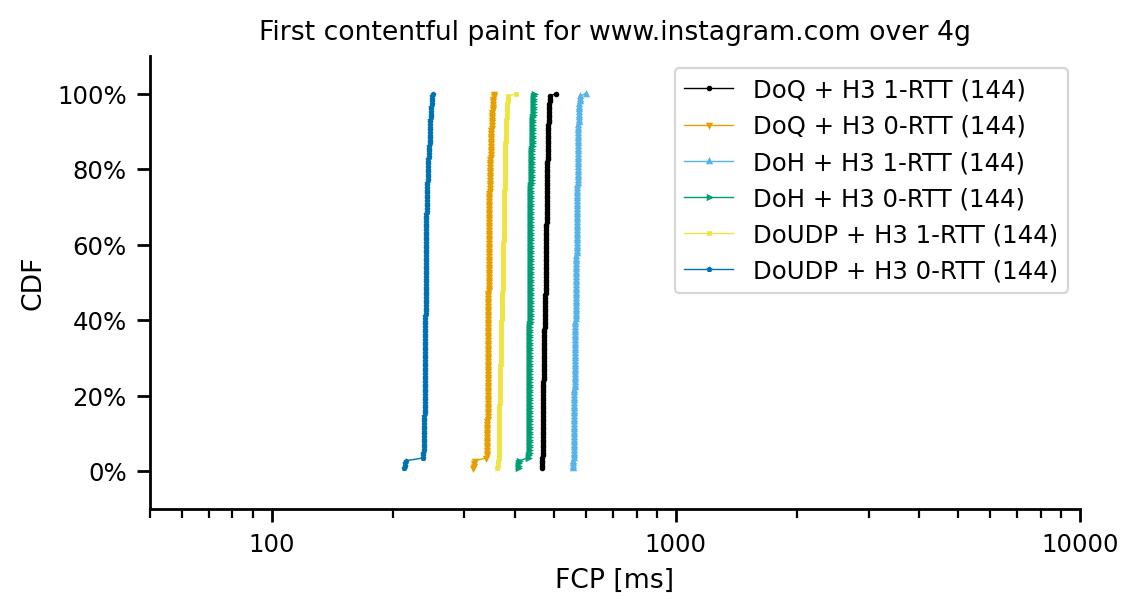

4g-medium
count     73.000000
mean     526.031357
std        3.389819
min      518.873040
10%      522.433857
20%      523.645516
25%      524.204524
30%      524.610039
40%      525.135745
50%      525.899745
60%      526.471660
70%      527.030742
75%      527.806329
80%      528.203618
90%      529.094874
100%     540.667577
max      540.667577
Name: full_fcp, dtype: float64
count     73.000000
mean     356.898480
std        3.468678
min      350.952996
10%      352.574876
20%      353.357523
25%      353.611410
30%      354.064411
40%      355.098570
50%      357.322826
60%      358.373375
70%      359.001874
75%      359.520755
80%      359.907766
90%      361.793311
100%     363.998630
max      363.998630
Name: full_fcp, dtype: float64
count     73.000000
mean     626.884429
std        3.367991
min      619.211315
10%      622.860880
20%      624.729646
25%      625.063327
30%      625.450029
40%      625.882114
50%      626.492126
60%      627.424395
70%      628.402649
75%     

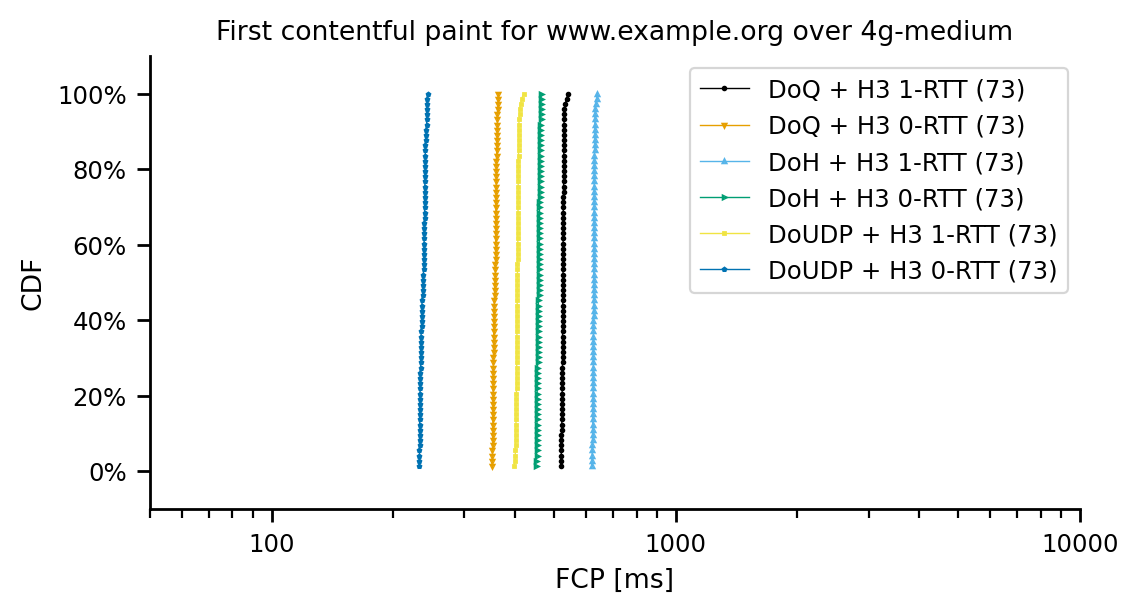

count     73.000000
mean     704.299900
std       36.449602
min      618.650643
10%      637.554251
20%      672.783294
25%      691.647854
30%      701.917533
40%      708.303493
50%      712.203276
60%      719.348718
70%      725.428727
75%      727.069729
80%      729.372859
90%      739.498382
100%     768.101389
max      768.101389
Name: full_fcp, dtype: float64
count     73.000000
mean     369.069763
std       19.396592
min      357.083906
10%      360.106904
20%      361.000979
25%      361.276865
30%      361.587248
40%      362.242356
50%      362.601596
60%      363.134509
70%      363.410810
75%      363.857731
80%      364.554762
90%      405.875594
100%     435.504903
max      435.504903
Name: full_fcp, dtype: float64
count     73.000000
mean     805.534159
std       36.464248
min      722.284683
10%      739.741764
20%      774.218171
25%      792.790758
30%      801.959093
40%      809.941242
50%      813.896015
60%      818.946307
70%      826.284259
75%      829.59182

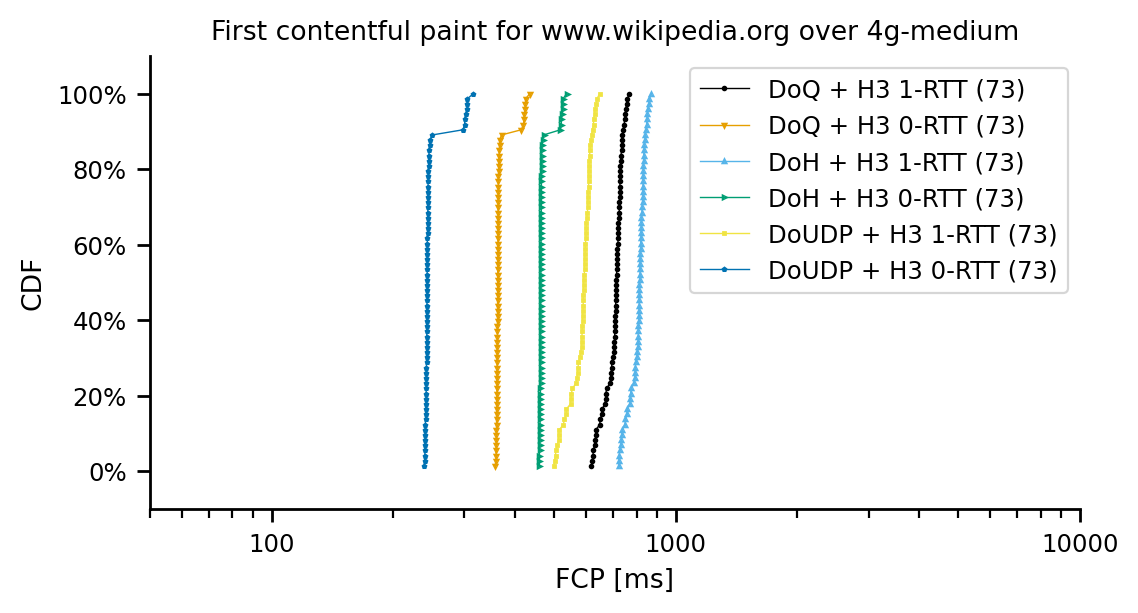

count    144.000000
mean     535.493391
std        4.671282
min      523.181344
10%      529.655204
20%      531.450743
25%      532.199318
30%      532.650951
40%      533.918728
50%      535.891883
60%      536.767753
70%      537.878915
75%      538.578122
80%      539.561796
90%      541.527692
100%     549.306469
max      549.306469
Name: full_fcp, dtype: float64
count    144.000000
mean     387.049641
std        6.873435
min      358.682602
10%      384.010257
20%      385.535083
25%      385.839961
30%      385.965816
40%      386.472419
50%      386.960371
60%      387.412472
70%      388.209255
75%      389.251959
80%      391.130270
90%      394.149616
100%     400.723542
max      400.723542
Name: full_fcp, dtype: float64
count    144.000000
mean     636.556965
std        4.752433
min      624.514553
10%      630.577242
20%      632.168837
25%      633.107591
30%      633.504003
40%      635.229799
50%      636.921766
60%      638.173200
70%      639.173620
75%      639.76049

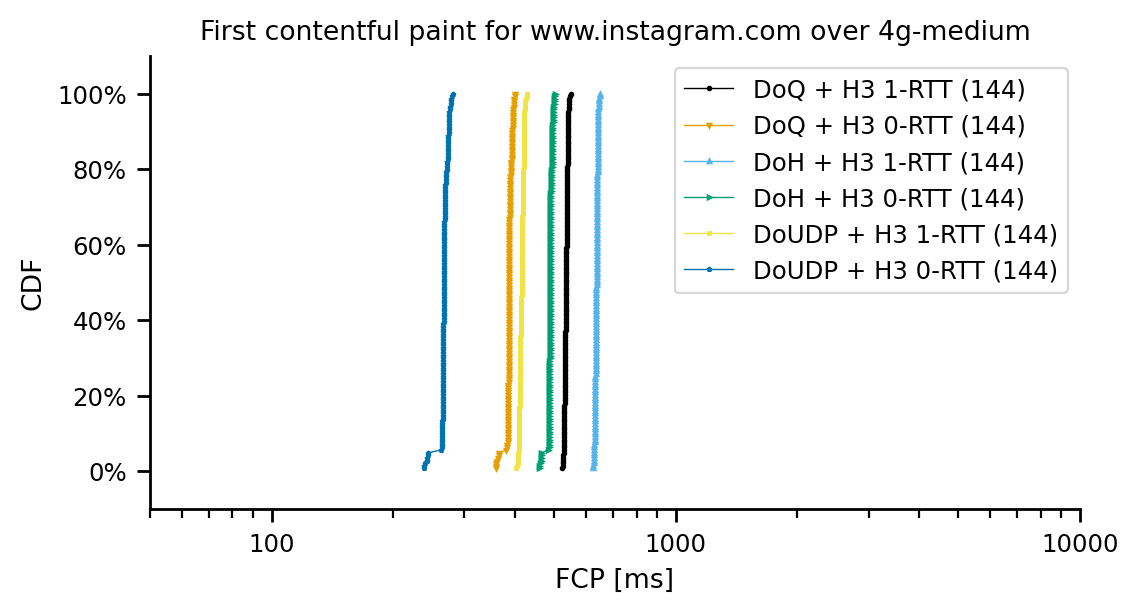

In [139]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_fcp', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_fcp']) == 0:
                    continue
                print(df_tmp['full_fcp'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_fcp'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('First contentful paint for '+website+' over '+access_technology)

        ax.set_xlabel('FCP [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [140]:
df_dns_and_h3.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoUDP + H3 1-RTT',
       'DoQ + H3 0-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'],
      dtype=object)

In [141]:
df_diff_plt_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_plt'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_udp.columns)
            df_diff_plt_udp = df_diff_plt_udp.append(next_df_series, ignore_index=True)
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.629971       34.895493       45.330065             dsl   
1       -52.170719       17.116754       22.135476             dsl   
2       -90.442637        1.737472        2.270072             dsl   
3       -35.039873       23.394199       38.209714           cable   
4       -64.871760        9.709326       15.778660           cable   
5       -67.280361        4.815627        7.855947           cable   
6       -41.413296       21.349828       32.946451           fiber   
7       -70.252459        7.563682       12.050470           fiber   
8       -75.251524        2.998214        4.605347           fiber   
9       -15.523687       28.901926       54.132388              4g   
10      -51.107505       15.377062       28.571878              4g   
11      -70.782256        5.768048       10.865021              4g   
12      -13.215958       29.984527       55.190482       4g-medium   
13      -48.991901       16.289685       29.866793       4g-medium   
14      -76.630428        4.777873        8.825148       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [142]:
df_diff_plt_quic = pd.DataFrame(columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_baseline = df_website[df_website['experiment_description'] == 'DoQ + H3 0-RTT'].copy()
        median_baseline = df_baseline['full_plt'].median()
        if median_baseline is not np.nan:
            next_df_row = []
            for protocol in ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_baseline/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_quic.columns)
            df_diff_plt_quic = df_diff_plt_quic.append(next_df_series, ignore_index=True)
df_diff_plt_quic

DoUDP + H3 1-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0          17.137127       58.012705       70.235464             dsl   
1         109.076946      144.864133      155.357123             dsl   
2         946.313699      964.493102      970.065778             dsl   
3          53.940587       89.953753      112.760845           cable   
4         184.671249      212.310910      229.588559           cable   
5         205.626843      220.344693      229.636727           cable   
6          70.687193      107.128616      126.922566           fiber   
7         236.162236      261.588479      276.671367           fiber   
8         304.065290      316.180033      322.673898           fiber   
9          18.376379       52.589432       82.456340              4g   
10        104.530368      135.981130      162.968535              4g   
11        242.257768      261.999361      279.444145              4g   
12         15.228558       49.779297       78.823755       4g-medium   
13         96.047298      127.982785      154.600339       4g-medium   
14        327.906852      348.351696      365.670265       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [143]:
df_diff_fcp_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_fcp'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_udp.columns)
            df_diff_fcp_udp = df_diff_fcp_udp.append(next_df_series, ignore_index=True)
df_diff_fcp_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -11.767562       34.012514       44.257396             dsl   
1       -37.888329       23.538589       30.712339             dsl   
2        -6.594308       32.817201       42.877350             dsl   
3       -30.439000       22.423469       36.955092           cable   
4       -67.519077       10.277787       16.626663           cable   
5       -17.206651       21.266426       35.046665           cable   
6       -38.792742       19.386184       29.864176           fiber   
7       -59.396428       11.865329       18.535721           fiber   
8       -17.062562       18.871927       29.594156           fiber   
9       -14.475154       28.378427       53.311454              4g   
10      -42.573715       18.618715       34.992086              4g   
11       -7.701891       27.754568       52.104205              4g   
12      -11.910983       29.647445       54.445984       4g-medium   
13      -38.716305       20.370259       37.557461       4g-medium   
14       -6.918446       28.906351       53.208629       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [144]:
df_diff_fcp_quic = pd.DataFrame(columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_baseline = df_website[df_website['experiment_description'] == 'DoQ + H3 0-RTT'].copy()
        median_baseline = df_baseline['full_fcp'].median()
        if median_baseline is not np.nan:
            next_df_row = []
            for protocol in ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_baseline/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_quic.columns)
            df_diff_fcp_quic = df_diff_fcp_quic.append(next_df_series, ignore_index=True)
df_diff_fcp_quic

DoUDP + H3 1-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0          13.337002       51.885766       63.497008             dsl   
1          61.000337       98.897546      110.447306             dsl   
2           7.059856       42.193905       52.964286             dsl   
3          43.758715       75.994406       96.884880           cable   
4         207.873026      239.515562      259.062037           cable   
5          20.782648       46.468801       63.112939           cable   
6          63.379316       95.052332      112.171203           fiber   
7         146.283748      175.506124      191.934217           fiber   
8          20.572811       43.327224       56.255317           fiber   
9          16.925086       50.106587       79.259550              4g   
10         74.136286      106.558225      135.070205              4g   
11          8.344581       38.415152       64.796664              4g   
12         13.521530       47.177764       75.329445       4g-medium   
13         63.175540       96.414821      124.460130       4g-medium   
14          7.432671       38.487536       64.596122       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

DoQ + H3 0-RTT
count    15.000000
mean    -52.506956
std      24.417808
min     -90.442637
10%     -76.078866
20%     -71.676109
25%     -70.517357
30%     -69.658039
40%     -65.835200
50%     -52.170719
60%     -50.261263
70%     -42.929017
75%     -38.226585
80%     -31.136636
90%     -14.987457
100%    -13.215958
max     -13.215958
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     14.978648
std      10.781473
min       1.737472
10%       3.710078
20%       4.808076
25%       5.291838
30%       6.127175
40%       8.851069
50%      15.377062
60%      16.620512
70%      20.503213
75%      22.372013
80%      24.495744
90%      29.551487
100%     34.895493
max      34.895493
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     24.575594
std      17.715449
min       2.270072
10%       5.905587
20%       8.631308
25%       9.845084
30%      11.102110
40%      14.287384
50%      22.135476
60%      29.089844
70%      32.330520
75%    

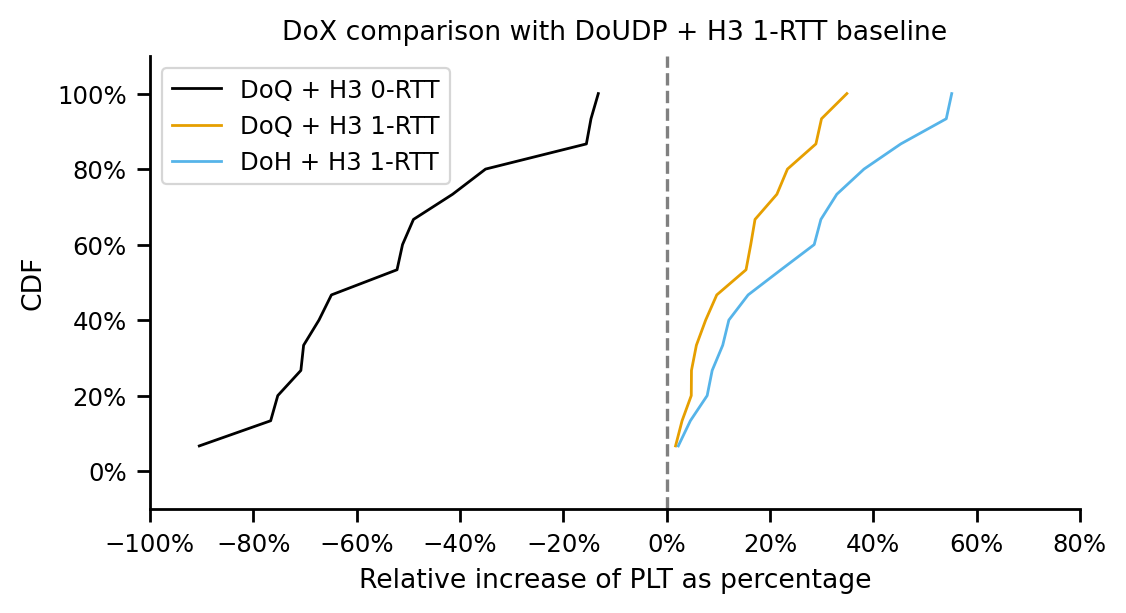

In [145]:
df_tmp = df_diff_plt_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoUDP + H3 1-RTT
count     15.000000
mean     195.468560
std      232.076828
min       15.228558
10%       17.632828
20%       46.827745
25%       62.313890
30%       75.759214
40%      101.137140
50%      109.076946
60%      193.053487
70%      230.055157
75%      239.210002
80%      254.619272
90%      318.370227
100%     946.313699
max      946.313699
Name: DoUDP + H3 1-RTT, dtype: float64
DoQ + H3 1-RTT
count     15.000000
mean     223.437342
std      226.374418
min       49.779297
10%       54.758741
20%       83.565544
25%       98.541185
30%      111.299450
40%      132.781792
50%      144.864133
60%      215.524423
70%      253.339722
75%      261.793920
80%      272.835495
90%      335.483031
100%     964.493102
max      964.493102
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count     15.000000
mean     241.191714
std      221.634288
min       70.235464
10%       80.276789
20%      106.699944
25%      119.841706
30%      132.458121
40%      155.054410
50%      162.9685

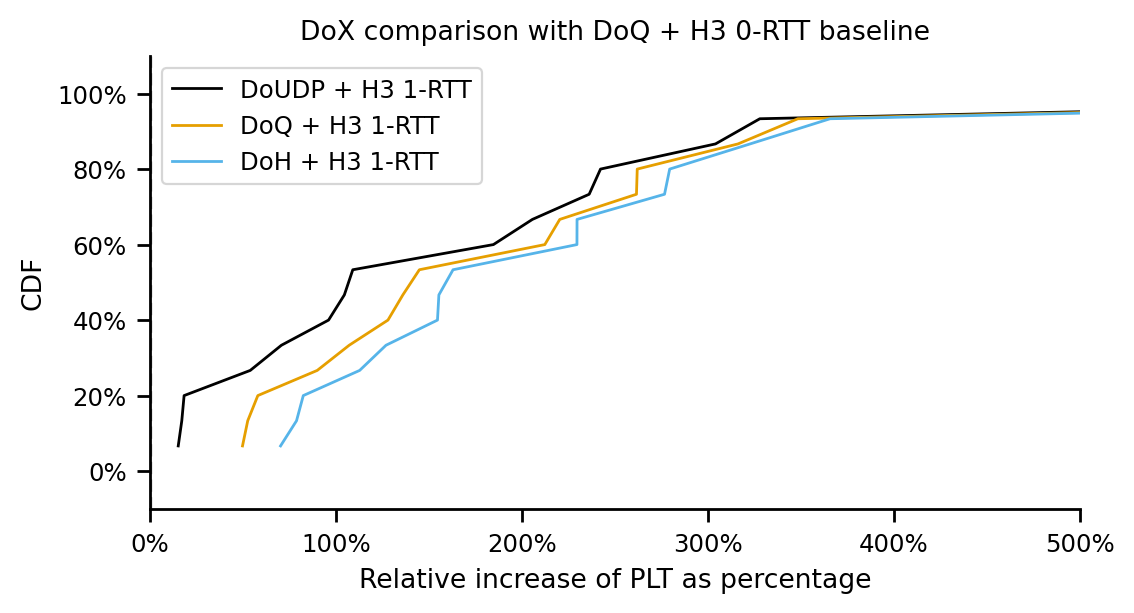

In [146]:
df_tmp = df_diff_plt_quic
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoQ + H3 0-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 500)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doq-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doq-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoUDP + H3 1-RTT
count     15.000000
mean      51.172210
std       57.413530
min        7.059856
10%        7.797435
20%       12.338518
25%       13.429266
30%       14.202241
40%       19.113721
50%       20.782648
60%       50.655364
70%       62.740500
75%       63.277428
80%       65.530710
90%      117.424763
100%     207.873026
max      207.873026
Name: DoUDP + H3 1-RTT, dtype: float64
DoQ + H3 1-RTT
count     15.000000
mean      83.066783
std       57.391215
min       38.415152
10%       39.970084
20%       43.100560
25%       44.898013
30%       46.610594
40%       48.935058
50%       51.885766
60%       83.617576
70%       96.142323
75%       97.656183
80%      100.429682
90%      147.926964
100%     239.515562
max      239.515562
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count     15.000000
mean     103.322754
std       57.341595
min       52.964286
10%       58.998366
20%       63.420194
25%       64.046565
30%       64.636231
40%       71.116332
50%       79.2595

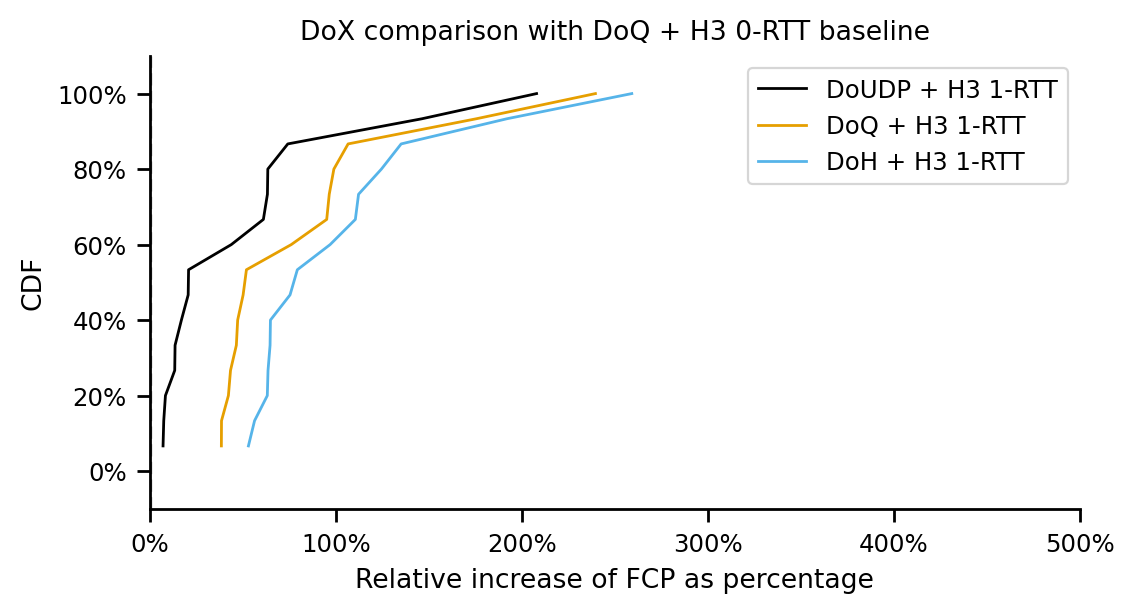

In [147]:
df_tmp = df_diff_fcp_quic
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoQ + H3 0-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 500)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doq-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doq-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ + H3 0-RTT
count    15.000000
mean    -27.264210
std      19.535423
min     -67.519077
10%     -52.667343
20%     -39.548936
25%     -38.754524
30%     -38.550710
40%     -33.418731
50%     -17.206651
60%     -16.027599
70%     -12.423817
75%     -11.839273
80%     -10.954428
90%      -7.231824
100%     -6.594308
max      -6.594308
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     23.209013
std       7.037043
min      10.277787
10%      14.566683
20%      18.821285
25%      19.129056
30%      19.582999
40%      20.907959
50%      22.423469
60%      25.224981
70%      28.253655
75%      28.642389
80%      29.054570
90%      31.549299
100%     34.012514
max      34.012514
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     38.005958
std      12.079439
min      16.626663
10%      22.959095
20%      29.810172
25%      30.288257
30%      31.568288
40%      35.024833
50%      36.955092
60%      39.685416
70%      43.981386
75%    

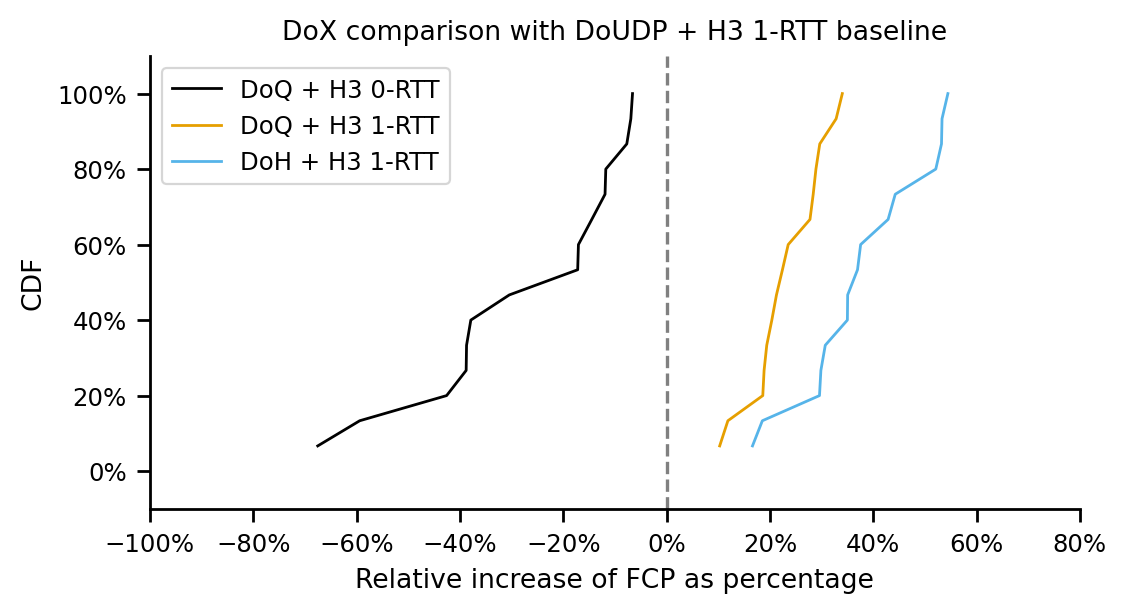

In [148]:
df_tmp = df_diff_fcp_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

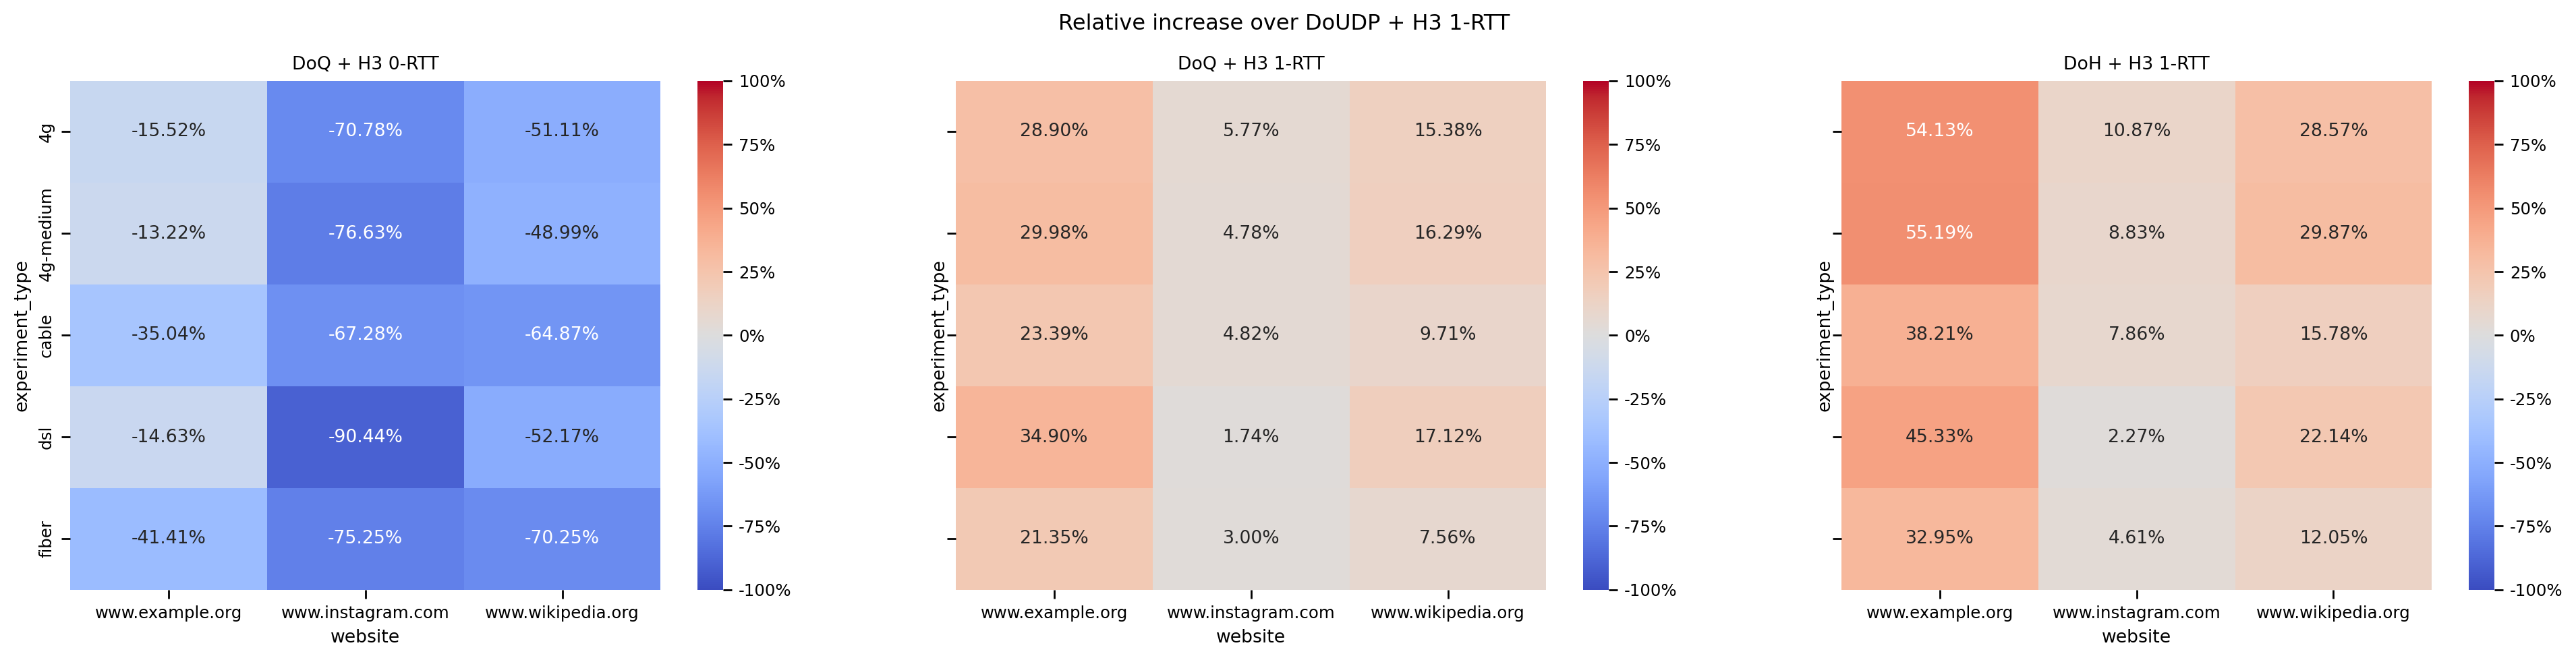

In [149]:
fig, axs = plt.subplots(1, 3, sharex='all', figsize=(24,5), sharey='all')
ax_hm1 =sns.heatmap(df_diff_plt_udp[['DoQ + H3 0-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 0-RTT'), ax=axs.flat[0], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm2 = sns.heatmap(df_diff_plt_udp[['DoQ + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 1-RTT'), ax=axs.flat[1], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm3 = sns.heatmap(df_diff_plt_udp[['DoH + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoH + H3 1-RTT'), ax=axs.flat[2], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
axs.flat[0].set_title('DoQ + H3 0-RTT')
axs.flat[1].set_title('DoQ + H3 1-RTT')
axs.flat[2].set_title('DoH + H3 1-RTT')
fig.suptitle('Relative increase over DoUDP + H3 1-RTT')
ax_hm1.set_yticklabels(labels=ax_hm1.get_yticklabels(), va='center')
for t in ax_hm1.texts: t.set_text(t.get_text() + "%")
for t in ax_hm2.texts: t.set_text(t.get_text() + "%")
for t in ax_hm3.texts: t.set_text(t.get_text() + "%")
plt.show()

In [150]:
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.629971       34.895493       45.330065             dsl   
1       -52.170719       17.116754       22.135476             dsl   
2       -90.442637        1.737472        2.270072             dsl   
3       -35.039873       23.394199       38.209714           cable   
4       -64.871760        9.709326       15.778660           cable   
5       -67.280361        4.815627        7.855947           cable   
6       -41.413296       21.349828       32.946451           fiber   
7       -70.252459        7.563682       12.050470           fiber   
8       -75.251524        2.998214        4.605347           fiber   
9       -15.523687       28.901926       54.132388              4g   
10      -51.107505       15.377062       28.571878              4g   
11      -70.782256        5.768048       10.865021              4g   
12      -13.215958       29.984527       55.190482       4g-medium   
13      -48.991901       16.289685       29.866793       4g-medium   
14      -76.630428        4.777873        8.825148       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [151]:
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.629971       34.895493       45.330065             dsl   
1       -52.170719       17.116754       22.135476             dsl   
2       -90.442637        1.737472        2.270072             dsl   
3       -35.039873       23.394199       38.209714           cable   
4       -64.871760        9.709326       15.778660           cable   
5       -67.280361        4.815627        7.855947           cable   
6       -41.413296       21.349828       32.946451           fiber   
7       -70.252459        7.563682       12.050470           fiber   
8       -75.251524        2.998214        4.605347           fiber   
9       -15.523687       28.901926       54.132388              4g   
10      -51.107505       15.377062       28.571878              4g   
11      -70.782256        5.768048       10.865021              4g   
12      -13.215958       29.984527       55.190482       4g-medium   
13      -48.991901       16.289685       29.866793       4g-medium   
14      -76.630428        4.777873        8.825148       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [152]:
df_udp_baseline_medians = df_dns_and_h3[df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT'].groupby(['website','experiment_type'], as_index=False).agg(full_plt_udp_med=('full_plt', 'median'), full_fcp_udp_med=('full_fcp', 'median'))

In [153]:
df_diff_all_data_udp_baseline_medians = pd.merge(df_dns_and_h3[df_dns_and_h3.experiment_description != 'DoUDP + H3 1-RTT'], df_udp_baseline_medians, on=['website', 'experiment_type'])
df_diff_all_data_udp_baseline_medians['relative_increase_plt'] = (df_diff_all_data_udp_baseline_medians['full_plt']/(df_diff_all_data_udp_baseline_medians['full_plt_udp_med']/100))-100
df_diff_all_data_udp_baseline_medians['relative_increase_fcp'] = (df_diff_all_data_udp_baseline_medians['full_fcp']/(df_diff_all_data_udp_baseline_medians['full_fcp_udp_med']/100))-100
df_diff_all_data_udp_baseline_medians

msm_id  connectEnd  connectStart  \
0     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
1     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
2     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
3     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
4     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
...                                    ...         ...           ...   
7260  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7261  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7262  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   
7263  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   
7264  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   

      domComplete  domContentLoadedEventEnd  domContentLoadedEventStart  \
0           184.3                     184.3                       184.3   
1           184.3                     184.3                       184.3   
2            72.9                      72.2                        72.2   
3            72.9                      72.2                        72.2   
4            72.9                      72.2                        72.2   
...           ...                       ...                         ...   
7260       2398.2                    2033.9                      2033.9   
7261       2398.2                    2033.9                      2033.9   
7262        367.0                     161.8                       161.8   
7263        367.0                     161.8                       161.8   
7264        367.0                     161.8                       161.8   

      domInteractive  domainLookupEnd  domainLookupStart  duration  ...  \
0              184.3             45.9               45.9     184.3  ...   
1              184.3             45.9               45.9     184.3  ...   
2               72.2              2.0                2.0      72.9  ...   
3               72.2              2.0                2.0      72.9  ...   
4               72.2              2.0                2.0      72.9  ...   
...              ...              ...                ...       ...  ...   
7260          2033.9             46.0               46.0    2398.7  ...   
7261          2033.9             46.0               46.0    2398.7  ...   
7262           161.8              0.4                0.4     367.3  ...   
7263           161.8              0.4                0.4     367.3  ...   
7264           161.8              0.4                0.4     367.3  ...   

      transport_protocol     full_plt     full_fp    full_fcp  h3_description  \
0                    DoQ   308.403523  313.103523  313.103523        H3 1-RTT   
1                    DoH   332.963518  337.663518  337.663518        H3 1-RTT   
2                    DoQ   197.003523  204.703523  204.703523        H3 0-RTT   
3                    DoH   221.563518  229.263518  229.263518        H3 0-RTT   
4                  DoUDP   117.057384  124.757384  124.757384        H3 0-RTT   
...                  ...          ...         ...         ...             ...   
7260                 DoQ  2623.880610  536.080610  536.080610        H3 1-RTT   
7261                 DoH  2725.661823  637.861823  637.861823        H3 1-RTT   
7262                 DoQ   592.480610  393.180610  393.180610        H3 0-RTT   
7263                 DoH   694.261823  494.961823  494.961823        H3 0-RTT   
7264               DoUDP   472.687887  273.387887  273.387887        H3 0-RTT   

      experiment_description  full_plt_udp_med  full_fcp_udp_med  \
0             DoQ + H3 1-RTT        230.427449        236.416953   
1             DoH + H3 1-RTT        230.427449        236.416953   
2             DoQ + H3 0-RTT        230.427449        236.416953   
3             DoH + H3 0-RTT        230.427449        236.416953   
4           DoUDP + H3 0-RTT        230.427449        23

In [154]:
df_diff_all_data_udp_baseline_medians.experiment_type.unique()

array(['dsl', 'cable', 'fiber', '4g', '4g-medium'], dtype=object)

In [155]:
df_diff_all_data_udp_baseline_medians.website.unique()

array(['www.example.org', 'www.wikipedia.org', 'www.instagram.com'],
      dtype=object)

In [156]:
df_diff_all_data_udp_baseline_medians.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoQ + H3 0-RTT',
       'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'], dtype=object)

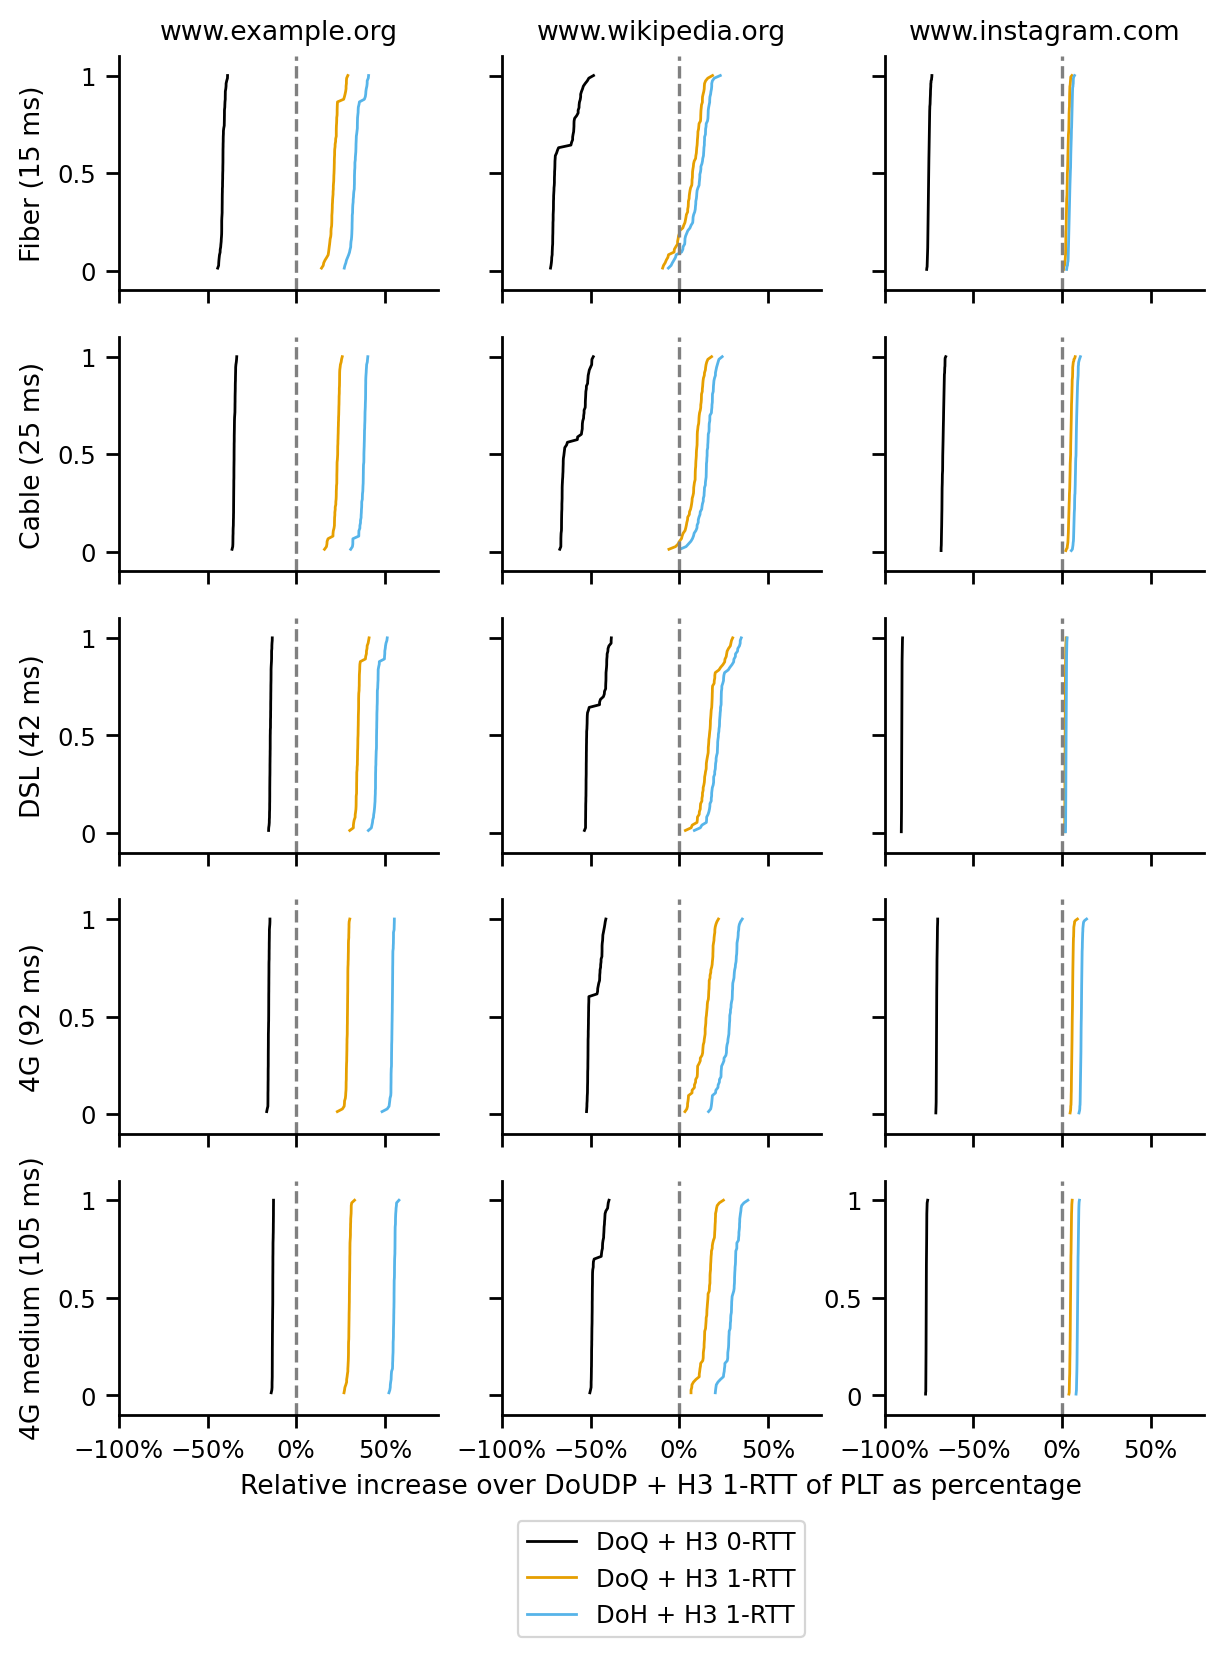

<Figure size 1200x800 with 0 Axes>

In [157]:
metrics_for_single_cdf = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_udp_baseline_medians[(df_diff_all_data_udp_baseline_medians['website'] == website) & (df_diff_all_data_udp_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_udp_baseline_medians['experiment_description'] == metric)]['relative_increase_plt'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoUDP + H3 1-RTT of PLT as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-100, 80)

plt.show()
plt.savefig("figures/plt-doudp-baseline-grid.pdf", bbox_inches='tight')

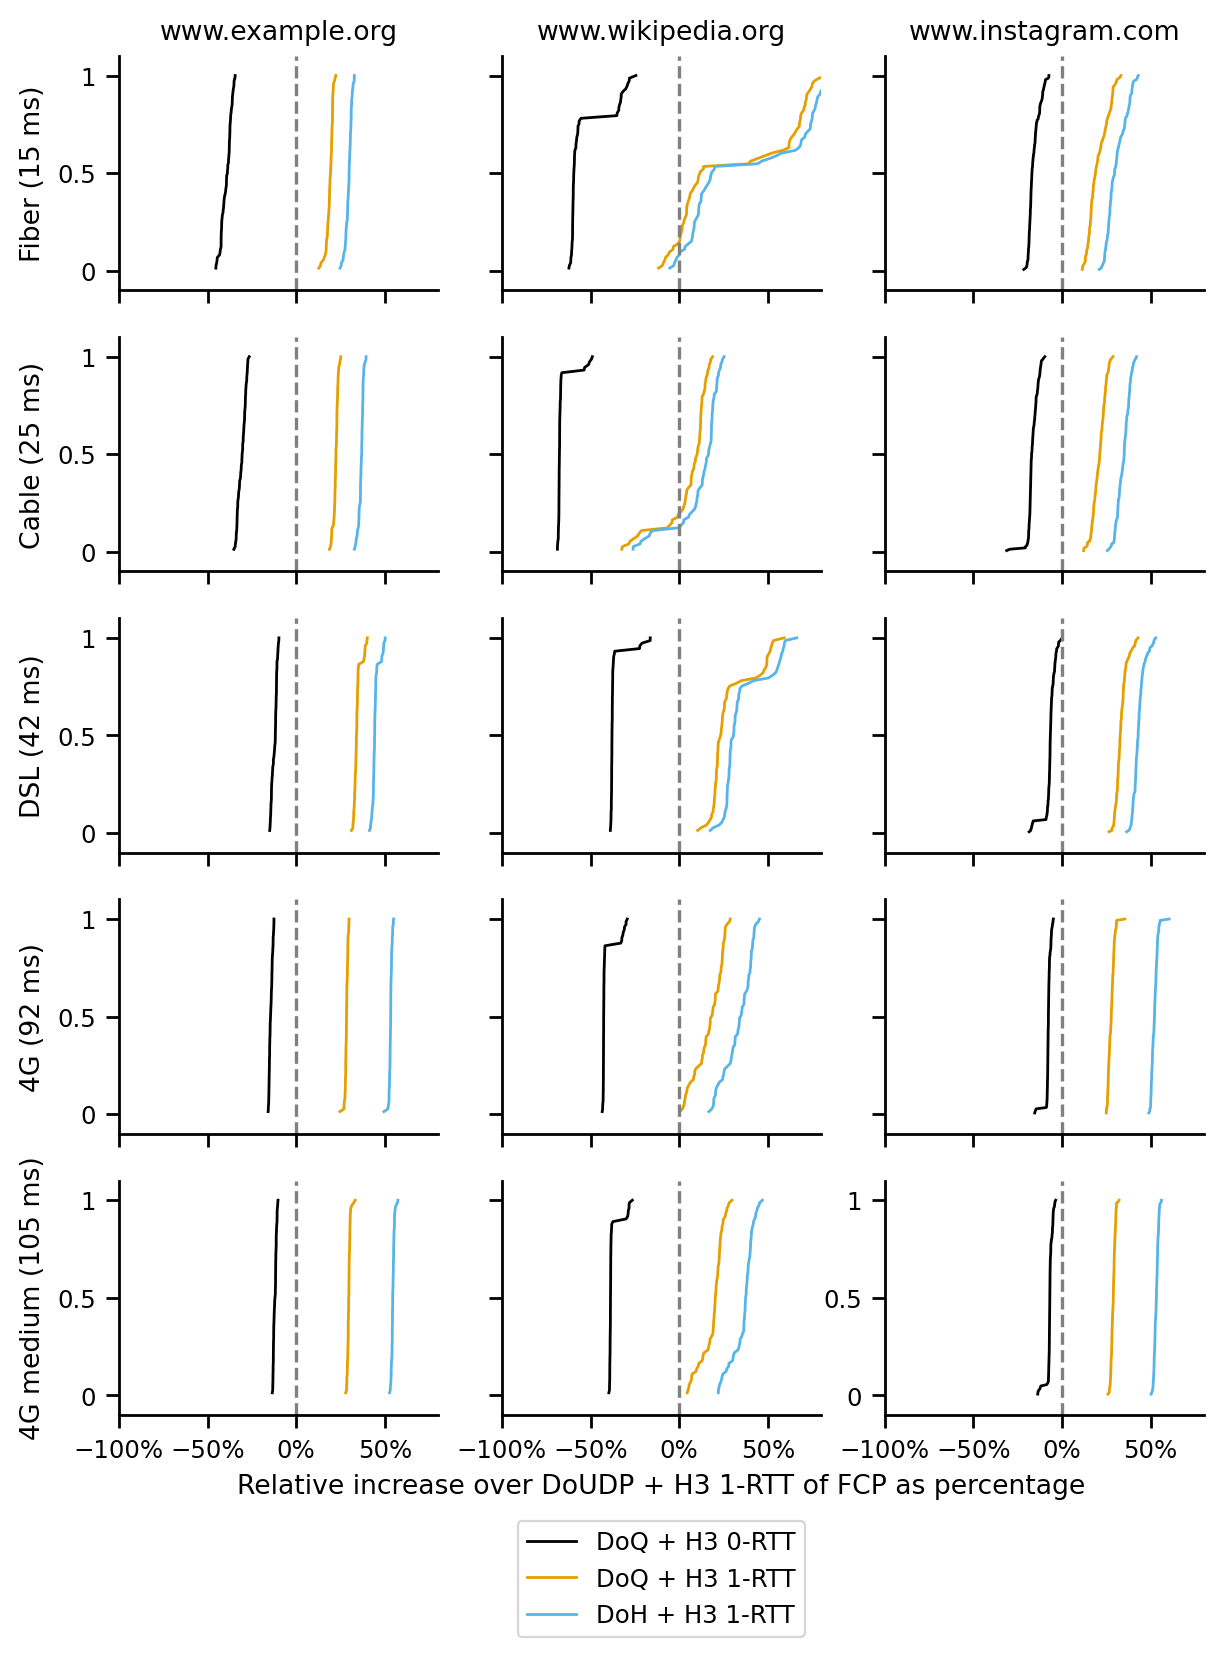

<Figure size 1200x800 with 0 Axes>

In [158]:
metrics_for_single_cdf = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_udp_baseline_medians[(df_diff_all_data_udp_baseline_medians['website'] == website) & (df_diff_all_data_udp_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_udp_baseline_medians['experiment_description'] == metric)]['relative_increase_fcp'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoUDP + H3 1-RTT of FCP as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-100, 80)

plt.show()
plt.savefig("figures/fcp-doudp-baseline-grid.pdf", bbox_inches='tight')

In [159]:
df_quic_baseline_medians = df_dns_and_h3[df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT'].groupby(['website','experiment_type'], as_index=False).agg(full_plt_udp_med=('full_plt', 'median'), full_fcp_udp_med=('full_fcp', 'median'))

In [160]:
df_diff_all_data_quic_baseline_medians = pd.merge(df_dns_and_h3[df_dns_and_h3.experiment_description != 'DoQ + H3 0-RTT'], df_quic_baseline_medians, on=['website', 'experiment_type'])
df_diff_all_data_quic_baseline_medians['relative_increase_plt'] = (df_diff_all_data_quic_baseline_medians['full_plt']/(df_diff_all_data_quic_baseline_medians['full_plt_udp_med']/100))-100
df_diff_all_data_quic_baseline_medians['relative_increase_fcp'] = (df_diff_all_data_quic_baseline_medians['full_fcp']/(df_diff_all_data_quic_baseline_medians['full_fcp_udp_med']/100))-100
df_diff_all_data_quic_baseline_medians

msm_id  connectEnd  connectStart  \
0     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
1     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
2     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
3     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
4     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
...                                    ...         ...           ...   
7260  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7261  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7262  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7263  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   
7264  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   

      domComplete  domContentLoadedEventEnd  domContentLoadedEventStart  \
0           184.3                     184.3                       184.3   
1           184.3                     184.3                       184.3   
2           184.3                     184.3                       184.3   
3            72.9                      72.2                        72.2   
4            72.9                      72.2                        72.2   
...           ...                       ...                         ...   
7260       2398.2                    2033.9                      2033.9   
7261       2398.2                    2033.9                      2033.9   
7262       2398.2                    2033.9                      2033.9   
7263        367.0                     161.8                       161.8   
7264        367.0                     161.8                       161.8   

      domInteractive  domainLookupEnd  domainLookupStart  duration  ...  \
0              184.3             45.9               45.9     184.3  ...   
1              184.3             45.9               45.9     184.3  ...   
2              184.3             45.9               45.9     184.3  ...   
3               72.2              2.0                2.0      72.9  ...   
4               72.2              2.0                2.0      72.9  ...   
...              ...              ...                ...       ...  ...   
7260          2033.9             46.0               46.0    2398.7  ...   
7261          2033.9             46.0               46.0    2398.7  ...   
7262          2033.9             46.0               46.0    2398.7  ...   
7263           161.8              0.4                0.4     367.3  ...   
7264           161.8              0.4                0.4     367.3  ...   

      transport_protocol     full_plt     full_fp    full_fcp  h3_description  \
0                    DoQ   308.403523  313.103523  313.103523        H3 1-RTT   
1                    DoH   332.963518  337.663518  337.663518        H3 1-RTT   
2                  DoUDP   228.457384  233.157384  233.157384        H3 1-RTT   
3                    DoH   221.563518  229.263518  229.263518        H3 0-RTT   
4                  DoUDP   117.057384  124.757384  124.757384        H3 0-RTT   
...                  ...          ...         ...         ...             ...   
7260                 DoQ  2623.880610  536.080610  536.080610        H3 1-RTT   
7261                 DoH  2725.661823  637.861823  637.861823        H3 1-RTT   
7262               DoUDP  2504.087887  416.287887  416.287887        H3 1-RTT   
7263                 DoH   694.261823  494.961823  494.961823        H3 0-RTT   
7264               DoUDP   472.687887  273.387887  273.387887        H3 0-RTT   

      experiment_description  full_plt_udp_med  full_fcp_udp_med  \
0             DoQ + H3 1-RTT        196.715981        208.596441   
1             DoH + H3 1-RTT        196.715981        208.596441   
2           DoUDP + H3 1-RTT        196.715981        208.596441   
3             DoH + H3 0-RTT        196.715981        208.596441   
4           DoUDP + H3 0-RTT        196.715981        20

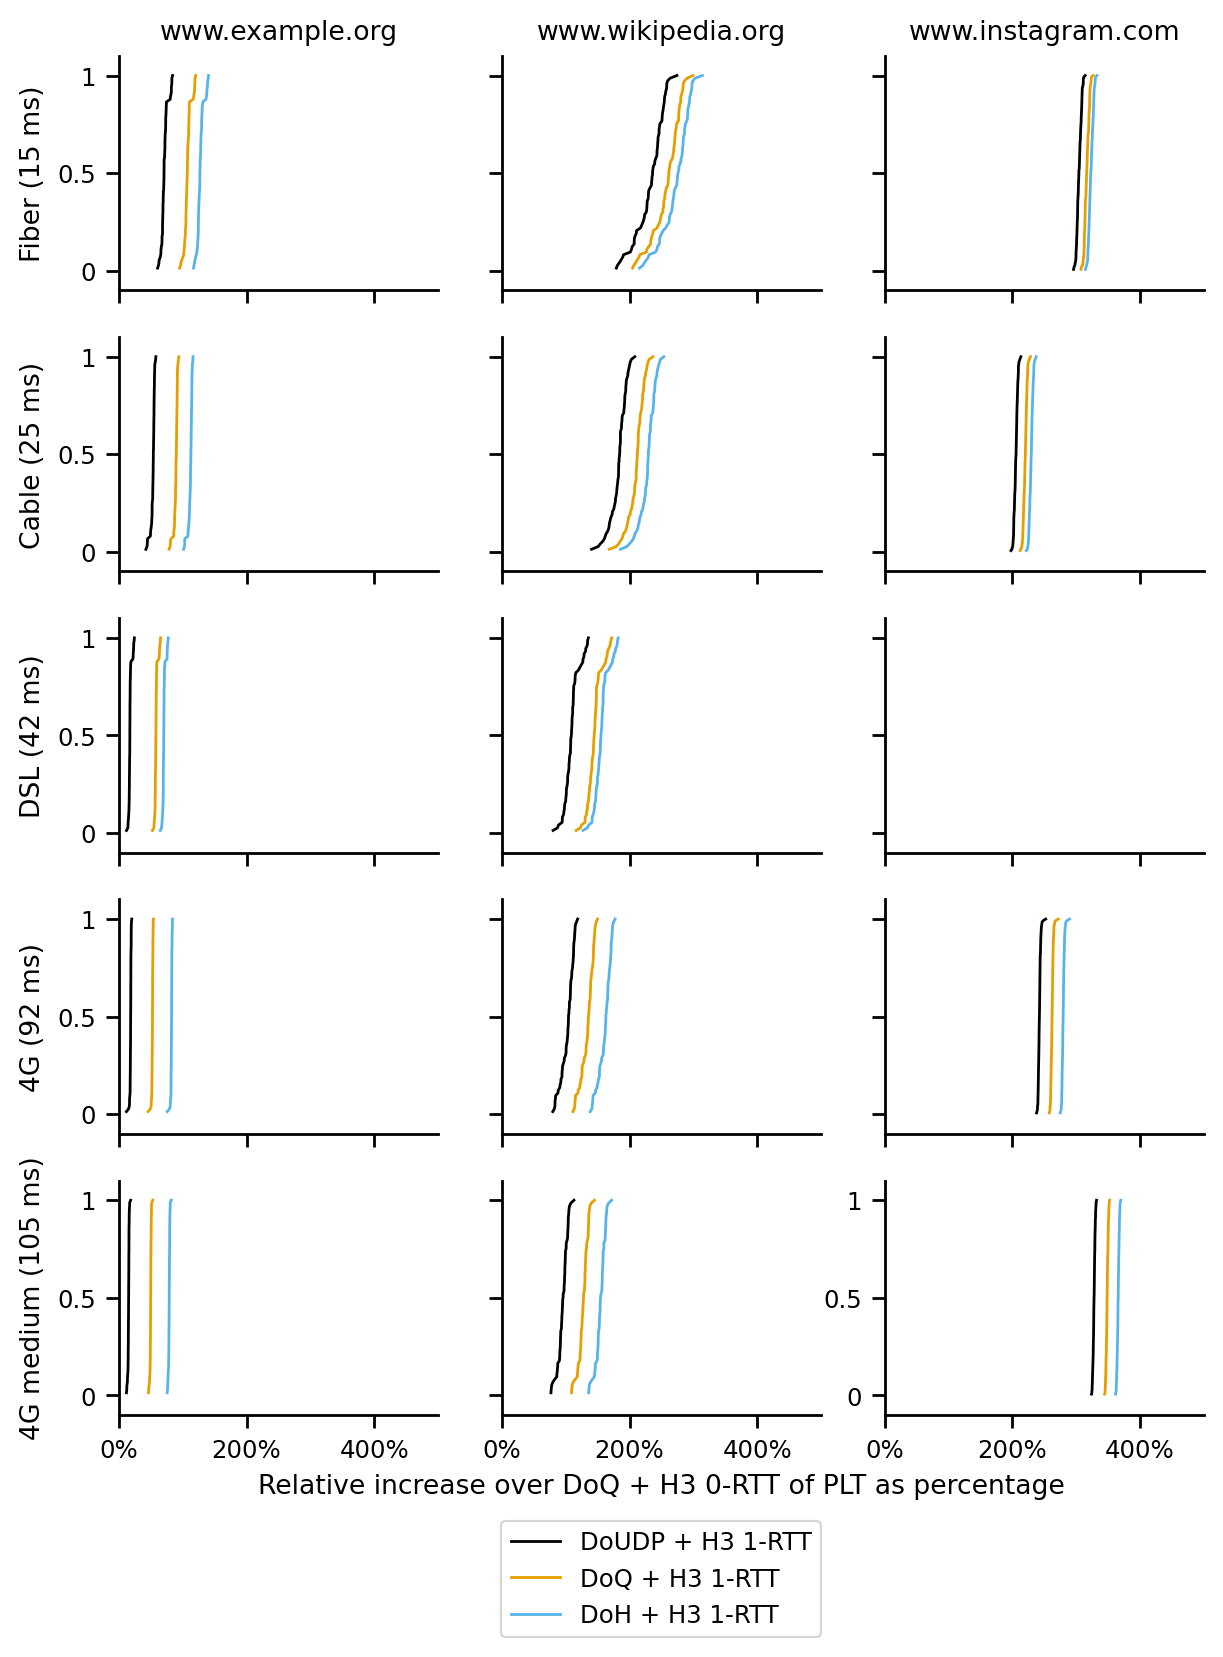

<Figure size 1200x800 with 0 Axes>

In [161]:
metrics_for_single_cdf = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_quic_baseline_medians[(df_diff_all_data_quic_baseline_medians['website'] == website) & (df_diff_all_data_quic_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_quic_baseline_medians['experiment_description'] == metric)]['relative_increase_plt'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        #ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoQ + H3 0-RTT of PLT as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(0, 500)

plt.show()
plt.savefig("figures/plt-doq-baseline-grid.pdf", bbox_inches='tight')

DoQ+0rtt -> 1-rtt handshake
DoUDP+1-rtt -> 1-rtt handshake
-> compare their relative increase in PLT from 4g to 4g medium for www.example.org (inflight should always be below BDP)

In [55]:
df_exchange_durations = df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'exchange'].copy()
df_exchange_durations = pd.merge(df_exchange_durations, measurements, on='msm_id')

In [57]:
df_exchange_durations.experiment_type.unique()

array(['dsl', 'cable', 'fiber', '4g', '4g-medium'], dtype=object)

In [58]:
df_exchange_durations['rtt'] = 0
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'dsl', 42.35979, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'cable', 25.17665, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'fiber', 14.767147, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == '4g', 91.85231065904635, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == '4g-medium', 104.5041425140391, df_exchange_durations['rtt'])

In [62]:
df_exchange_durations['duration_in_rtt'] = df_exchange_durations['duration'] / df_exchange_durations['rtt']

In [74]:
df_exchange_durations['handshake_round_trips'] = 0
df_exchange_durations['handshake_round_trips'] = np.where(df_exchange_durations['transport_protocol'] == 'DoQ', 1, df_exchange_durations['handshake_round_trips'])
df_exchange_durations['handshake_round_trips'] = np.where(df_exchange_durations['transport_protocol'] == 'DoH', 2, df_exchange_durations['handshake_round_trips'])

In [76]:
df_exchange_durations['theoretical_handshake_duration'] = df_exchange_durations['handshake_round_trips'] * df_exchange_durations['rtt']

In [78]:
df_exchange_durations['theoretical_exchange_without_handshake'] = df_exchange_durations['duration'] - df_exchange_durations['theoretical_handshake_duration']

In [80]:
df_exchange_durations['theoretical_query_in_rtt'] = df_exchange_durations['theoretical_exchange_without_handshake'] / df_exchange_durations['rtt']

In [88]:
df_exchange_durations['theoretical_processing_delay'] = df_exchange_durations['theoretical_exchange_without_handshake'] - df_exchange_durations['rtt']

In [65]:
df_exchange_durations.transport_protocol.unique()

array(['DoQ', 'DoH', 'DoUDP'], dtype=object)

DoQ
count    1453.000000
mean        2.500816
std         0.322787
min         2.108462
10%         2.132539
20%         2.149440
25%         2.154638
30%         2.156122
40%         2.374287
50%         2.496276
60%         2.560865
70%         2.774205
75%         2.804207
80%         2.889985
90%         2.934575
100%        2.980782
max         2.980782
Name: duration_in_rtt, dtype: float64
DoH
count    1453.000000
mean        3.381177
std         0.229283
min         3.071857
10%         3.122571
20%         3.124274
25%         3.125205
30%         3.126396
40%         3.372264
50%         3.433358
60%         3.483071
70%         3.507613
75%         3.510349
80%         3.549232
90%         3.713069
100%        3.845313
max         3.845313
Name: duration_in_rtt, dtype: float64
DoUDP
count    1453.000000
mean        1.027741
std         0.016692
min         1.006121
10%         1.008299
20%         1.008729
25%         1.008936
30%         1.009131
40%         1.019227
50%    

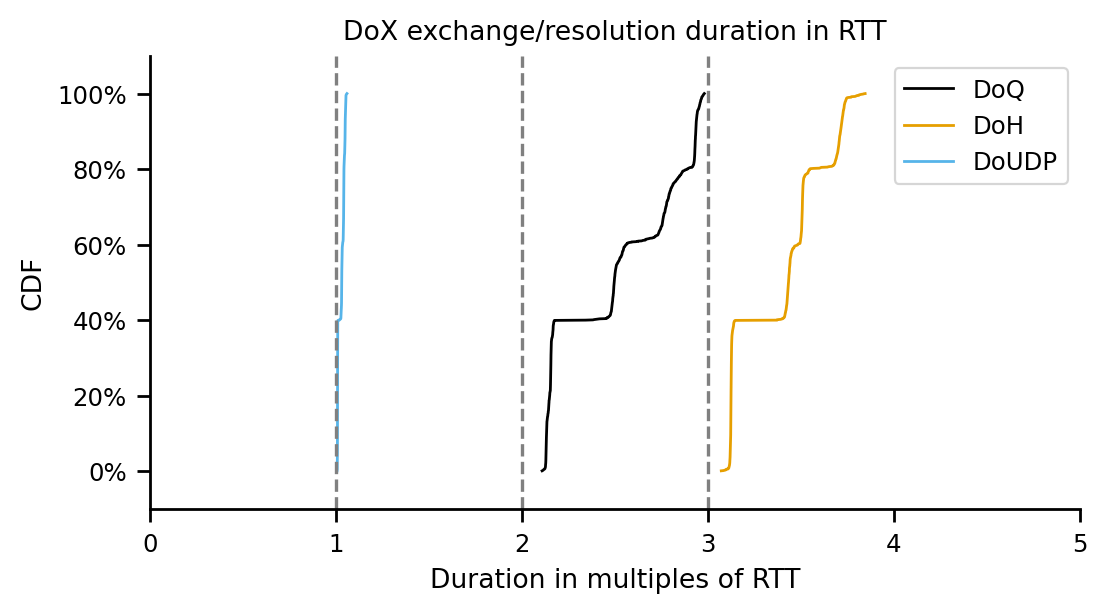

In [69]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=2, color='gray', linestyle='--')
plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX exchange/resolution duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/exchange-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/exchange-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean       2.770794
std        0.064324
min        2.455970
10%        2.712811
20%        2.744484
25%        2.752771
30%        2.756189
40%        2.763427
50%        2.773671
60%        2.785317
70%        2.796154
75%        2.803621
80%        2.812285
90%        2.846062
100%       2.895871
max        2.895871
Name: duration_in_rtt, dtype: float64
DoH
count    291.000000
mean       3.712724
std        0.037200
min        3.481318
10%        3.684291
20%        3.695711
25%        3.699780
30%        3.702958
40%        3.707168
50%        3.713071
60%        3.718701
70%        3.724386
75%        3.727007
80%        3.731308
90%        3.739709
100%       3.845313
max        3.845313
Name: duration_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.048746
std        0.003955
min        1.027996
10%        1.043732
20%        1.046789
25%        1.047693
30%        1.047991
40%        1.048978
50%        1.049356
60%        1.049937
70%       

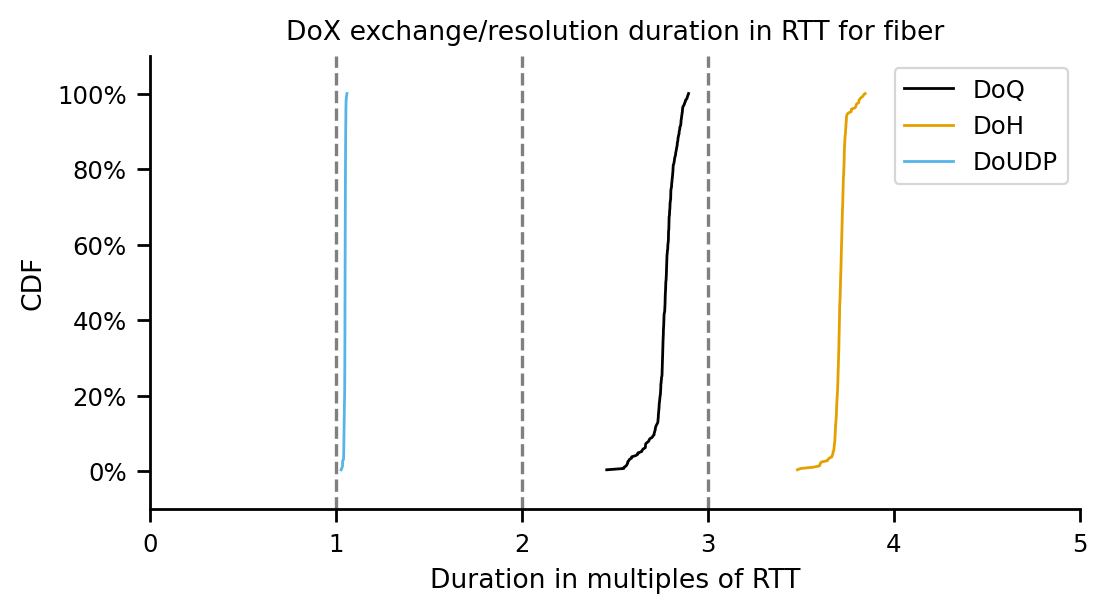

DoQ
count    291.000000
mean       2.500800
std        0.028215
min        2.341952
10%        2.478674
20%        2.484802
25%        2.487507
30%        2.489209
40%        2.493290
50%        2.496276
60%        2.500173
70%        2.506476
75%        2.513279
80%        2.524320
90%        2.539850
100%       2.565114
max        2.565114
Name: duration_in_rtt, dtype: float64
DoH
count    291.000000
mean       3.434003
std        0.017666
min        3.371917
10%        3.417081
20%        3.423538
25%        3.425482
30%        3.426714
40%        3.429928
50%        3.433344
60%        3.435859
70%        3.438961
75%        3.441095
80%        3.442214
90%        3.449766
100%       3.521321
max        3.521321
Name: duration_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.030933
std        0.002318
min        1.018202
10%        1.027932
20%        1.029930
25%        1.030239
30%        1.030436
40%        1.030908
50%        1.031234
60%        1.031521
70%       

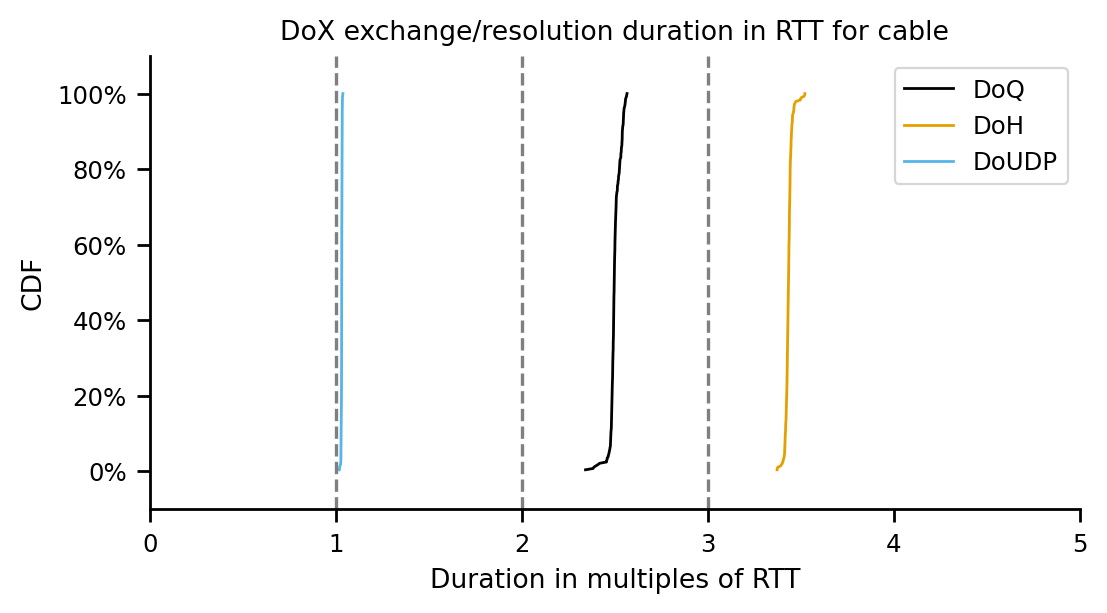

DoQ
count    291.000000
mean       2.937621
std        0.017097
min        2.828531
10%        2.925936
20%        2.929178
25%        2.929913
30%        2.930884
40%        2.932674
50%        2.934585
60%        2.936323
70%        2.940278
75%        2.943016
80%        2.950122
90%        2.960874
100%       2.980782
max        2.980782
Name: duration_in_rtt, dtype: float64
DoH
count    291.000000
mean       3.508632
std        0.012262
min        3.434134
10%        3.499782
20%        3.503453
25%        3.504373
30%        3.505136
40%        3.506349
50%        3.507587
60%        3.508412
70%        3.509586
75%        3.510286
80%        3.511572
90%        3.519233
100%       3.549738
max        3.549738
Name: duration_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.041549
std        0.001395
min        1.034310
10%        1.039726
20%        1.040574
25%        1.040947
30%        1.041157
40%        1.041499
50%        1.041696
60%        1.041898
70%       

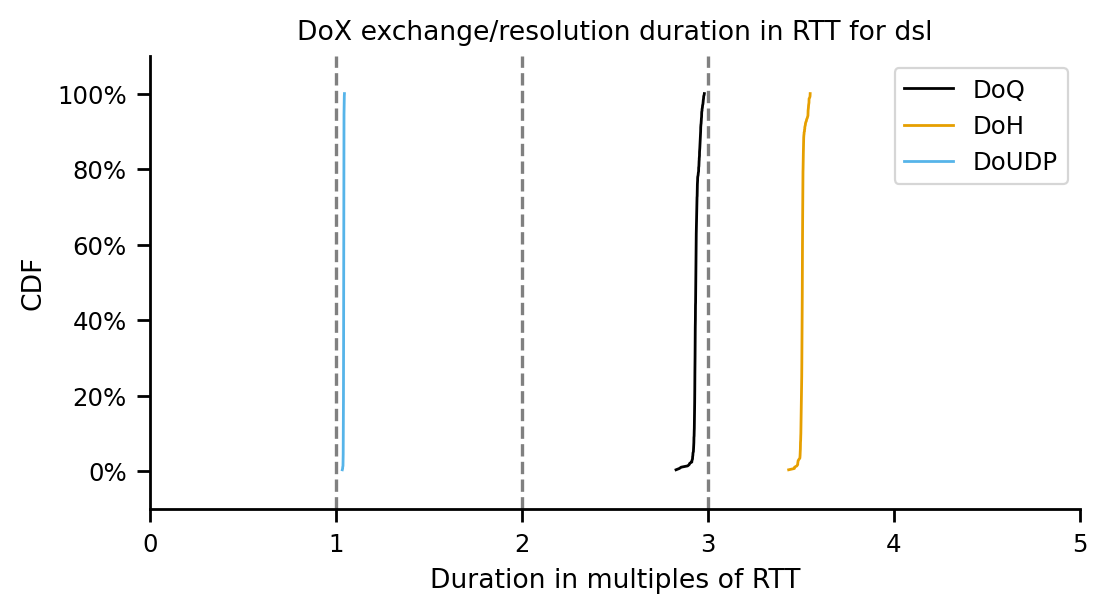

DoQ
count    290.000000
mean       2.134913
std        0.007458
min        2.108462
10%        2.128188
20%        2.129316
25%        2.129802
30%        2.130339
40%        2.131474
50%        2.132774
60%        2.134009
70%        2.138037
75%        2.141305
80%        2.143225
90%        2.145665
100%       2.151543
max        2.151543
Name: duration_in_rtt, dtype: float64
DoH
count    290.000000
mean       3.124263
std        0.006819
min        3.071857
10%        3.119770
20%        3.121566
25%        3.122039
30%        3.122569
40%        3.123358
50%        3.124026
60%        3.124759
70%        3.125629
75%        3.126273
80%        3.126736
90%        3.129552
100%       3.147049
max        3.147049
Name: duration_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.008348
std        0.000600
min        1.006121
10%        1.007513
20%        1.007907
25%        1.008101
30%        1.008189
40%        1.008301
50%        1.008409
60%        1.008542
70%       

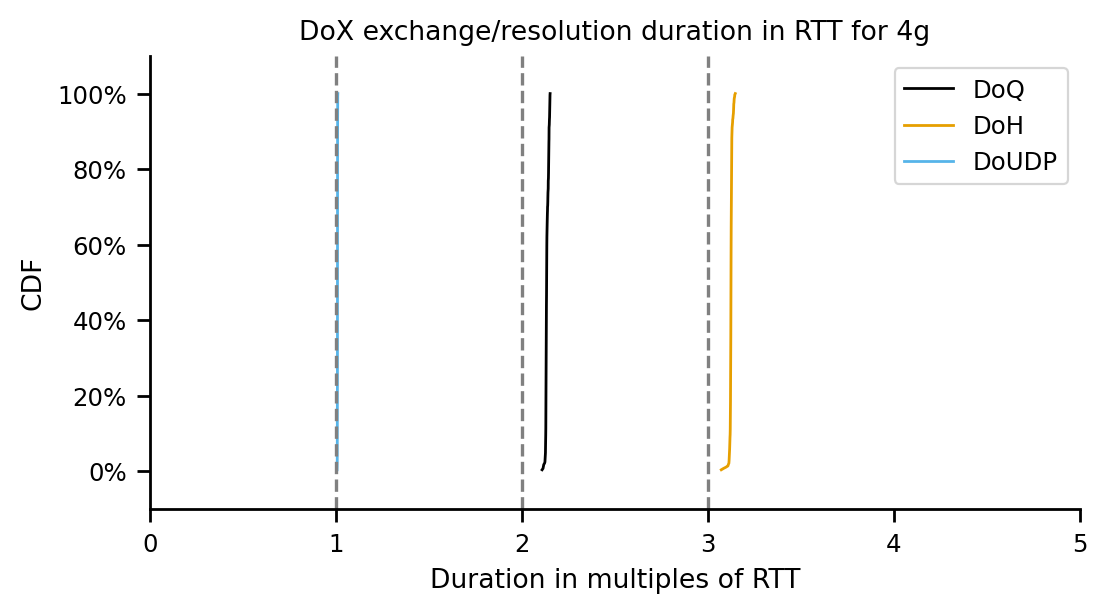

DoQ
count    290.000000
mean       2.157517
std        0.007650
min        2.111028
10%        2.153146
20%        2.154194
25%        2.154596
30%        2.154857
40%        2.155557
50%        2.156117
60%        2.156732
70%        2.158051
75%        2.159779
80%        2.164756
90%        2.167677
100%       2.174591
max        2.174591
Name: duration_in_rtt, dtype: float64
DoH
count    290.000000
mean       3.124498
std        0.005663
min        3.089129
10%        3.119512
20%        3.122554
25%        3.122873
30%        3.123223
40%        3.123895
50%        3.124516
60%        3.125221
70%        3.125993
75%        3.126445
80%        3.126844
90%        3.129100
100%       3.140991
max        3.140991
Name: duration_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.009001
std        0.000496
min        1.007137
10%        1.008284
20%        1.008726
25%        1.008804
30%        1.008864
40%        1.008976
50%        1.009057
60%        1.009145
70%       

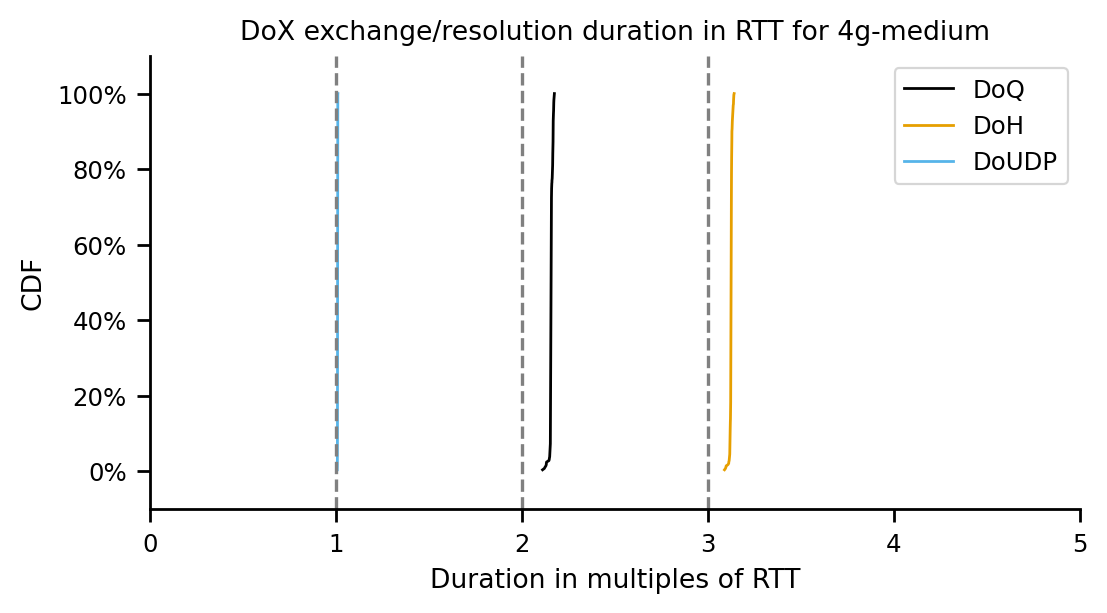

In [73]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    plt.axvline(x=1, color='gray', linestyle='--')
    plt.axvline(x=2, color='gray', linestyle='--')
    plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX exchange/resolution duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/exchange-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/exchange-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    1453.000000
mean       74.191506
std        36.859207
min        21.500527
10%        26.195999
20%        30.312307
25%        37.449668
30%        37.668790
40%        39.395507
50%        81.946533
60%        83.871054
70%       104.045562
75%       104.829970
80%       105.752261
90%       120.817192
100%      122.749574
max       122.749574
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1453.000000
mean       69.159644
std        36.191513
min        21.874836
10%        25.298831
20%        30.166114
25%        35.885405
30%        36.085775
40%        38.296488
50%        63.860154
60%        65.632433
70%       103.242468
75%       103.448380
80%       105.256075
90%       117.512050
100%      119.238296
max       119.238296
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1453.000000
mean       56.666977
std        35.969389
min        15.180565
10%        15.496080
20%        19.640055
25%        25.937948
30%

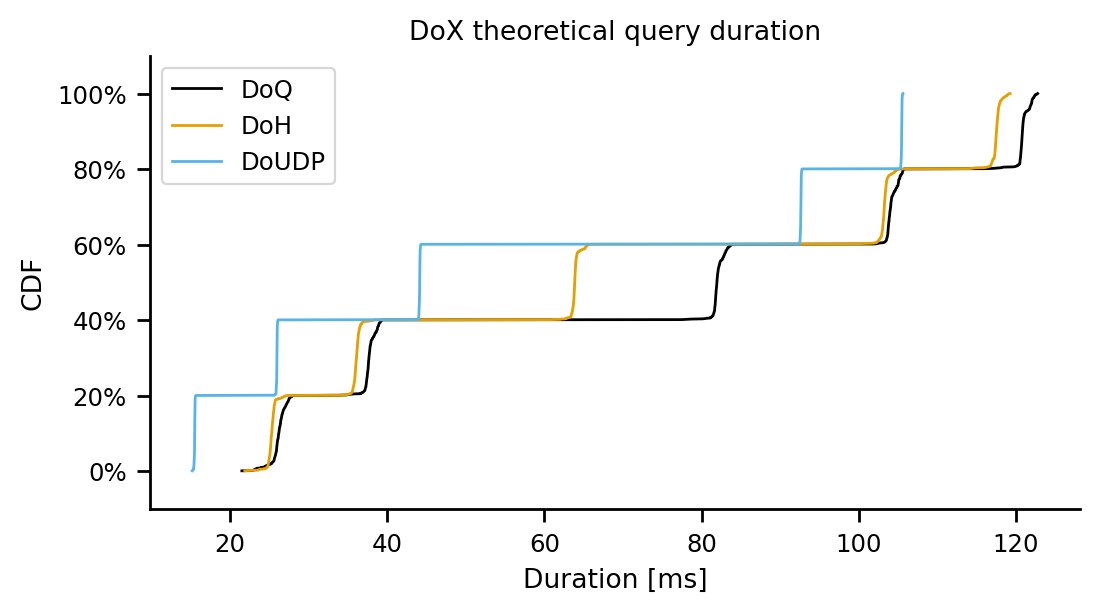

In [84]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

#plt.axvline(x=1, color='gray', linestyle='--')
#plt.axvline(x=2, color='gray', linestyle='--')
#plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical query duration')

ax.set_xlabel('Duration [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/theoretical-query-duration-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/theoretical-query-duration.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean      26.149575
std        0.949875
min       21.500527
10%       25.293339
20%       25.761054
25%       25.883425
30%       25.933894
40%       26.040782
50%       26.192058
60%       26.364032
70%       26.524075
75%       26.634333
80%       26.762272
90%       27.261074
100%      27.996603
max       27.996603
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    291.000000
mean      25.292047
std        0.549345
min       21.874836
10%       24.872169
20%       25.040820
25%       25.100908
30%       25.147833
40%       25.210000
50%       25.297173
60%       25.380306
70%       25.464264
75%       25.502960
80%       25.566474
90%       25.690543
100%      27.250010
max       27.250010
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    291.000000
mean      15.486982
std        0.058406
min       15.180565
10%       15.412937
20%       15.458091
25%       15.471433
30%       15.475837
40%       15.490406
50% 

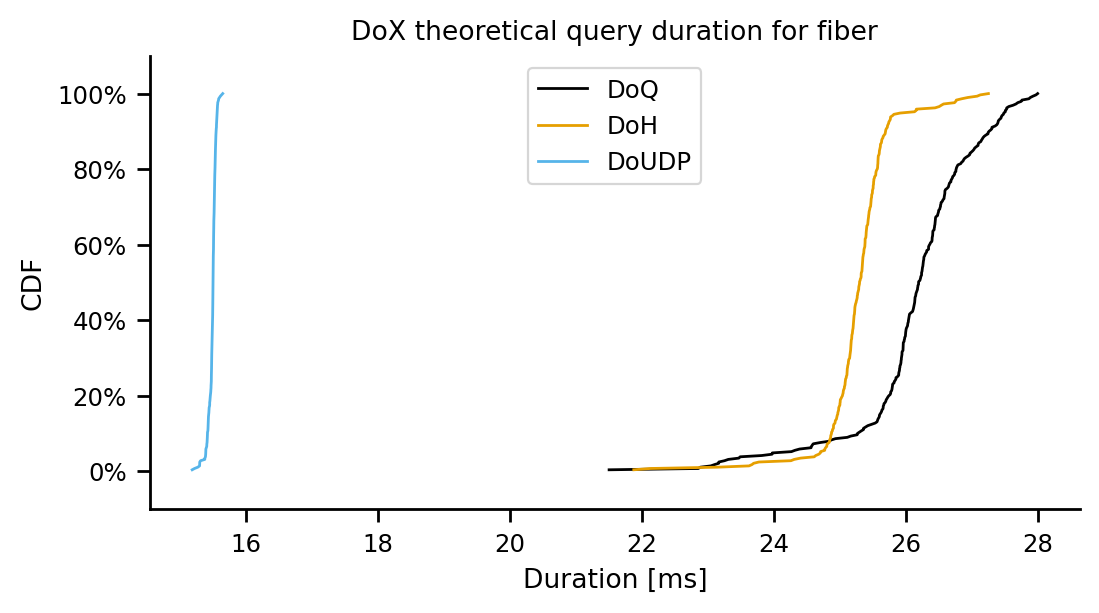

DoQ
count    291.000000
mean      37.785118
std        0.710348
min       33.785862
10%       37.228061
20%       37.382332
25%       37.450440
30%       37.493306
40%       37.596041
50%       37.671218
60%       37.769322
70%       37.928011
75%       38.099296
80%       38.377277
90%       38.768276
100%      39.404324
max       39.404324
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    291.000000
mean      36.103385
std        0.444774
min       34.540270
10%       35.677354
20%       35.839923
25%       35.888872
30%       35.919868
40%       36.000788
50%       36.086798
60%       36.150129
70%       36.228222
75%       36.281949
80%       36.310106
90%       36.500246
100%      38.301754
max       38.301754
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    291.000000
mean      25.955447
std        0.058360
min       25.634922
10%       25.879881
20%       25.930188
25%       25.937977
30%       25.942935
40%       25.954802
50% 

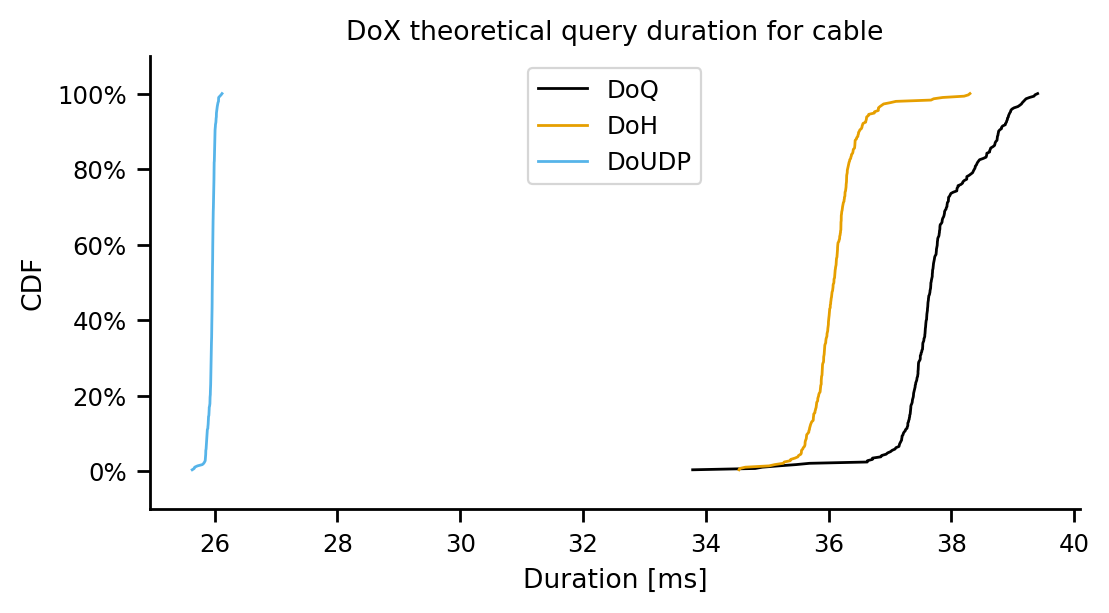

DoQ
count    291.000000
mean      82.077205
std        0.724225
min       77.456191
10%       81.582263
20%       81.719562
25%       81.750707
30%       81.791844
40%       81.867665
50%       81.948599
60%       82.022249
70%       82.189755
75%       82.305756
80%       82.606766
90%       83.062229
100%      83.905511
max       83.905511
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    291.000000
mean      63.905333
std        0.519410
min       60.749614
10%       63.530464
20%       63.685941
25%       63.724930
30%       63.757227
40%       63.808627
50%       63.861075
60%       63.896022
70%       63.945762
75%       63.975405
80%       64.029868
90%       64.354409
100%      65.646565
max       65.646565
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    291.000000
mean      44.119778
std        0.059074
min       43.813162
10%       44.042576
20%       44.078492
25%       44.094290
30%       44.103210
40%       44.117670
50% 

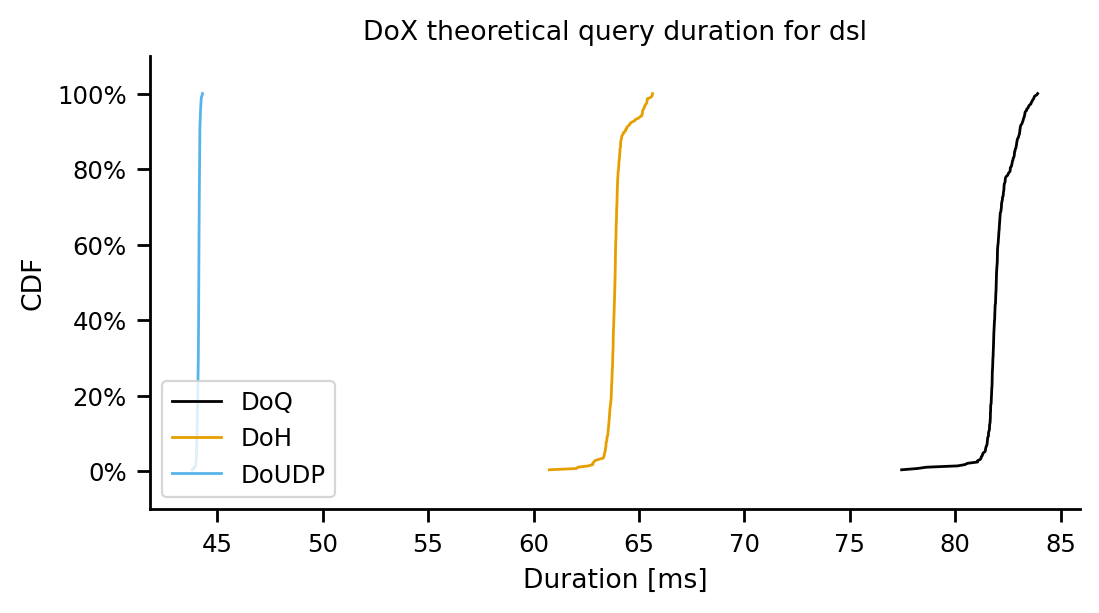

DoQ
count    290.000000
mean     104.244367
std        0.685032
min      101.814804
10%      103.626651
20%      103.730285
25%      103.774913
30%      103.824286
40%      103.928546
50%      104.047890
60%      104.161332
70%      104.531314
75%      104.831484
80%      105.007848
90%      105.231963
100%     105.771901
max      105.771901
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    290.000000
mean     103.266148
std        0.626325
min       98.452525
10%      102.853499
20%      103.018454
25%      103.061868
30%      103.110557
40%      103.182994
50%      103.244356
60%      103.311695
70%      103.391666
75%      103.450735
80%      103.493321
90%      103.751958
100%     105.359138
max      105.359138
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    290.000000
mean      92.619091
std        0.055077
min       92.414579
10%       92.542368
20%       92.578615
25%       92.596422
30%       92.604502
40%       92.614788
50% 

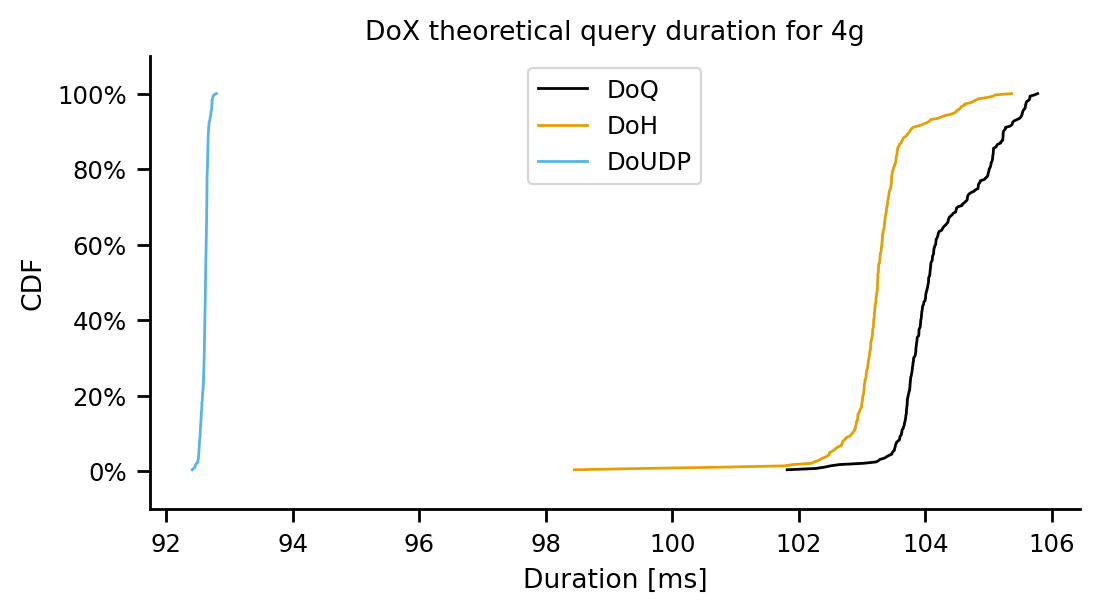

DoQ
count    290.000000
mean     120.965271
std        0.799411
min      116.106995
10%      120.508483
20%      120.618067
25%      120.660032
30%      120.687339
40%      120.760480
50%      120.819041
60%      120.883307
70%      121.021115
75%      121.201687
80%      121.721870
90%      122.027085
100%     122.749574
max      122.749574
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    290.000000
mean     117.514680
std        0.591789
min      113.818491
10%      116.993689
20%      117.311573
25%      117.344920
30%      117.381429
40%      117.451728
50%      117.516627
60%      117.590221
70%      117.670935
75%      117.718211
80%      117.759873
90%      117.995595
100%     119.238296
max      119.238296
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    290.000000
mean     105.444757
std        0.051863
min      105.250018
10%      105.369846
20%      105.416083
25%      105.424220
30%      105.430518
40%      105.442170
50% 

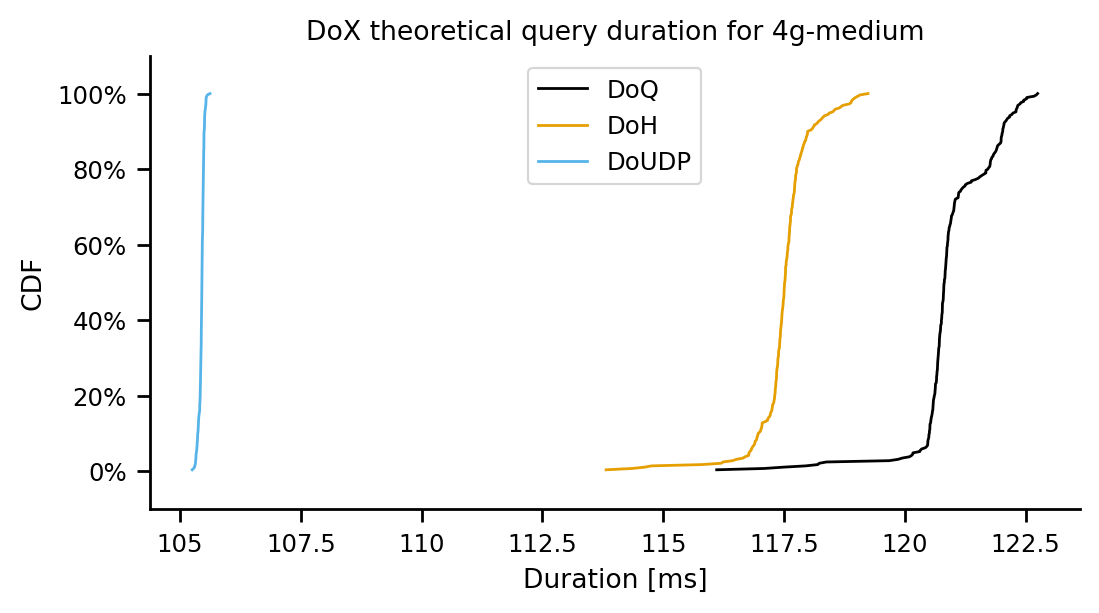

In [86]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical query duration for '+tech)

    ax.set_xlabel('Duration [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    #ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/theoretical-query-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/theoretical-query-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    1453.000000
mean        1.500816
std         0.322787
min         1.108462
10%         1.132539
20%         1.149440
25%         1.154638
30%         1.156122
40%         1.374287
50%         1.496276
60%         1.560865
70%         1.774205
75%         1.804207
80%         1.889985
90%         1.934575
100%        1.980782
max         1.980782
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1453.000000
mean        1.381177
std         0.229283
min         1.071857
10%         1.122571
20%         1.124274
25%         1.125205
30%         1.126396
40%         1.372264
50%         1.433358
60%         1.483071
70%         1.507613
75%         1.510349
80%         1.549232
90%         1.713069
100%        1.845313
max         1.845313
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1453.000000
mean        1.027741
std         0.016692
min         1.006121
10%         1.008299
20%         1.008729
25%         1.008936
30%         1.009131
40%       

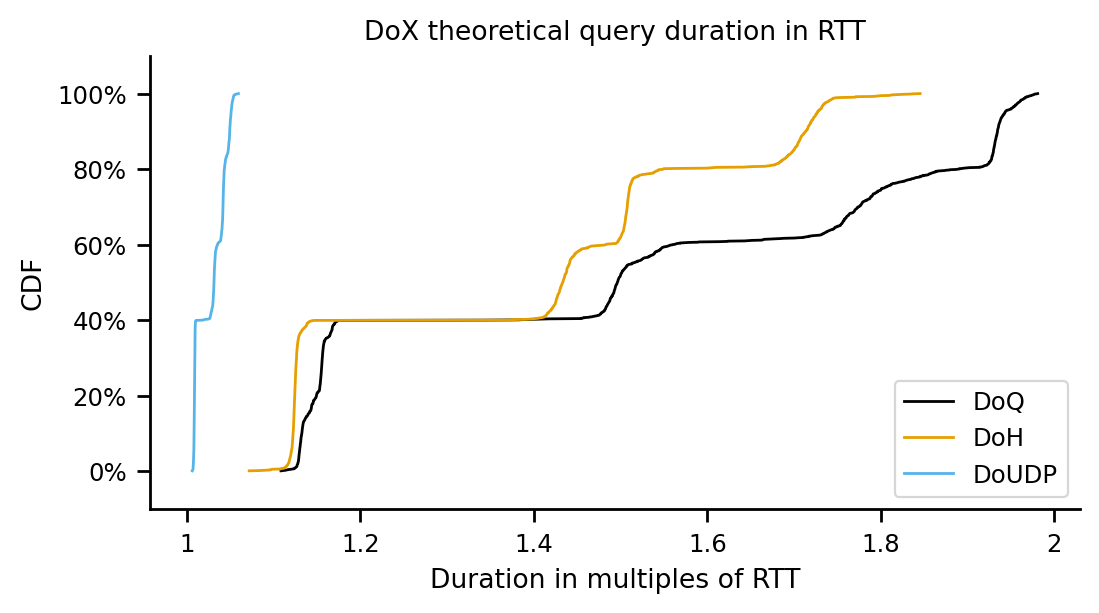

In [83]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

#plt.axvline(x=1, color='gray', linestyle='--')
#plt.axvline(x=2, color='gray', linestyle='--')
#plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical query duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/theoretical-query-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/theoretical-query-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean       1.770794
std        0.064324
min        1.455970
10%        1.712811
20%        1.744484
25%        1.752771
30%        1.756189
40%        1.763427
50%        1.773671
60%        1.785317
70%        1.796154
75%        1.803621
80%        1.812285
90%        1.846062
100%       1.895871
max        1.895871
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    291.000000
mean       1.712724
std        0.037200
min        1.481318
10%        1.684291
20%        1.695711
25%        1.699780
30%        1.702958
40%        1.707168
50%        1.713071
60%        1.718701
70%        1.724386
75%        1.727007
80%        1.731308
90%        1.739709
100%       1.845313
max        1.845313
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.048746
std        0.003955
min        1.027996
10%        1.043732
20%        1.046789
25%        1.047693
30%        1.047991
40%        1.048978
50%        1.049356
60%        1

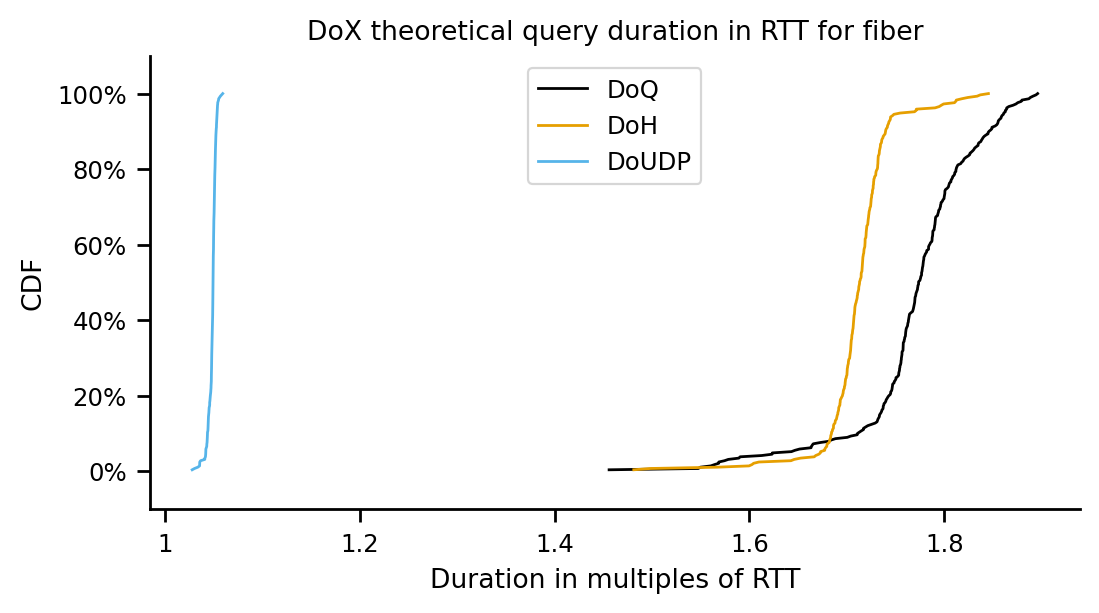

DoQ
count    291.000000
mean       1.500800
std        0.028215
min        1.341952
10%        1.478674
20%        1.484802
25%        1.487507
30%        1.489209
40%        1.493290
50%        1.496276
60%        1.500173
70%        1.506476
75%        1.513279
80%        1.524320
90%        1.539850
100%       1.565114
max        1.565114
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    291.000000
mean       1.434003
std        0.017666
min        1.371917
10%        1.417081
20%        1.423538
25%        1.425482
30%        1.426714
40%        1.429928
50%        1.433344
60%        1.435859
70%        1.438961
75%        1.441095
80%        1.442214
90%        1.449766
100%       1.521321
max        1.521321
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.030933
std        0.002318
min        1.018202
10%        1.027932
20%        1.029930
25%        1.030239
30%        1.030436
40%        1.030908
50%        1.031234
60%        1

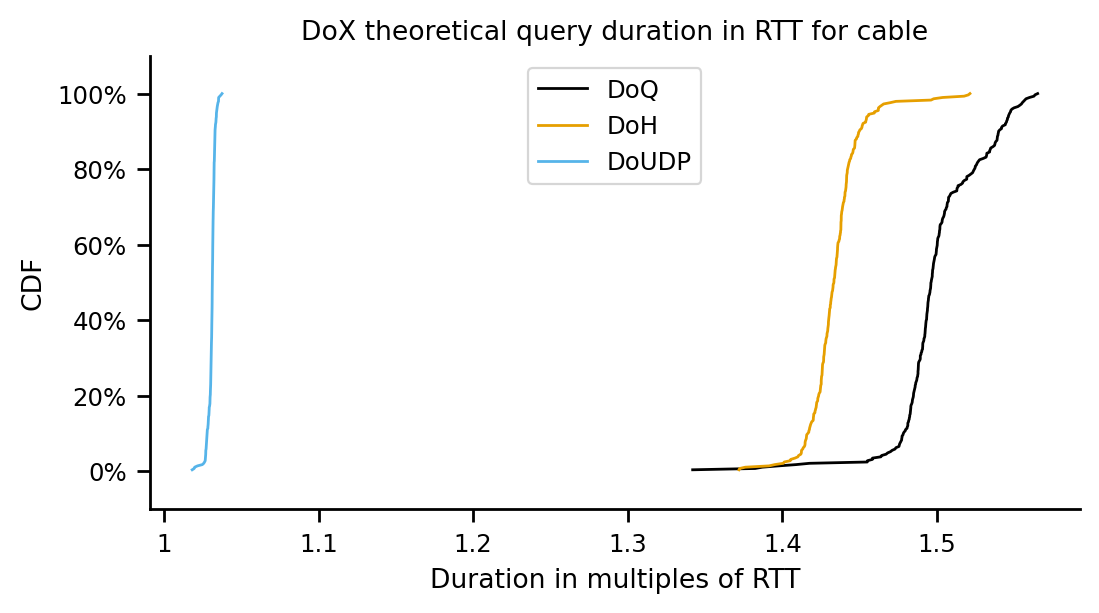

DoQ
count    291.000000
mean       1.937621
std        0.017097
min        1.828531
10%        1.925936
20%        1.929178
25%        1.929913
30%        1.930884
40%        1.932674
50%        1.934585
60%        1.936323
70%        1.940278
75%        1.943016
80%        1.950122
90%        1.960874
100%       1.980782
max        1.980782
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    291.000000
mean       1.508632
std        0.012262
min        1.434134
10%        1.499782
20%        1.503453
25%        1.504373
30%        1.505136
40%        1.506349
50%        1.507587
60%        1.508412
70%        1.509586
75%        1.510286
80%        1.511572
90%        1.519233
100%       1.549738
max        1.549738
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.041549
std        0.001395
min        1.034310
10%        1.039726
20%        1.040574
25%        1.040947
30%        1.041157
40%        1.041499
50%        1.041696
60%        1

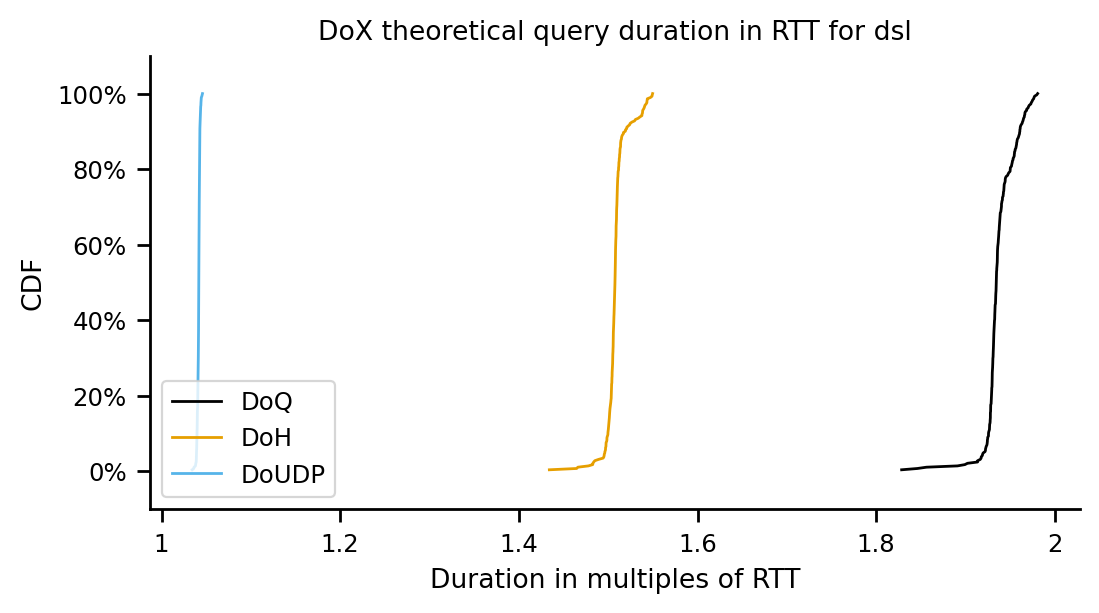

DoQ
count    290.000000
mean       1.134913
std        0.007458
min        1.108462
10%        1.128188
20%        1.129316
25%        1.129802
30%        1.130339
40%        1.131474
50%        1.132774
60%        1.134009
70%        1.138037
75%        1.141305
80%        1.143225
90%        1.145665
100%       1.151543
max        1.151543
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    290.000000
mean       1.124263
std        0.006819
min        1.071857
10%        1.119770
20%        1.121566
25%        1.122039
30%        1.122569
40%        1.123358
50%        1.124026
60%        1.124759
70%        1.125629
75%        1.126273
80%        1.126736
90%        1.129552
100%       1.147049
max        1.147049
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.008348
std        0.000600
min        1.006121
10%        1.007513
20%        1.007907
25%        1.008101
30%        1.008189
40%        1.008301
50%        1.008409
60%        1

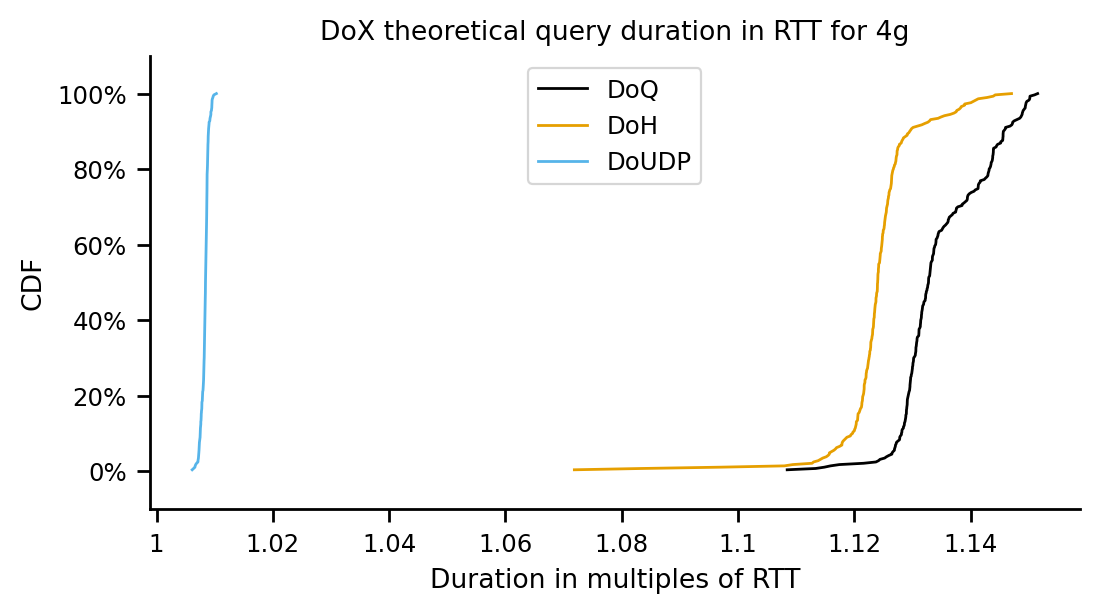

DoQ
count    290.000000
mean       1.157517
std        0.007650
min        1.111028
10%        1.153146
20%        1.154194
25%        1.154596
30%        1.154857
40%        1.155557
50%        1.156117
60%        1.156732
70%        1.158051
75%        1.159779
80%        1.164756
90%        1.167677
100%       1.174591
max        1.174591
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    290.000000
mean       1.124498
std        0.005663
min        1.089129
10%        1.119512
20%        1.122554
25%        1.122873
30%        1.123223
40%        1.123895
50%        1.124516
60%        1.125221
70%        1.125993
75%        1.126445
80%        1.126844
90%        1.129100
100%       1.140991
max        1.140991
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.009001
std        0.000496
min        1.007137
10%        1.008284
20%        1.008726
25%        1.008804
30%        1.008864
40%        1.008976
50%        1.009057
60%        1

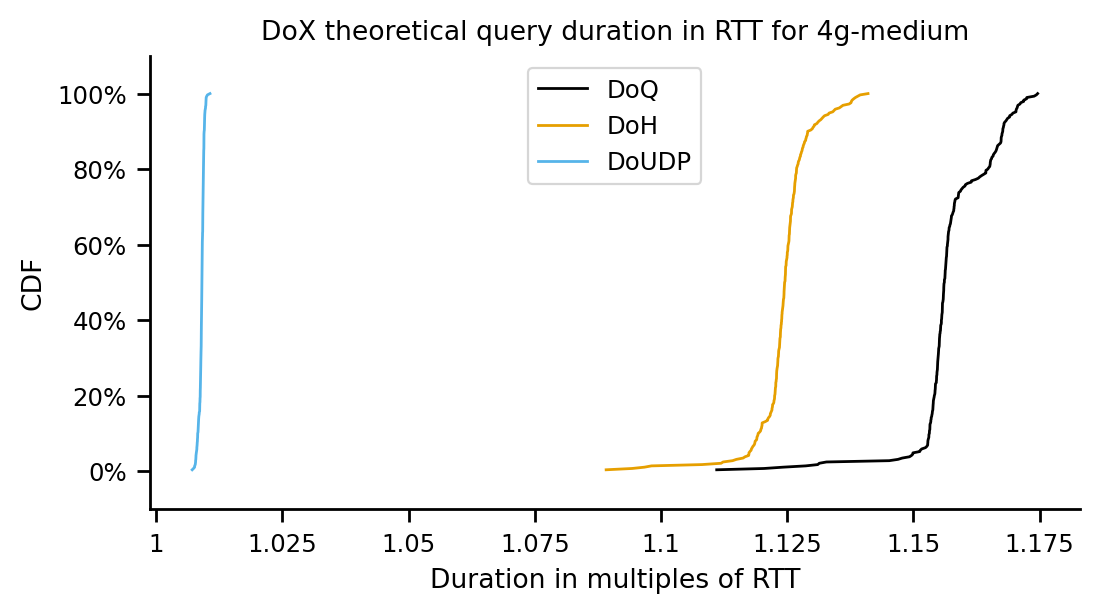

In [87]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical query duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    #ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/theoretical-query-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/theoretical-query-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    1453.000000
mean       18.517923
std        10.780465
min         6.733380
10%        11.369782
20%        11.867854
25%        12.018651
30%        12.179355
40%        12.452437
50%        12.981037
60%        13.981915
70%        16.314827
75%        16.703125
80%        28.356013
90%        39.588396
100%       41.545721
max        41.545721
Name: theoretical_processing_delay, dtype: float64
DoH
count    1453.000000
mean       13.486062
std         4.158389
min         6.600214
10%        10.439774
20%        10.700967
25%        10.803094
30%        10.910978
40%        11.175233
50%        11.448235
60%        12.433567
70%        13.025244
75%        13.218650
80%        16.927556
90%        21.501101
100%       23.286775
max        23.286775
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1453.000000
mean        0.993395
std         0.394986
min         0.413418
10%         0.704771
20%         0.737676
25%         0.752087
30%         0.762793
40

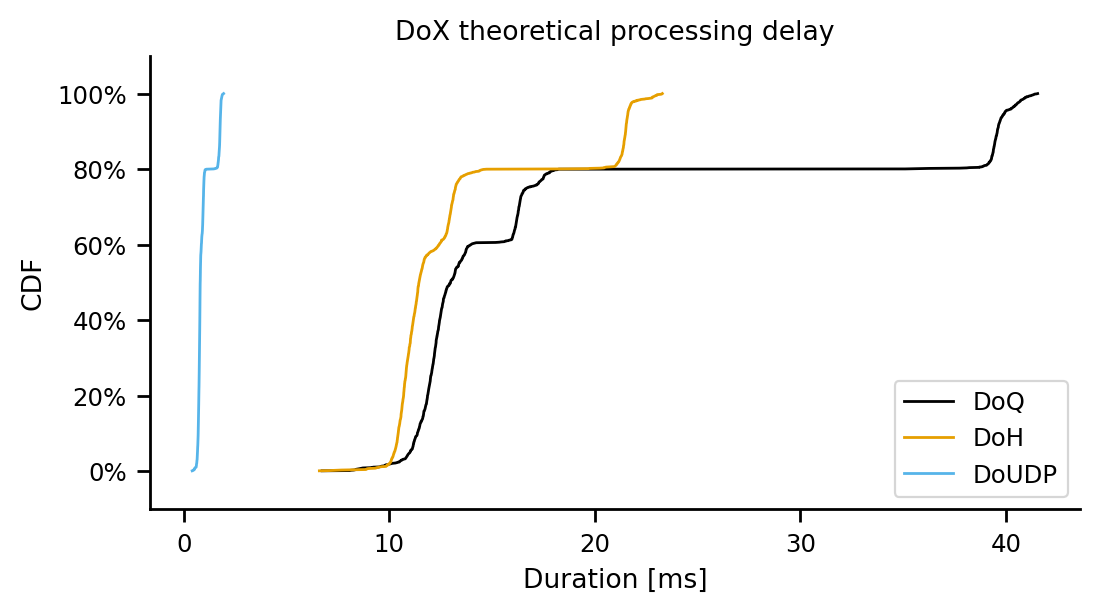

In [90]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)



ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical processing delay')

ax.set_xlabel('Duration [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/processing-delay-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/processing-delay.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean      11.382428
std        0.949875
min        6.733380
10%       10.526192
20%       10.993907
25%       11.116278
30%       11.166747
40%       11.273635
50%       11.424911
60%       11.596885
70%       11.756928
75%       11.867186
80%       11.995125
90%       12.493927
100%      13.229456
max       13.229456
Name: theoretical_processing_delay, dtype: float64
DoH
count    291.000000
mean      10.524900
std        0.549345
min        7.107689
10%       10.105022
20%       10.273673
25%       10.333761
30%       10.380686
40%       10.442853
50%       10.530026
60%       10.613159
70%       10.697117
75%       10.735813
80%       10.799327
90%       10.923396
100%      12.482863
max       12.482863
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    291.000000
mean       0.719835
std        0.058406
min        0.413418
10%        0.645790
20%        0.690944
25%        0.704287
30%        0.708690
40%        0.723259
50%        0.728840
60% 

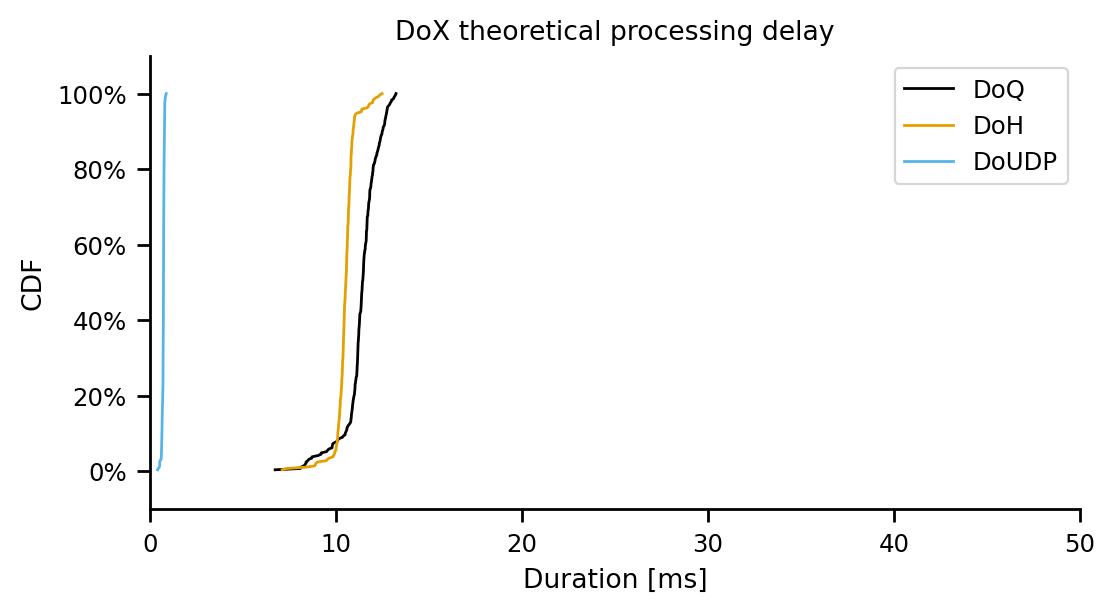

DoQ
count    291.000000
mean      12.608468
std        0.710348
min        8.609212
10%       12.051411
20%       12.205682
25%       12.273790
30%       12.316656
40%       12.419391
50%       12.494568
60%       12.592672
70%       12.751361
75%       12.922646
80%       13.200627
90%       13.591626
100%      14.227674
max       14.227674
Name: theoretical_processing_delay, dtype: float64
DoH
count    291.000000
mean      10.926735
std        0.444774
min        9.363620
10%       10.500704
20%       10.663273
25%       10.712222
30%       10.743218
40%       10.824138
50%       10.910148
60%       10.973479
70%       11.051572
75%       11.105299
80%       11.133456
90%       11.323596
100%      13.125104
max       13.125104
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    291.000000
mean       0.778797
std        0.058360
min        0.458272
10%        0.703231
20%        0.753538
25%        0.761328
30%        0.766285
40%        0.778152
50%        0.786379
60% 

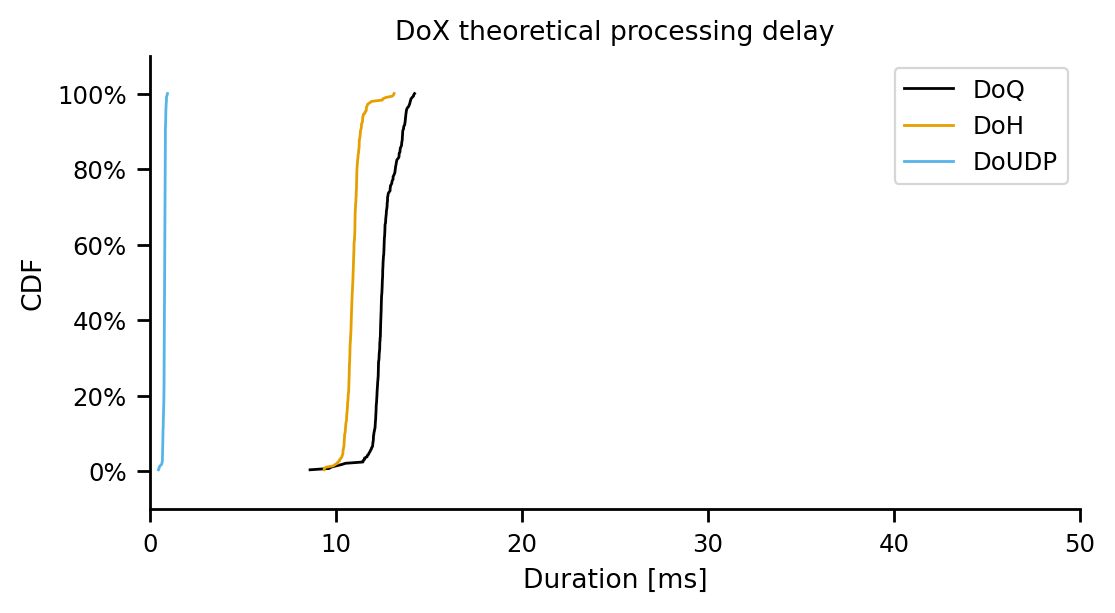

DoQ
count    291.000000
mean      39.717415
std        0.724225
min       35.096401
10%       39.222473
20%       39.359772
25%       39.390917
30%       39.432054
40%       39.507875
50%       39.588809
60%       39.662459
70%       39.829965
75%       39.945966
80%       40.246976
90%       40.702439
100%      41.545721
max       41.545721
Name: theoretical_processing_delay, dtype: float64
DoH
count    291.000000
mean      21.545543
std        0.519410
min       18.389824
10%       21.170674
20%       21.326151
25%       21.365140
30%       21.397437
40%       21.448837
50%       21.501285
60%       21.536232
70%       21.585972
75%       21.615615
80%       21.670078
90%       21.994619
100%      23.286775
max       23.286775
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    291.000000
mean       1.759988
std        0.059074
min        1.453372
10%        1.682786
20%        1.718702
25%        1.734500
30%        1.743420
40%        1.757880
50%        1.766219
60% 

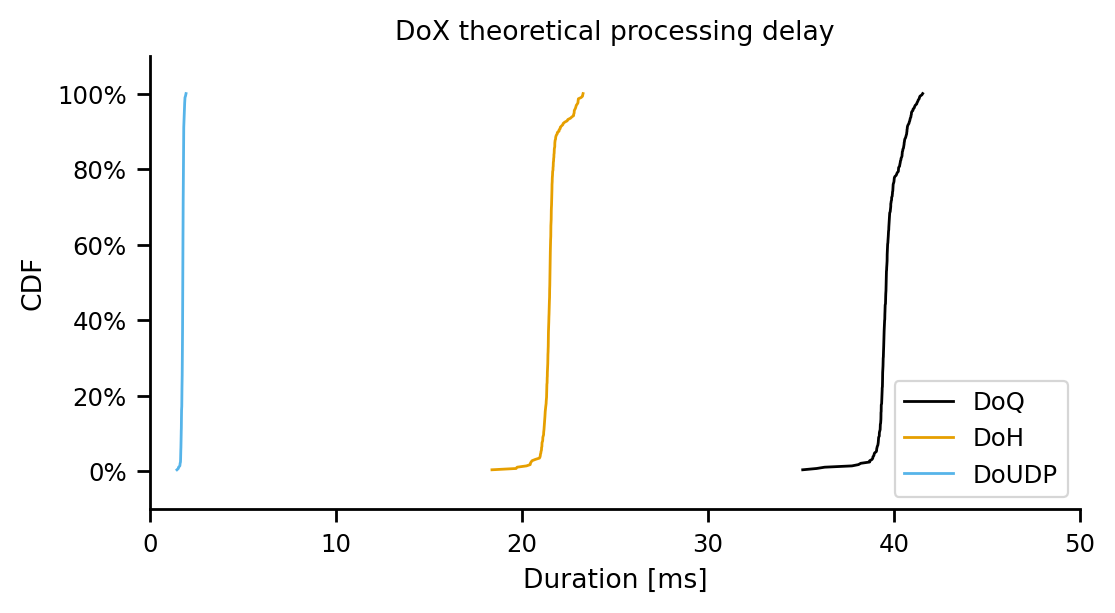

DoQ
count    290.000000
mean      12.392056
std        0.685032
min        9.962494
10%       11.774341
20%       11.877974
25%       11.922602
30%       11.971975
40%       12.076236
50%       12.195579
60%       12.309021
70%       12.679004
75%       12.979173
80%       13.155537
90%       13.379653
100%      13.919591
max       13.919591
Name: theoretical_processing_delay, dtype: float64
DoH
count    290.000000
mean      11.413837
std        0.626325
min        6.600214
10%       11.001189
20%       11.166143
25%       11.209558
30%       11.258247
40%       11.330684
50%       11.392046
60%       11.459385
70%       11.539356
75%       11.598424
80%       11.641010
90%       11.899648
100%      13.506827
max       13.506827
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    290.000000
mean       0.766780
std        0.055077
min        0.562268
10%        0.690058
20%        0.726304
25%        0.744112
30%        0.752191
40%        0.762477
50%        0.772425
60% 

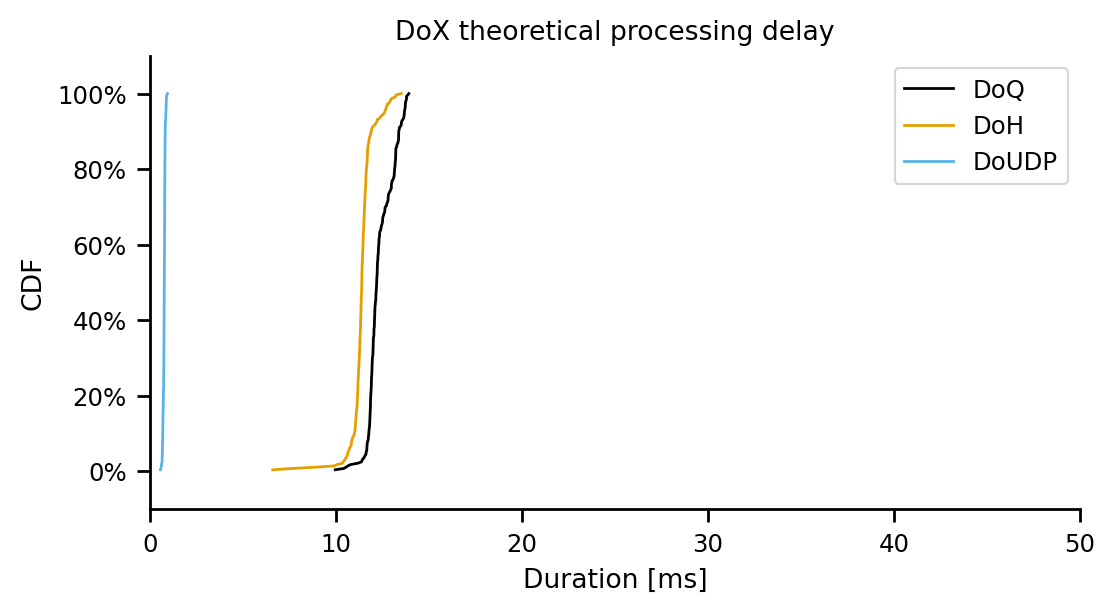

DoQ
count    290.000000
mean      16.461129
std        0.799411
min       11.602853
10%       16.004340
20%       16.113924
25%       16.155890
30%       16.183196
40%       16.256338
50%       16.314899
60%       16.379164
70%       16.516972
75%       16.697544
80%       17.217727
90%       17.522942
100%      18.245432
max       18.245432
Name: theoretical_processing_delay, dtype: float64
DoH
count    290.000000
mean      13.010537
std        0.591789
min        9.314348
10%       12.489546
20%       12.807430
25%       12.840777
30%       12.877287
40%       12.947586
50%       13.012485
60%       13.086079
70%       13.166793
75%       13.214068
80%       13.255730
90%       13.491453
100%      14.734153
max       14.734153
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    290.000000
mean       0.940614
std        0.051863
min        0.745875
10%        0.865703
20%        0.911941
25%        0.920077
30%        0.926375
40%        0.938027
50%        0.946453
60% 

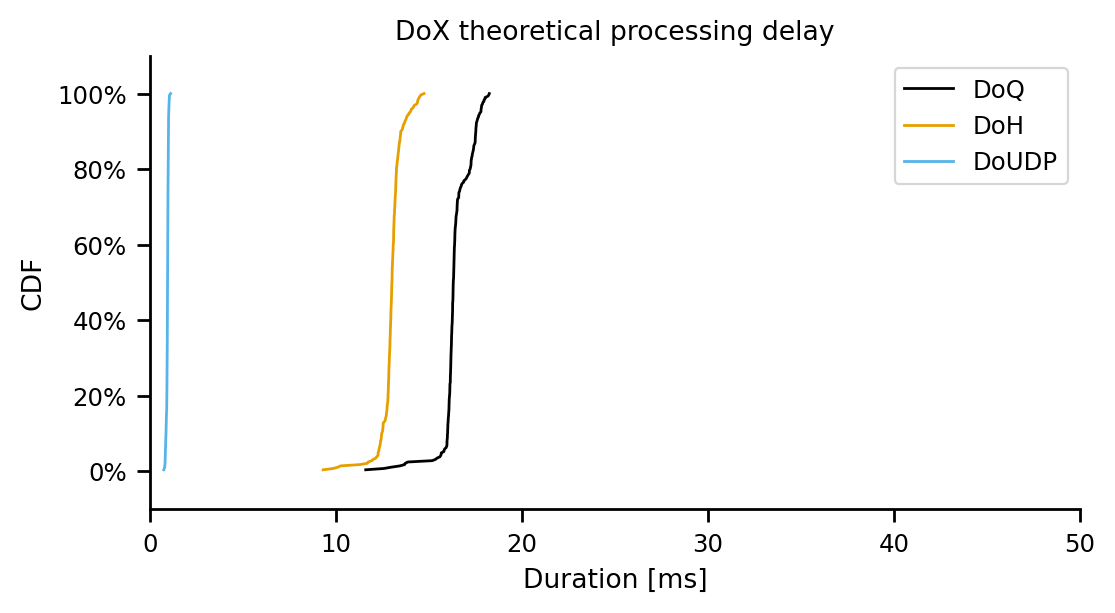

In [92]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical processing delay')

    ax.set_xlabel('Duration [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 50)
    ax.legend()


    if log:
        fig.savefig('figures/processing-delay-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/processing-delay-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [196]:
median_doq_0rtt_4g = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.experiment_type == '4g')].full_plt.median()
median_doq_0rtt_4g_med = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.experiment_type == '4g-medium')].full_plt.median()
print(str((median_doq_0rtt_4g_med/(median_doq_0rtt_4g/100))-100)+"%")

11.270315269069528%


In [197]:
median_doudp_1rtt_4g = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT') & (df_dns_and_h3.experiment_type == '4g')].full_plt.median()
median_doudp_1rtt_4g_med = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT') & (df_dns_and_h3.experiment_type == '4g-medium')].full_plt.median()
print(str((median_doudp_1rtt_4g_med/(median_doudp_1rtt_4g/100))-100)+"%")

9.029864320271287%
